# Table of Contents <a name='top'></a>
                                                          

1. [Import Packages](#imports)<br>
2. [Define Functions](#function)<br>
3. [Model 1 dataset (Mark's dataset)](#ds1) <br>
  3a. [Preprocessing](#ds1preprocess)<br>
  3b. [EDA](#ds1explore)<br>
  3c. [Baseline](#baseline)<br>
  3d. [Modeling](#ds1modeling)<br>
4. [Model 2 dataset (original dataset)](#ds2)<br>
  4a. [Preprocessing](#ds2preprocess)<br>
  4b. [EDA](#ds2explore)<br>
  4c. [Modeling](#ds2modeling)


---
## 1. Import Packages <a name='imports'></a>
[jump to top](#top)<br>

In [ ]:
!pip install -q chart_studio

In [ ]:
!pip install -q transformers

In [ ]:
!pip install -q tensorflow_addons

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

## uncomment these if not already installed
# !pip install chart_studio
# !pip install textstat

import numpy as np
import pandas as pd

# text processing libraries
import re
import string
import nltk
from nltk.corpus import stopwords

# time
import time
import random

# Visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import chart_studio.plotly as py
import plotly.figure_factory as ff
from plotly.offline import iplot
# import cufflinks
# cufflinks.go_offline()
# cufflinks.set_config_file(world_readable=True, theme='pearl')

import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
from tensorflow.keras.optimizers import SGD
# sklearn
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor


# imblearn
import imblearn

# File system manangement
import os

# Pytorch
import torch

#Transformers
from transformers import BertTokenizer, TFBertModel

#google collab drive mount
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


---
## 2. Define Functions <a name='function'></a>
[jump to top](#top)<br>

In [ ]:
# this model takes the training tokens as inputs, sending them through a bert embedding layer as the first step

def king_model(bert_model,
               num_train_layers = 0,
               hidden_size = 200,
               dropout = 0.3,
               learning_rate = 0.00005,
               MAX_SEQUENCE_LENGTH = 600,
               num_classes = 9,
               loss_function = "CategoricalCrossentropy"):
    """
    Pretraining fine tuning to produce 6 output scores
    """
    categorical_crossentropy = ["Categorical Crossentropy", "categorical crossentropy",
                                "Categorical_Crossentropy", "categorical_crossentropy",
                                "CategoricalCrossentropy", "categoricalcrossentropy",
                                "CCE", "cce",
                                "SCCE", "scce",
                                "Multiclass", "multiclass",
                                "Multiclass classification", "multiclass classification"]
    ordinal_classification = ["Ordinal Classification", "ordinal classification",
                              "Ordinal_Classification", "ordinal_classification",
                              "weighted_kappa_loss", "WeightedKappaLoss"]
    regression = ["Regression", "regression", "MSE", "mse"]
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)


    if num_train_layers == 0:
        # Freeze all layers of pre-trained BERT model
        bert_model.trainable = False

    elif num_train_layers == 12:
        # Train all layers of the BERT model
        bert_model.trainable = True

    else:
        # Restrict training to the num_train_layers outer transformer layers
        retrain_layers = []

        for retrain_layer_number in range(num_train_layers):

            layer_code = '_' + str(11 - retrain_layer_number)
            retrain_layers.append(layer_code)


        print('retrain layers: ', retrain_layers)

        for w in bert_model.weights:
            if not any([x in w.name for x in retrain_layers]):
                #print('freezing: ', w)
                w._trainable = False

    input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_model(bert_inputs)

    #pooler_token = bert_out[1]
    cls_token = bert_out[0][:, 0, :]

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cls_token)

    hidden = tf.keras.layers.Dropout(dropout)(hidden)

    if loss_function in categorical_crossentropy or loss_function in ordinal_classification:
      cohesion_score = tf.keras.layers.Dense(num_classes, activation='softmax', name='cohesion_output')(hidden)
      syntax_score = tf.keras.layers.Dense(num_classes, activation='softmax', name='syntax_output')(hidden)
      vocabulary_score = tf.keras.layers.Dense(num_classes, activation='softmax', name='vocabulary_output')(hidden)
      phraseology_score = tf.keras.layers.Dense(num_classes, activation='softmax', name='phraseology_output')(hidden)
      grammar_score = tf.keras.layers.Dense(num_classes, activation='softmax', name='grammar_output')(hidden)
      conventions_score = tf.keras.layers.Dense(num_classes, activation='softmax', name='conventions_output')(hidden)

    elif loss_function in regression:
      cohesion_score = tf.keras.layers.Dense(1, activation='linear', name='cohesion_output')(hidden)
      syntax_score = tf.keras.layers.Dense(1, activation='linear', name='syntax_output')(hidden)
      vocabulary_score = tf.keras.layers.Dense(1, activation='linear', name='vocabulary_output')(hidden)
      phraseology_score = tf.keras.layers.Dense(1, activation='linear', name='phraseology_output')(hidden)
      grammar_score = tf.keras.layers.Dense(1, activation='linear', name='grammar_output')(hidden)
      conventions_score = tf.keras.layers.Dense(1, activation='linear', name='conventions_output')(hidden)

    inputs = [input_ids, token_type_ids, attention_mask]
    outputs = [cohesion_score, syntax_score, vocabulary_score, phraseology_score, grammar_score, conventions_score]

    classification_model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # create weight dictionary (to be used during compilation)
    output_names = ["cohesion_output", "syntax_output", "vocabulary_output", "phraseology_output", "grammar_output", "conventions_output"]
    total = len(train)
    class_weights = {}
    for i in range(6):
      weights = []
      for j in range(9):
        count = len(y_train[i][y_train[i]==j])
        prop = count/total
        weight = 0.5*(1/prop)
        weights.append(weight)
      tf_const = tf.constant(weights)
      class_weights[output_names[i]] = tf_const



    if loss_function in categorical_crossentropy:
        classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                    loss={k: class_loss(v) for k,v in class_weights.items()}, # custom loss function for each of the 6 outputs
                                    metrics=['accuracy'])
    elif loss_function in regression:
        classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                    loss="mean_squared_error",
                                    metrics=['mse'])
    else:
        print("You entered a loss function that is not recognizable to this model. Please recreate the model and choose a loss function from: ")
        print("1. Multiclass Classification: 'CategoricalCrossentropy'")
        print("2. Ordinal Classification: 'WeightedKappaLoss'")
        print("3. Regression: 'MSE'")

    return classification_model

In [ ]:
# this function takes the cls token as input, bypassing the bert modeling stage from the above function

def fast_model(hidden_size = 300,
               dropout = 0.3,
               learning_rate = 0.00005,
               MAX_SEQUENCE_LENGTH = 600,
               num_classes = 9,
               loss_function = "CategoricalCrossentropy"):
    """
    Pretraining fine tuning to produce 6 output scores
    """
    categorical_crossentropy = ["Categorical Crossentropy", "categorical crossentropy",
                            "Categorical_Crossentropy", "categorical_crossentropy",
                            "CategoricalCrossentropy", "categoricalcrossentropy",
                            "CCE", "cce",
                            "SCCE", "scce",
                            "Multiclass", "multiclass",
                            "Multiclass classification", "multiclass classification"]
    ordinal_classification = ["Ordinal Classification", "ordinal classification",
                              "Ordinal_Classification", "ordinal_classification",
                              "weighted_kappa_loss", "WeightedKappaLoss"]
    regression = ["Regression", "regression", "MSE", "mse"]

    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    cls_token = tf.keras.layers.Input(shape=(768,), dtype="float32", name="cls_token_input")

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cls_token)

    hidden = tf.keras.layers.Dropout(dropout)(hidden)

    if loss_function in categorical_crossentropy or loss_function in ordinal_classification:
      cohesion_score = tf.keras.layers.Dense(num_classes, activation='softmax', name='cohesion_output')(hidden)
      syntax_score = tf.keras.layers.Dense(num_classes, activation='softmax', name='syntax_output')(hidden)
      vocabulary_score = tf.keras.layers.Dense(num_classes, activation='softmax', name='vocabulary_output')(hidden)
      phraseology_score = tf.keras.layers.Dense(num_classes, activation='softmax', name='phraseology_output')(hidden)
      grammar_score = tf.keras.layers.Dense(num_classes, activation='softmax', name='grammar_output')(hidden)
      conventions_score = tf.keras.layers.Dense(num_classes, activation='softmax', name='conventions_output')(hidden)

    elif loss_function in regression:
      cohesion_score = tf.keras.layers.Dense(1, activation='linear', name='cohesion_output')(hidden)
      syntax_score = tf.keras.layers.Dense(1, activation='linear', name='syntax_output')(hidden)
      vocabulary_score = tf.keras.layers.Dense(1, activation='linear', name='vocabulary_output')(hidden)
      phraseology_score = tf.keras.layers.Dense(1, activation='linear', name='phraseology_output')(hidden)
      grammar_score = tf.keras.layers.Dense(1, activation='linear', name='grammar_output')(hidden)
      conventions_score = tf.keras.layers.Dense(1, activation='linear', name='conventions_output')(hidden)

    inputs = cls_token
    outputs = [cohesion_score, syntax_score, vocabulary_score, phraseology_score, grammar_score, conventions_score]

    classification_model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # create weight dictionary (to be used during compilation)
    output_names = ["cohesion_output", "syntax_output", "vocabulary_output", "phraseology_output", "grammar_output", "conventions_output"]
    total = len(train)
    class_weights = {}
    for i in range(6):
      weights = []
      for j in range(9):
        count = len(y_train[i][y_train[i]==j])
        prop = count/total
        weight = 0.5*(1/prop)
        weights.append(weight)
      tf_const = tf.constant(weights)
      class_weights[output_names[i]] = tf_const


    # compile the model
    if loss_function in categorical_crossentropy:
        classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                    loss={k: class_loss(v) for k,v in class_weights.items()}, # custom loss function for each of the 6 outputs
                                    metrics=['accuracy'])
    elif loss_function in regression:
        classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                    loss="mean_squared_error",
                                    metrics=['mse'])
    else:
        print("You entered a loss function that is not recognizable to this model. Please recreate the model and choose a loss function from: ")
        print("1. Multiclass Classification: 'CategoricalCrossentropy'")
        print("2. Ordinal Classification: 'WeightedKappaLoss'")
        print("3. Regression: 'MSE'")

    return classification_model

**Text pre-processing functions**

In [ ]:
# use of these functions is just temporary, ultimatley we will need to preprocess using BERT functions like in HW2

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)

    text = re.sub('\w*\d\w*', '', text)
    return text


def text_preprocessing(text):
    """
    Cleaning and parsing the text.

    """
    text = re.sub('\n', ' ', text)
    text = re.sub('\r', '', text)
    text = re.sub(r'@\w+\s?', '', text)
    return text
    '''
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    nopunc = clean_text(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    #remove_stopwords = [w for w in tokenized_text if w not in stopwords.words('english')]
    combined_text = ' '.join(tokenized_text)'''
    return text

In [ ]:
def target_distributions(df):
  """Visuallize the distribution of each of the 6 targets for a given dataset"""

  fig, axs = plt.subplots(nrows = 2,
                          ncols = 3,
                          figsize = (12, 6))

  categories = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']

  a = [list(df[cat].value_counts().index) for cat in categories]
  a.sort()
  heights = [df[categories[i]].value_counts()[a[i]].values for i in range(6)]

  axs[0, 0].bar(a[0], height = heights[0], edgecolor = "black", width = 0.5)
  axs[0, 0].set_title(categories[0])
  axs[0, 1].bar(a[1], height = heights[1], edgecolor = "black", width = 0.5)
  axs[0, 1].set_title(categories[1])
  axs[0, 2].bar(a[2], height = heights[2], edgecolor = "black", width = 0.5)
  axs[0, 2].set_title(categories[2])
  axs[1, 0].bar(a[3], height = heights[3], edgecolor = "black", width = 0.5)
  axs[1, 0].set_title(categories[3])
  axs[1, 1].bar(a[4], height = heights[4], edgecolor = "black", width = 0.5)
  axs[1, 1].set_title(categories[4])
  axs[1, 2].bar(a[5], height = heights[5], edgecolor = "black", width = 0.5)
  axs[1, 2].set_title(categories[5]);


In [ ]:
def lump(df, bounds = [2, 4]):
  """Group together the ends of the distribution of the targets"""

  categories = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']
  lists = [[] for i in range(6)]

  new = df.copy()

  for i,cat in enumerate(categories):
    for score in new[cat]:
        if score >= bounds[0] and score <= bounds[1]:
          lists[i].append(score)
        elif score < bounds[0]:
          lists[i].append(bounds[0])
        elif score > bounds[1]:
          lists[i].append(bounds[1])
    new[cat] = lists[i]

  return new

In [ ]:
'''
def get_predictions(model, dataset = 1, fast=True, evaluation_metric="kappa"):
  """Given a trained model, generate predictions for the training, validation, and testing data sets
    Return the three predictions as a list"""

  if dataset == 1:
    train = cls_tensor_train_1
    val = cls_tensor_val_1
    test = cls_tensor_test_1
  else:
    train = cls_tensor_train_2
    val = cls_tensor_val_2
    test = cls_tensor_test_2

  if fast == True and evaluation_metric == "kappa":
    # probabilities
    predicted_probabilities_train = model.predict(train)
    predicted_probabilities_val = model.predict(val)
    predicted_probabilities_test = model.predict(test)

    # predictions
    predictions_train = tf.argmax(predicted_probabilities_train, axis=-1)
    predictions_val = tf.argmax(predicted_probabilities_val, axis=-1)
    predictions_test = tf.argmax(predicted_probabilities_test, axis=-1)

  # straight up guessing that .predict() is going to generate a continuous variable like we are hoping
  elif fast == True and evaluation_metric != "kappa":
    predictions_train = model.predict(train)
    predictions_val = model.predict(val)
    predictions_test = model.predict(test)

  elif fast == False and evaluation_metric == "kappa":
    # probabilities
    predicted_probabilities_train = model.predict([x_train["input_ids"], x_train["token_type_ids"], x_train["attention_mask"]])
    predicted_probabilities_val = model.predict([x_val["input_ids"], x_val["token_type_ids"], x_val["attention_mask"]])
    predicted_probabilities_test = model.predict([x_test["input_ids"], x_test["token_type_ids"], x_test["attention_mask"]])

    # predictions
    predictions_train = tf.argmax(predicted_probabilities_train, axis=-1)
    predictions_val = tf.argmax(predicted_probabilities_val, axis=-1)
    predictions_test = tf.argmax(predicted_probabilities_test, axis=-1)

  else:
    predictions_train = model.predict([x_train["input_ids"], x_train["token_type_ids"], x_train["attention_mask"]])
    predictions_val = model.predict([x_val["input_ids"], x_val["token_type_ids"], x_val["attention_mask"]])
    predictions_test = model.predict([x_test["input_ids"], x_test["token_type_ids"], x_test["attention_mask"]])

  return [predictions_train, predictions_val, predictions_test]
'''

In [ ]:

def get_predictions(model, dataset = 1, fast=True, evaluation_metric="kappa"):
  """Given a trained model, generate predictions for the training, validation, and testing data sets"""

  if dataset == 1:
    train = cls_tensor_train_1
    val = cls_tensor_val_1
    test = cls_tensor_test_1
  else:
    train = cls_tensor_train_2
    val = cls_tensor_val_2
    test = cls_tensor_test_2

  # if you don't care about retraining the BERT layers, then use the pre-generated cls tokens
  if fast == True:
    # probabilities
    predictions_train = model.predict(train)
    predictions_val = model.predict(val)
    predictions_test = model.predict(test)

  # if you DO want to retrain the BERT layers, then use the token ids generated from the train, val, and test sets
  elif fast == False:
    # probabilities
    predictions_train = model.predict([x_train["input_ids"], x_train["token_type_ids"], x_train["attention_mask"]])
    predictions_val = model.predict([x_val["input_ids"], x_val["token_type_ids"], x_val["attention_mask"]])
    predictions_test = model.predict([x_test["input_ids"], x_test["token_type_ids"], x_test["attention_mask"]])

  # if you train using categorical crossrntropy as the loss function, then you need to go one step further to get the predictions
  if evaluation_metric == "kappa":
    predictions_train = tf.argmax(predictions_train, axis=-1)
    predictions_val = tf.argmax(predictions_val, axis=-1)
    predictions_test = tf.argmax(predictions_test, axis=-1)

  return [predictions_train, predictions_val, predictions_test]


In [ ]:
def get_scores(predictions, evaluation_metric="kappa"):
  """Get the kappa score for the training, validation, and testing predictions.
  The only parameter - predictions - should be a list of [predictions_train, predictions_val, predictions_test]
  Returns the Average scores based on evaluation metric"""

  train_scores = []
  val_scores = []
  test_scores = []

  if evaluation_metric == "kappa":
      for i in range(6):
        kappa_train = cohen_kappa_score(y_train[i], predictions[0][i], weights="quadratic")
        kappa_val = cohen_kappa_score(y_val[i], predictions[1][i], weights="quadratic")
        kappa_test = cohen_kappa_score(y_test[i], predictions[2][i], weights="quadratic")

        train_scores.append(kappa_train)
        val_scores.append(kappa_val)
        test_scores.append(kappa_test)
  else:
      for i in range(6):
        mse_train = mean_squared_error(y_train[i], predictions[0][i])
        mse_val = mean_squared_error(y_val[i], predictions[1][i])
        mse_test = mean_squared_error(y_test[i], predictions[2][i])

        train_scores.append(mse_train)
        val_scores.append(mse_val)
        test_scores.append(mse_test)

  train_score_mean = np.mean(train_scores)
  val_score_mean = np.mean(val_scores)
  test_score_mean = np.mean(test_scores)

  return train_score_mean, val_score_mean, test_score_mean

In [ ]:
def cm_vis(y_true, y_pred):
  """Make six confusion matrices, one for each category"""

  cm = [tf.math.confusion_matrix(y_true[i], y_pred[i].numpy()) for i in range(6)]
  cm = [con/con.numpy().sum(axis=1)[:, tf.newaxis] for con in cm]

  fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize=(15, 10))

  # cohesion
  sns.heatmap(cm[0],
              annot=True,
              ax=axs[0, 0])
  axs[0, 0].set_xlabel("Predicted")
  axs[0, 0].set_ylabel("True")
  axs[0, 0].set_title("cohesion")

  # syntax
  sns.heatmap(cm[1],
              annot=True,
              ax=axs[0, 1])
  axs[0, 1].set_xlabel("Predicted")
  axs[0, 1].set_ylabel("True")
  axs[0, 1].set_title("syntax")

  # vocabulary
  sns.heatmap(cm[2],
              annot=True,
              ax=axs[0, 2])
  axs[0, 2].set_xlabel("Predicted")
  axs[0, 2].set_ylabel("True")
  axs[0, 2].set_title("vocabulary")

  # phraseology
  sns.heatmap(cm[3],
              annot=True,
              ax=axs[1, 0])
  axs[1, 0].set_xlabel("Predicted")
  axs[1, 0].set_ylabel("True")
  axs[1, 0].set_title("phraseology")

  # grammar
  sns.heatmap(cm[4],
              annot=True,
              ax=axs[1, 1])
  axs[1, 1].set_xlabel("Predicted")
  axs[1, 1].set_ylabel("True")
  axs[1, 1].set_title("grammar")

  # conventions
  sns.heatmap(cm[5],
              annot=True,
              ax=axs[1, 2])
  axs[1, 2].set_xlabel("Predicted")
  axs[1, 2].set_ylabel("True")
  axs[1, 2].set_title("conventions");

In [ ]:
def add_hyperp(learning_rate, loss_function, num_epochs, batch_size, hidden_size, kappa_mse_train, kappa_mse_val, kappa_mse_test):
  '''input the hyperparameters and results you want to test, this function will add it to the hyperp_df'''
  hyperp_df.loc[len(hyperp_df)] = [learning_rate, loss_function, num_epochs, batch_size, hidden_size, kappa_mse_train, kappa_mse_val, kappa_mse_test]

In [ ]:
def add_hyperp_2(*hypers):
  '''input the hyperparameters and results you want to test, this function will add it to the hyperp_df'''
  hyperp_df2.loc[len(hyperp_df2)] = hypers

In [ ]:
def class_loss(class_weight):
  """Returns a loss function for a specific class weight tensor

  Params:
    class_weight: 1-D constant tensor of class weights

  Returns:
    A loss function where each loss is scaled according to the observed class"""
  def loss(y_obs, y_pred):
    y_obs = tf.dtypes.cast(y_obs, tf.int32)
    hothot = tf.one_hot(tf.reshape(y_obs, [-1]), depth=class_weight.shape[0])
    weight = tf.math.multiply(class_weight, hothot)
    weight = tf.reduce_sum(weight, axis=-1)
    losses = tf.compat.v1.losses.sparse_softmax_cross_entropy(labels=y_obs,
                                                              logits=y_pred,
                                                              weights=weight)
    return losses
  return loss

In [ ]:
def create_train_score_model(learn_rate,
                             loss_function,
                             num_epochs,
                             fast=True,
                             show_plots=True,
                             verbose=1,
                             evaluation_metric="kappa",
                             batch_size = 32,
                             hidden_size= 200,
                             num_train_layers=3):
  """Given a set of hyperparameters, create and train a model according to those hyperparameters. Then evaluate the model using
  kappa score and visual inspection of the confusion matrix for the test data
  Lastly add those results to a hyperparameter table"""

  if fast == True:
      # instantiate the model with the desired learning rate and loss function
      model = fast_model(learning_rate = learn_rate,
                         loss_function = loss_function,
                         hidden_size = hidden_size)

      # train the model for the desired number of epochs
      model_history = model.fit(
          cls_tensor_train_1,
          y_train,
          validation_data=(cls_tensor_val_1, y_val),
          batch_size=batch_size,
          epochs=num_epochs,
          verbose=verbose
      )

      # generate predicions using the model
      predictions = get_predictions(model, fast=True, evaluation_metric= evaluation_metric)

  else:
      # instantiate the model with the desired learning rate and loss function
      model = king_model(bert_model,
                         learning_rate = learn_rate,
                         loss_function = loss_function,
                         hidden_size = hidden_size,
                         num_train_layers = num_train_layers)

      # train the model for the desired number of epochs
      model_history = model.fit(
          [x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],
          y_train,
          validation_data = ([x_val.input_ids, x_val.token_type_ids, x_val.attention_mask], y_val),
          batch_size = batch_size,
          epochs = num_epochs,
          verbose = verbose
      )

      # generate predicions using the model
      predictions = get_predictions(model, fast=False)

  if show_plots == True and evaluation_metric == "kappa":
      # confusion matrix for the _test_ data set
      cm_vis(y_test, predictions[2]) #predictions[2] corresponds to the _test_ predictions
  elif show_plots == True and evaluation_metric != "kappa":
      plot_loss(model, model_history)

  train_score_mean, val_score_mean, test_score_mean = get_scores(predictions, evaluation_metric=evaluation_metric)

  # add a row to the hyperparameter table
  add_hyperp(learn_rate, loss_function, num_epochs, batch_size, hidden_size, train_score_mean, val_score_mean, test_score_mean)

  return model

In [ ]:
def plot_loss(model, history):

    """Plot the loss after each training epoch.
       model: model object built
       history: model.fit object"""


    history = pd.DataFrame(history.history)

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(range(len(history)), history['loss'], marker='.', color='black')
    plt.plot(range(len(history)), history['val_loss'], marker='.', color='red')
    plt.legend(['train loss', 'validation loss'])
    #plt.ylim([0, 10])
    plt.show()

    # Show the final train loss value and the learned model weights.


    print('Final train loss:', list(history['loss'])[-1])
    print('Final validation loss:', list(history['val_loss'])[-1])

In [ ]:
def delete_row(df):
  '''drops last row in case you made a mistake with the training'''
  return df.iloc[:-1]

In [ ]:
def generate_features(model, evaluation_metric):
  """Use the specified model to generate predictions for {cohesion, syntax, ...} on the _original_ dataset.
  This is equivalent to creating synthetic data. The predictions that we generate will become the features used in this upcoming model 2."""

  if evaluation_metric == "kappa":
    train_predictions, val_predictions, test_predictions = get_predictions(model, dataset=2)
    train_predictions = np.array(train_predictions).T
    val_predictions = np.array(val_predictions).T
    test_predictions = np.array(test_predictions).T
  elif evaluation_metric == "mse":
    preds = get_predictions(model, evaluation_metric = 'mse', dataset=2)
    train_predictions = np.concatenate(preds[0], axis=1)
    val_predictions = np.concatenate(preds[1], axis=1)
    test_predictions = np.concatenate(preds[2], axis=1)
  else:
    print("You did not enter a valid evaluation_metric. Valid metrics are 'kappa' and 'mse' only.")
    train_predictions, val_predictions, test_predictions = None, None, None

  return train_predictions, val_predictions, test_predictions

---
## 3. Model 1 dataset (Mark's dataset) <a name='ds1'></a>
[jump to top](#top)<br>

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
# File path to the dataset
file_path = '/content/drive/MyDrive/Colab/train.csv'

# Read the dataset into a Pandas DataFrame

pretrain = pd.read_csv(file_path)
print(pretrain.shape)
pretrain.head(10)

(3911, 8)


text_id                                          full_text  cohesion  \
0  0016926B079C  I think that students would benefit from learn...       3.5   
1  0022683E9EA5  When a problem is a change you have to let it ...       2.5   
2  00299B378633  Dear, Principal\n\nIf u change the school poli...       3.0   
3  003885A45F42  The best time in life is when you become yours...       4.5   
4  0049B1DF5CCC  Small act of kindness can impact in other peop...       2.5   
5  004AC288D833  Dear Principal,\r\n\r\nOur school should have ...       3.5   
6  005661280443  Imagine if you could prove other people that y...       3.5   
7  008DDDDD8E8D  I think it's a good idea for the estudnets to ...       2.5   
8  009BCCC61C2A  positive attitude is the key to success. I agr...       3.0   
9  009F4E9310CB  Asking more than one person for and advice hel...       3.0   

   syntax  vocabulary  phraseology  grammar  conventions  
0     3.5         3.0          3.0      4.0          3.0  
1     2.5         3.0          2.0      2.0          2.5  
2     3.5         3.0          3.0      3.0          2.5  
3     4.5         4.5          4.5      4.0          5.0  
4     3.0         3.0          3.0      2.5          2.5  
5     4.0         4.0          3.5      3.5          4.0  
6     4.0         3.5          3.5      4.0          4.0  
7     2.5         2.5          2.5      2.5          2.0  
8     3.0         3.5          3.5      3.0          3.0  
9     3.0         3.5          2.5      3.0          2.5

---
### 3a. Preprocessing <a name='ds1preprocess'></a>
[jump to top](#top)<br>

In [ ]:
#check for nulls

pretrain.isna().sum()

text_id        0
full_text      0
cohesion       0
syntax         0
vocabulary     0
phraseology    0
grammar        0
conventions    0
dtype: int64

In [ ]:
# let's remove the '\n' appearances in the essay text. We'll create a new column with the cleaner text

pretrain["text_clean"] = pretrain["full_text"].apply(str).apply(lambda x: text_preprocessing(x))
pretrain.head(10)

text_id                                          full_text  cohesion  \
0  0016926B079C  I think that students would benefit from learn...       3.5   
1  0022683E9EA5  When a problem is a change you have to let it ...       2.5   
2  00299B378633  Dear, Principal\n\nIf u change the school poli...       3.0   
3  003885A45F42  The best time in life is when you become yours...       4.5   
4  0049B1DF5CCC  Small act of kindness can impact in other peop...       2.5   
5  004AC288D833  Dear Principal,\r\n\r\nOur school should have ...       3.5   
6  005661280443  Imagine if you could prove other people that y...       3.5   
7  008DDDDD8E8D  I think it's a good idea for the estudnets to ...       2.5   
8  009BCCC61C2A  positive attitude is the key to success. I agr...       3.0   
9  009F4E9310CB  Asking more than one person for and advice hel...       3.0   

   syntax  vocabulary  phraseology  grammar  conventions  \
0     3.5         3.0          3.0      4.0          3.0   
1     2.5         3.0          2.0      2.0          2.5   
2     3.5         3.0          3.0      3.0          2.5   
3     4.5         4.5          4.5      4.0          5.0   
4     3.0         3.0          3.0      2.5          2.5   
5     4.0         4.0          3.5      3.5          4.0   
6     4.0         3.5          3.5      4.0          4.0   
7     2.5         2.5          2.5      2.5          2.0   
8     3.0         3.5          3.5      3.0          3.0   
9     3.0         3.5          2.5      3.0          2.5   

                                          text_clean  
0  I think that students would benefit from learn...  
1  When a problem is a change you have to let it ...  
2  Dear, Principal  If u change the school policy...  
3  The best time in life is when you become yours...  
4  Small act of kindness can impact in other peop...  
5  Dear Principal,  Our school should have a comm...  
6  Imagine if you could prove other people that y...  
7  I think it's a good idea for the estudnets to ...  
8  positive attitude is the key to success. I agr...  
9  Asking more than one person for and advice hel...

In [ ]:
# take a look at one essay, notice that there are no longer any '\n' in the text

pretrain['text_clean'][10]

"Do you think its a good idea for students to commit to a career at a young age? In some societies, students are expected to identity a career by the time they enter high school. Yes it is a good idea to start young because your already step ahead, you will have background knowledge about the career classes you choose and once you get older you won't have time to choose an career. Also taking courses in high school will help you choose your career like for an example academy classes.  As a students taking a career course, will help them learn more about that career and you will have background knowledge about that career. for an example I'm taking auto technology in highschol becuase I want to learn more about cars and how to fix them. after high school I will be going to a community college so I can learn an advance auto technology class and move on and thats I'm going to succeed in life.  Another reason why its a good idea for students to commit to a career at young age is becuase it

In [ ]:
# Convert the column to a list of strings
text_clean = pretrain['text_clean'].tolist()

# Create a TensorFlow constant tensor from the list of strings
full_text_tensor = tf.constant(text_clean, dtype=tf.string)
print(full_text_tensor[0])
print(full_text_tensor[1])
print(type(full_text_tensor))

pretrain['text_tensor'] = full_text_tensor

tf.Tensor(b"I think that students would benefit from learning at home,because they wont have to change and get up early in the morning to shower and do there hair. taking only classes helps them because at there house they'll be pay more attention. they will be comfortable at home.  The hardest part of school is getting ready. you wake up go brush your teeth and go to your closet and look at your cloths. after you think you picked a outfit u go look in the mirror and youll either not like it or you look and see a stain. Then you'll have to change. with the online classes you can wear anything and stay home and you wont need to stress about what to wear.  most students usually take showers before school. they either take it before they sleep or when they wake up. some students do both to smell good. that causes them do miss the bus and effects on there lesson time cause they come late to school. when u have online classes u wont need to miss lessons cause you can get everything set up a

In [ ]:
# split the data into training, validation, and testing sets

# train --> 60%
# val   --> 20%
# test  --> 20%

train, test = model_selection.train_test_split(pretrain, test_size = 0.2, shuffle = True, random_state=11)
train, val = model_selection.train_test_split(train, test_size = 0.25, shuffle = True, random_state=11)

train.head()

text_id                                          full_text  \
83    061AF57CB05C  John Lubbock wrote "Your character will be wha...   
3532  F05D3802BC94  Last year, a student in my classroom was caugh...   
868   4288F88C8D15  I think if your good and sports you can partic...   
954   4906FE42D823  Philosopher Albert Schweitzer once said, "Exam...   
2273  AA0919FCDEDC  The Primer Minister Winston Churrchill once sa...   

      cohesion  syntax  vocabulary  phraseology  grammar  conventions  \
83         3.0     3.5         3.0          3.5      3.5          3.5   
3532       4.0     4.0         5.0          4.5      5.0          5.0   
868        3.0     2.5         3.0          3.0      3.0          2.0   
954        2.5     3.0         3.5          3.5      3.0          3.0   
2273       1.5     2.0         2.0          2.0      1.5          1.5   

                                             text_clean  \
83    John Lubbock wrote "Your character will be wha...   
3532  Last year, a student in my classroom was caugh...   
868   I think if your good and sports you can partic...   
954   Philosopher Albert Schweitzer once said, "Exam...   
2273  The Primer Minister Winston Churrchill once sa...   

                                            text_tensor  
83    b'John Lubbock wrote "Your character will be w...  
3532  b'Last year, a student in my classroom was cau...  
868   b"I think if your good and sports you can part...  
954   b'Philosopher Albert Schweitzer once said, "Ex...  
2273  b'The Primer Minister Winston Churrchill once ...

In [ ]:
#load in bert tokens if havent already
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
#convert different sets to the proper BERT formats

all_train = train['text_tensor'].tolist()
all_val = val['text_tensor'].tolist()
all_test = test['text_tensor'].tolist()

all_train = [x.decode('utf-8') for x in all_train]
all_val = [x.decode('utf-8') for x in all_val]
all_test = [x.decode('utf-8') for x in all_test]

MAX_SEQUENCE_LENGTH = 600

x_train = bert_tokenizer(all_train,
                         max_length=MAX_SEQUENCE_LENGTH,
                         truncation=True,
                         padding='max_length',
                         return_tensors='tf')

x_val = bert_tokenizer(all_val,
                       max_length=MAX_SEQUENCE_LENGTH,
                       truncation=True,
                       padding='max_length',
                       return_tensors='tf')

x_test = bert_tokenizer(all_test,
                        max_length=MAX_SEQUENCE_LENGTH,
                        truncation=True,
                        padding='max_length',
                        return_tensors='tf')

In [ ]:
#transform targets

columns = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']


#y_train = pt_train[columns].values.reshape((-1,))
#y_test = pt_test[columns].values.reshape((-1,))


y_train = [train[col].values.reshape((-1,)) for col in columns]
y_val = [val[col].values.reshape((-1,)) for col in columns]
y_test = [test[col].values.reshape((-1,)) for col in columns]

# transform the target values because having decimels confuses tensorflow
y_train = [(2*col - 2).astype(int) for col in y_train]
y_val = [(2*col - 2).astype(int) for col in y_val]
y_test = [(2*col - 2).astype(int) for col in y_test]
# map:
# 1 --> 0
# 1.5 --> 1
# ...
# 4.5 --> 7
# 5 --> 8
# i.e. scores now range from 0 to 8 by 1 rather than 1 to 5 by 0.5


# training shapes
print('x_train shape:               ', x_train['input_ids'].shape)
print('y_train shape (one category):', y_train[0].shape)
print("-"*50)

# validation shapes
print('x_val shape:                 ', x_val['input_ids'].shape)
print('y_val shape (one category):  ', y_val[0].shape)
print("-"*50)

# testing shapes
print('x_test shape:                ', x_test['input_ids'].shape)
print('y_test shape (one category): ', y_test[0].shape)

x_train shape:                (2346, 600)
y_train shape (one category): (2346,)
--------------------------------------------------
x_val shape:                  (782, 600)
y_val shape (one category):   (782,)
--------------------------------------------------
x_test shape:                 (783, 600)
y_test shape (one category):  (783,)


#### Run each essay through the bert_model and extract the cls token

In [ ]:
# import time

**training essays**

In [ ]:
# bert_inputs_train = {'input_ids': x_train.input_ids[:10],
#                       'token_type_ids': x_train.token_type_ids[:10],
#                       'attention_mask': x_train.attention_mask[:10]}
# bert_out_train = bert_model(bert_inputs_train)
# cls_tokens_train = bert_out_train[0][:, 0, :]
# cls_df_train = pd.DataFrame(cls_tokens_train.numpy())

# for i in range(10, 2340, 10):
#     bert_inputs_train = {'input_ids': x_train.input_ids[i:i+10],
#                          'token_type_ids': x_train.token_type_ids[i:i+10],
#                          'attention_mask': x_train.attention_mask[i:i+10]}
#     bert_out_train = bert_model(bert_inputs_train)
#     cls_tokens_train = bert_out_train[0][:, 0, :]
#     df = pd.DataFrame(cls_tokens_train.numpy())
#     cls_df_train = pd.concat([cls_df_train, df], axis=0)
#     print(i)
#     time.sleep(5)
# cls_df_train = cls_df_train.reset_index().drop(columns=["index"])

# bert_inputs_train = {'input_ids': x_train.input_ids[2340:],
#                       'token_type_ids': x_train.token_type_ids[2340:],
#                       'attention_mask': x_train.attention_mask[2340:]}
# bert_out_train = bert_model(bert_inputs_train)
# cls_tokens_train = bert_out_train[0][:, 0, :]
# df = pd.DataFrame(cls_tokens_train.numpy())
# cls_df_train = pd.concat([cls_df_train, df], axis=0)
# cls_df_train = cls_df_train.reset_index().drop(columns=["index"])

# # write to a csv from a pandas df
# cls_df_train.to_csv("/content/drive/MyDrive/Colab/cls_tokens_train_2.csv")

**validation essays**

In [ ]:
# bert_inputs_val = {'input_ids': x_val.input_ids[:10],
#                     'token_type_ids': x_val.token_type_ids[:10],
#                     'attention_mask': x_val.attention_mask[:10]}
# bert_out_val = bert_model(bert_inputs_val)
# cls_tokens_val = bert_out_val[0][:, 0, :]
# cls_df_val = pd.DataFrame(cls_tokens_val.numpy())

# for i in range(10, 780, 10):
#     bert_inputs_val = {'input_ids': x_val.input_ids[i:i+10],
#                        'token_type_ids': x_val.token_type_ids[i:i+10],
#                        'attention_mask': x_val.attention_mask[i:i+10]}
#     bert_out_val = bert_model(bert_inputs_val)
#     cls_tokens_val = bert_out_val[0][:, 0, :]
#     df = pd.DataFrame(cls_tokens_val.numpy())
#     cls_df_val = pd.concat([cls_df_val, df], axis=0)
#     print(i)
#     time.sleep(2)
# cls_df_val = cls_df_val.reset_index().drop(columns=["index"])

# bert_inputs_val = {'input_ids': x_val.input_ids[780:],
#                     'token_type_ids': x_val.token_type_ids[780:],
#                     'attention_mask': x_val.attention_mask[780:]}
# bert_out_val = bert_model(bert_inputs_val)
# cls_tokens_val = bert_out_val[0][:, 0, :]
# df = pd.DataFrame(cls_tokens_val.numpy())
# cls_df_val = pd.concat([cls_df_val, df], axis=0)
# cls_df_val = cls_df_val.reset_index().drop(columns=["index"])

# # write to a csv from a pandas df
# cls_df_val.to_csv("/content/drive/MyDrive/Colab/cls_tokens_val_2.csv")

**testing essays**

In [ ]:
# bert_inputs_test = {'input_ids': x_test.input_ids[:10],
#                     'token_type_ids': x_test.token_type_ids[:10],
#                     'attention_mask': x_test.attention_mask[:10]}
# bert_out_test = bert_model(bert_inputs_test)
# cls_tokens_test = bert_out_test[0][:, 0, :]
# cls_df_test = pd.DataFrame(cls_tokens_test.numpy())

# for i in range(10, 780, 10):
#     bert_inputs_test = {'input_ids': x_test.input_ids[i:i+10],
#                        'token_type_ids': x_test.token_type_ids[i:i+10],
#                        'attention_mask': x_test.attention_mask[i:i+10]}
#     bert_out_test = bert_model(bert_inputs_test)
#     cls_tokens_test = bert_out_test[0][:, 0, :]
#     df = pd.DataFrame(cls_tokens_test.numpy())
#     cls_df_test = pd.concat([cls_df_test, df], axis=0)
#     print(i)
#     time.sleep(2)
# cls_df_test = cls_df_test.reset_index().drop(columns=["index"])

# bert_inputs_test = {'input_ids': x_test.input_ids[780:],
#                     'token_type_ids': x_test.token_type_ids[780:],
#                     'attention_mask': x_test.attention_mask[780:]}
# bert_out_test = bert_model(bert_inputs_test)
# cls_tokens_test = bert_out_test[0][:, 0, :]
# df = pd.DataFrame(cls_tokens_test.numpy())
# cls_df_test = pd.concat([cls_df_test, df], axis=0)
# cls_df_test = cls_df_test.reset_index().drop(columns=["index"])

# # write to a csv from a pandas df
# cls_df_test.to_csv("/content/drive/MyDrive/Colab/cls_tokens_test_2.csv")

---
### 3b. EDA <a name='ds1explore'></a>
[jump to top](#top)<br>

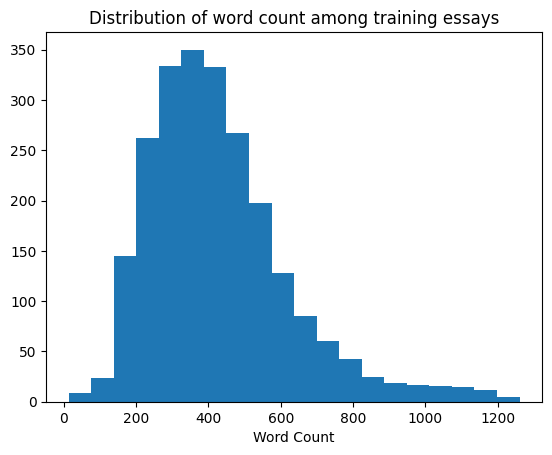

In [ ]:
# visualize the distribution of word count among our essays

lengths = []
for essay in train["full_text"]:
  tokenized = essay.split()
  lengths.append(len(tokenized))

# plot a histogram and add a vertical line add 75% of the data
plt.hist(lengths, bins = 20)
# plt.axvline(x = 518.75, color = "black")
plt.xlabel("Word Count")
plt.title("Distribution of word count among training essays");

In [ ]:
# Take a look at some summary stats of the scores for each potential output, as well as for the word count

train["word_count"] = lengths
train.describe()

cohesion       syntax   vocabulary  phraseology      grammar  \
count  2346.000000  2346.000000  2346.000000  2346.000000  2346.000000   
mean      3.119139     3.021739     3.226556     3.106564     3.033887   
std       0.662408     0.650862     0.601645     0.666550     0.706068   
min       1.000000     1.000000     1.000000     1.000000     1.000000   
25%       2.500000     2.500000     3.000000     2.500000     2.500000   
50%       3.000000     3.000000     3.000000     3.000000     3.000000   
75%       3.500000     3.500000     3.500000     3.500000     3.500000   
max       5.000000     5.000000     5.000000     5.000000     5.000000   

       conventions   word_count  
count  2346.000000  2346.000000  
mean      3.072251   428.993180  
std       0.684742   196.712195  
min       1.000000    14.000000  
25%       2.500000   291.000000  
50%       3.000000   395.000000  
75%       3.500000   521.750000  
max       5.000000  1260.000000

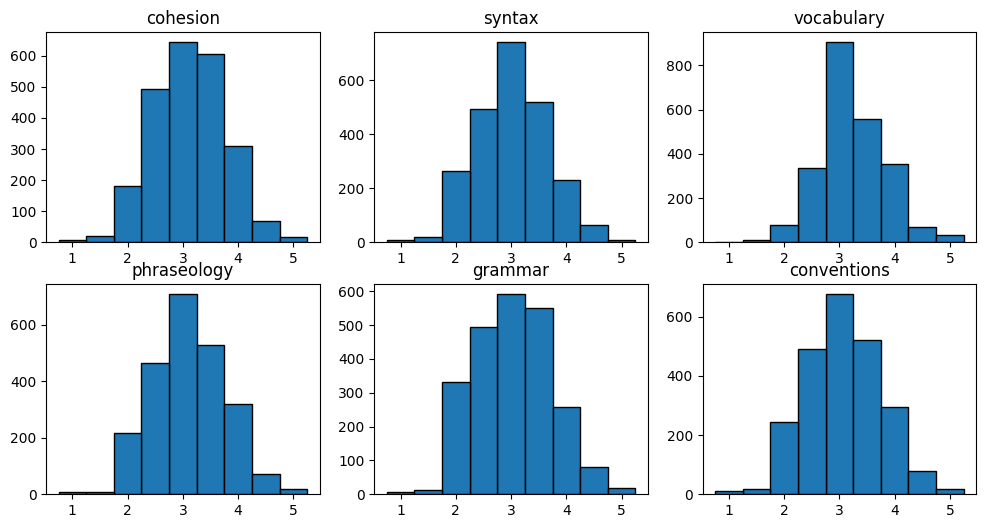

In [ ]:
# full distrubution for each score (training examples only)

target_distributions(train)

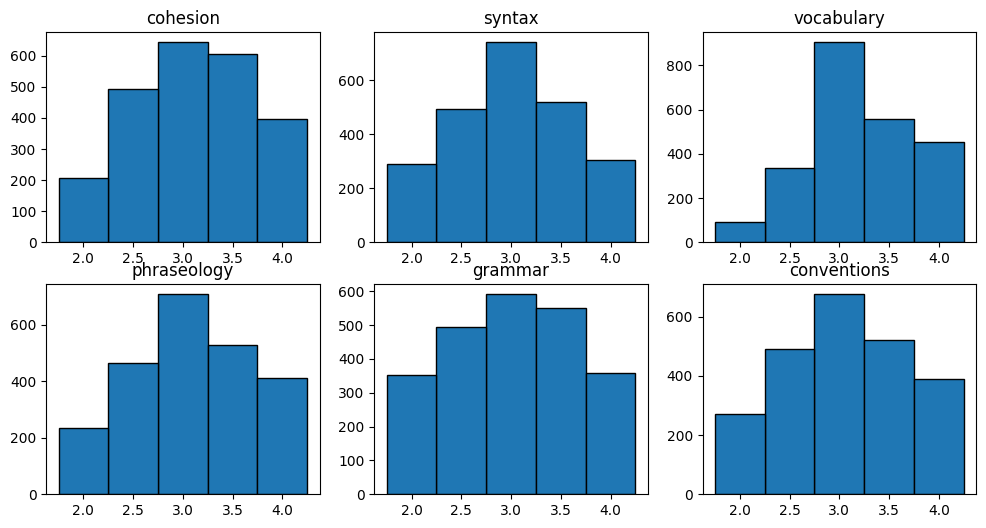

In [ ]:
# alter the target values to lump together values at the edges of the range
df = lump(train)

# visualize the new distribution
target_distributions(df)

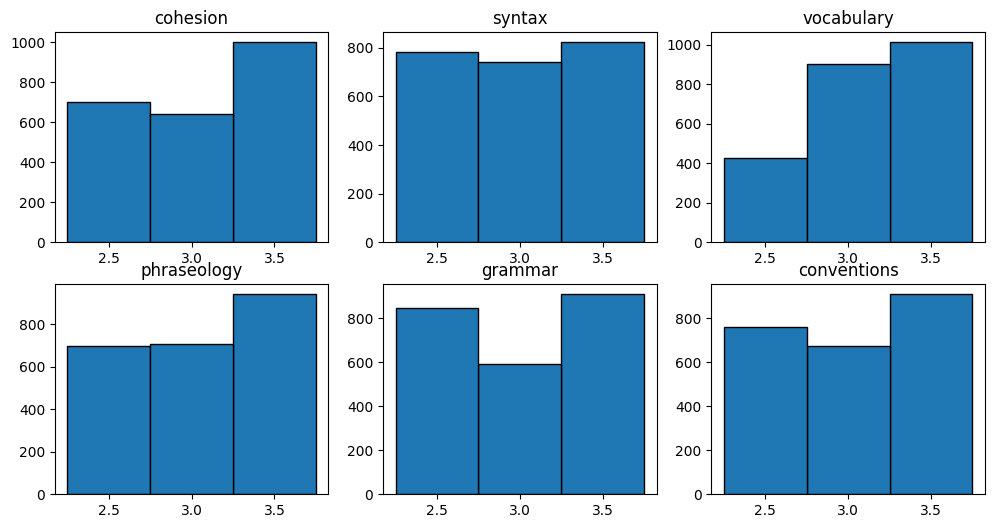

In [ ]:
# alter the target values to lump together values at the edges of the range
df2 = lump(train, [2.5, 3.5])

# visualize the new distribution
target_distributions(df2)

In [ ]:
# # downsample based on the 'syntax' category

# sampling_strategy = {0: 295, 1: 488, 2: 500, 3: 528, 4: 304} # need to change bc we didn't set a seed for thec train_test_split

# rus = imblearn.under_sampling.RandomUnderSampler(sampling_strategy = sampling_strategy, random_state = 11)
# X_resampled, syntax_resampled = rus.fit_resample(X = df.drop(columns = "syntax"), y = (2*df["syntax"] - 4).astype(int))

# syntax_resampled = (syntax_resampled + 4)/2

# df_downsampled = pd.concat([X_resampled, pd.DataFrame(syntax_resampled)], axis = 1)

In [ ]:
# # distribution for data lumped at 2 and 4, then downsampled

# target_distributions(df_downsampled)

Looks like this successfully lopped off the 3's within `syntax`, but it didn't really help for the other categories. So to bring the 3's down for each category would mean throwing away a lot of data

**Let's proceed to use build one model using only 3 categories (ie lumped at 2.5 and 3.5), one model using 5 categories (lumped at at 2 and 4), and one model with all the categories but using class weights.**

[More preprocessing]

In [ ]:
# cut off y at 2 and 4 (9 classes --> 5 classes)

# lump the edges of the target distributions together
train_wide = lump(train)
val_wide = lump(val)
test_wide = lump(test)

# reshape
y_train_wide = [train_wide[col].values.reshape((-1,)) for col in columns]
y_val_wide = [val_wide[col].values.reshape((-1,)) for col in columns]
y_test_wide = [test_wide[col].values.reshape((-1,)) for col in columns]

# transform the new target to start at 0 and increase in increments of 1
y_train_wide = [(2*col - 4).astype(int) for col in y_train_wide]
y_val_wide = [(2*col - 4).astype(int) for col in y_val_wide]
y_test_wide = [(2*col - 4).astype(int) for col in y_test_wide]

In [ ]:
# cut off y at 2.5 and 3.5 (9 classes --> 3 classes)

# lump the edges of the target distributions together
train_narrow = lump(train, bounds = [2.5, 3.5])
val_narrow = lump(val, bounds = [2.5, 3.5])
test_narrow = lump(test, bounds = [2.5, 3.5])

# reshape
y_train_narrow = [train_narrow[col].values.reshape((-1,)) for col in columns]
y_val_narrow = [val_narrow[col].values.reshape((-1,)) for col in columns]
y_test_narrow = [test_narrow[col].values.reshape((-1,)) for col in columns]

# transform the new target to start at 0 and increase in increments of 1
y_train_narrow = [(2*col - 5).astype(int) for col in y_train_narrow]
y_val_narrow = [(2*col - 5).astype(int) for col in y_val_narrow]
y_test_narrow = [(2*col - 5).astype(int) for col in y_test_narrow]

---
### 3c. Baseline <a name='baseline'></a>
[jump to top](#top)<br>

Minimum: 0
Q1 (25th percentile): 3.0
Median (50th percentile): 4.0
Q3 (75th percentile): 5.0
Maximum: 8


<BarContainer object of 9 artists>

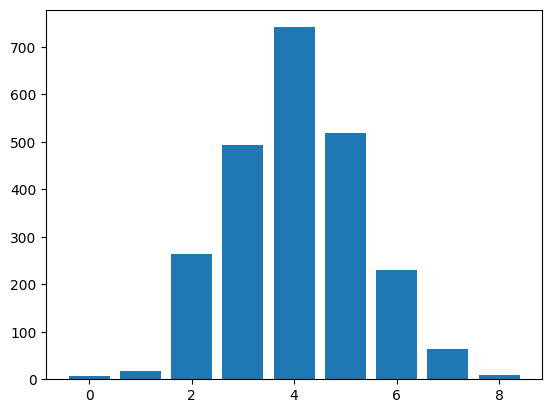

In [ ]:
#understand what the mode of the scores for one category

minimum = np.min(y_train[1])
q1 = np.percentile(y_train[1], 25)
median = np.median(y_train[1])
q3 = np.percentile(y_train[1], 75)
maximum = np.max(y_train[1])

print("Minimum:", minimum)
print("Q1 (25th percentile):", q1)
print("Median (50th percentile):", median)
print("Q3 (75th percentile):", q3)
print("Maximum:", maximum)

unique_values, counts = np.unique(y_train[1], return_counts=True)
plt.bar(unique_values, counts)

Based on the distributions, it is clear that 3 (4 if transformed) is the most common score for all 6 outcomes. We will use 4 as a baseline after the transformation of the y values

In [ ]:
#Baseline prediction by testing against all scores of 4

baseline4_train = [np.full_like(x, 4) for x in y_train]

baseline4_val = [np.full_like(x, 4) for x in y_val]
baseline4_test = [np.full_like(x, 4) for x in y_test]


print(baseline4_train[0].shape)
print(baseline4_train[0])
# Combine the three prediction lists into one list.
base_predictions = [baseline4_train, baseline4_val, baseline4_test]

(2346,)
[4 4 4 ... 4 4 4]


In [ ]:
#Regression Baseline MSE to beat if predicted every score to be 4
train_base, val_base, test_base = get_scores(base_predictions, evaluation_metric="mse")

print("Baseline MSE for training set:  ", train_base)
print("Baseline MSE for validation set:", val_base)
print("Baseline MSE for test set:      ", test_base)

Baseline MSE for training set:   1.8124467178175616
Baseline MSE for validation set: 1.653239556692242
Baseline MSE for test set:       1.7707535121328224


---
### 3d. Modeling <a name='ds1modeling'></a>
[jump to top](#top)<br>

In [ ]:
# read in the cls_token vectors

# training essays
cls_df_train = pd.read_csv("/content/drive/MyDrive/Colab/cls_tokens_train_2.csv").drop(columns=["Unnamed: 0"])
cls_np_train = np.array(cls_df_train)
cls_tensor_train_1 = tf.convert_to_tensor(cls_np_train, dtype="float32") # training input

# validation essays
cls_df_val = pd.read_csv("/content/drive/MyDrive/Colab/cls_tokens_val_2.csv").drop(columns=["Unnamed: 0"])
cls_np_val = np.array(cls_df_val)
cls_tensor_val_1 = tf.convert_to_tensor(cls_np_val, dtype="float32") # validation input

# testing essays
cls_df_test = pd.read_csv("/content/drive/MyDrive/Colab/cls_tokens_test_2.csv").drop(columns=["Unnamed: 0"])
cls_np_test = np.array(cls_df_test)
cls_tensor_test_1 = tf.convert_to_tensor(cls_np_test, dtype="float32") # testing input

In [ ]:
# create hyperparameter table

hyperp_df = pd.DataFrame(columns=['learning_rate', 'loss_function', 'epochs', 'batch_size', 'hidden_size', 'kappa_mse_train', 'kappa_mse_val', 'kappa_mse_test'])
#hyperp_df['batch_size'] = 32
#hyperp_df= hyperp_df.reindex(columns =['learning_rate', 'loss_function', 'epochs', 'batch_size', 'kappa_mse_train', 'kappa_mse_val', 'kappa_mse_test'] )
#hyperp_df

In [ ]:
# comment out this cell if you want to start the hyper parameter table fresh (ie just use the cell above)

#hyperp_df = pd.read_csv("/content/drive/MyDrive/Colab/hyperp_df.csv").drop(columns=["Unnamed: 0"])

In [ ]:
#current hyperp_df

hyperp_df

Empty DataFrame
Columns: [learning_rate, loss_function, epochs, batch_size, hidden_size, kappa_mse_train, kappa_mse_val, kappa_mse_test]
Index: []

#### Categorical Model

Epoch 1/100
74/74 [==============================] - 12s 50ms/step - loss: 58.8275 - cohesion_output_loss: 9.8336 - syntax_output_loss: 9.7423 - vocabulary_output_loss: 9.8331 - phraseology_output_loss: 9.8242 - grammar_output_loss: 9.8051 - conventions_output_loss: 9.7892 - cohesion_output_accuracy: 0.1820 - syntax_output_accuracy: 0.1709 - vocabulary_output_accuracy: 0.2494 - phraseology_output_accuracy: 0.1948 - grammar_output_accuracy: 0.2634 - conventions_output_accuracy: 0.2285 - val_loss: 47.6224 - val_cohesion_output_loss: 8.2222 - val_syntax_output_loss: 9.6338 - val_vocabulary_output_loss: 6.3154 - val_phraseology_output_loss: 7.8870 - val_grammar_output_loss: 8.1653 - val_conventions_output_loss: 7.3986 - val_cohesion_output_accuracy: 0.2775 - val_syntax_output_accuracy: 0.0844 - val_vocabulary_output_accuracy: 0.2877 - val_phraseology_output_accuracy: 0.1726 - val_grammar_output_accuracy: 0.2008 - val_conventions_output_accuracy: 0.2161
Epoch 2/100
74/74 [==================

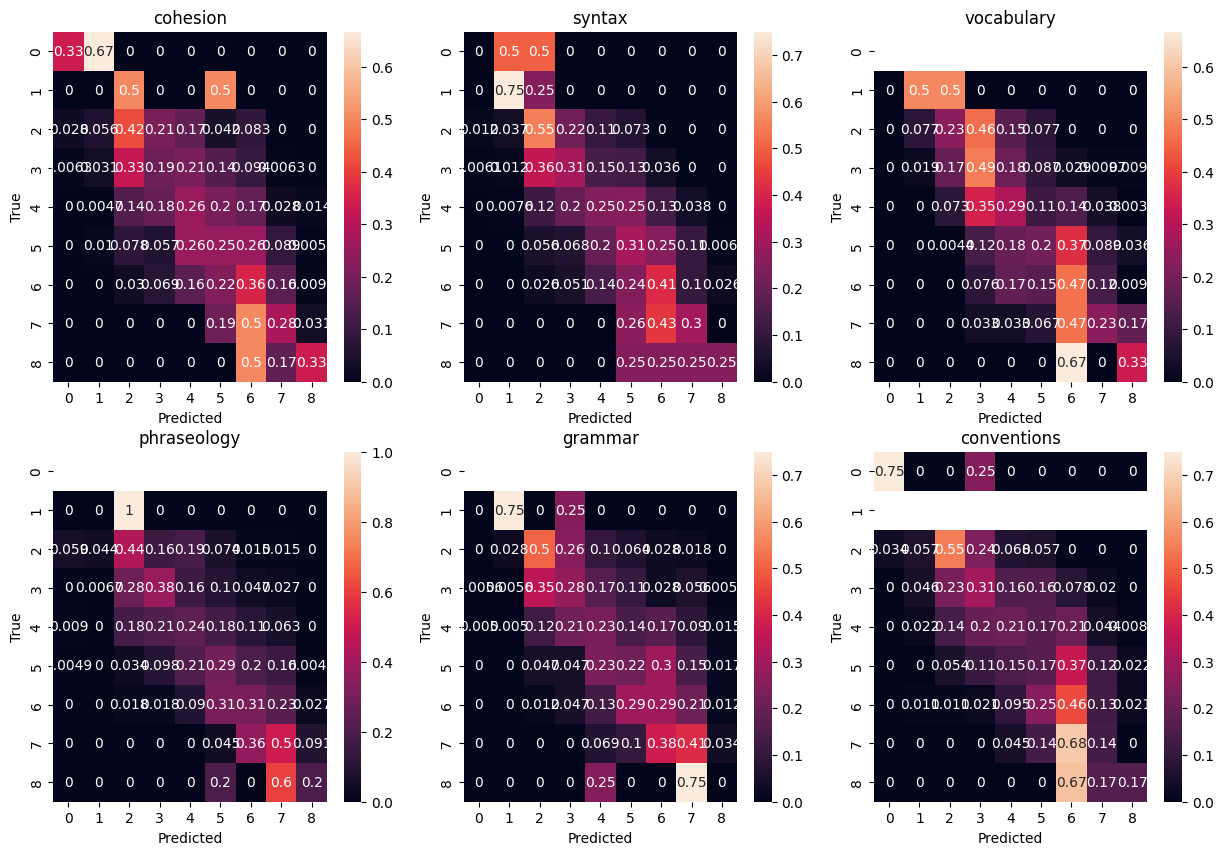

In [ ]:
# this is the highest performing classification model

cat_model = create_train_score_model(learn_rate=0.0005,
                                     loss_function="CategoricalCrossentropy",
                                     num_epochs=100,
                                     batch_size=32,
                                     hidden_size = 512,
                                     fast=True,
                                     show_plots=True,
                                     verbose=1,
                                     evaluation_metric="kappa")

In [ ]:
# # export the model (doing this bc despite the random_state, we're still getting varying results for fixed hyperparameters)

# tf.saved_model.save(cat_model, "/content/drive/MyDrive/Colab/cat_model")

In [ ]:
hyperp_df

learning_rate            loss_function  epochs  batch_size  hidden_size  \
0         0.0005  CategoricalCrossentropy     100          32          512   

   kappa_mse_train  kappa_mse_val  kappa_mse_test  
0         0.716229       0.532859        0.560488

**Error analysis (classification)**

In [ ]:
#get predictions
predictions = get_predictions(cat_model, dataset = 1, fast=True, evaluation_metric="kappa")

25/25 [==============================] - 0s 5ms/step


In [ ]:
preds_test_df = pd.DataFrame(predictions[2]).T
preds_test_df.columns = columns
preds_test_df["average_pred"] = preds_test_df.mean(axis=1)

In [ ]:
ground_truth_test_df = pd.DataFrame(y_test).T
ground_truth_test_df.columns = columns
ground_truth_test_df["average_ground_truth"] = ground_truth_test_df.mean(axis=1)

A few ways to do error analysis:
* Compare pred to truth for each example, for each category
* Compare average of pred to average of truth across categories, for each example

In [ ]:
# this list will hold all the indices of the essays that we want to investigate

indices = []

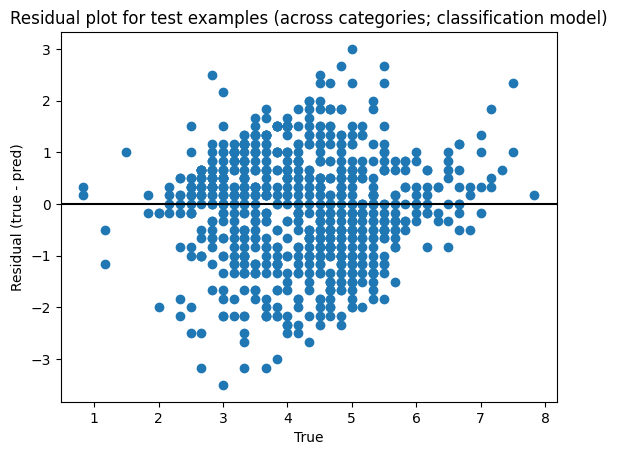

In [ ]:
difference = ground_truth_test_df["average_ground_truth"] - preds_test_df["average_pred"]

plt.scatter(x = ground_truth_test_df["average_ground_truth"], y=difference)
plt.axhline(0, color="black")
plt.title("Residual plot for test examples (across categories; classification model)")
plt.xlabel("True")
plt.ylabel("Residual (true - pred)")
plt.savefig("/content/drive/MyDrive/Colab/images/mod1_classification_residuals.png");

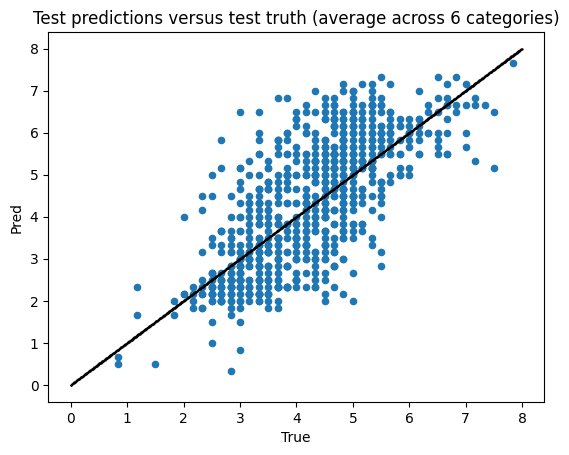

In [ ]:
plt.scatter(x = ground_truth_test_df["average_ground_truth"], y = preds_test_df["average_pred"], s = 20)
plt.scatter(x = np.arange(0, 8, 0.01), y = np.arange(0, 8, 0.01), s = 0.5, c = "black")
plt.xlabel("True")
plt.ylabel("Pred")
plt.title("Test predictions versus test truth (average across 6 categories)");

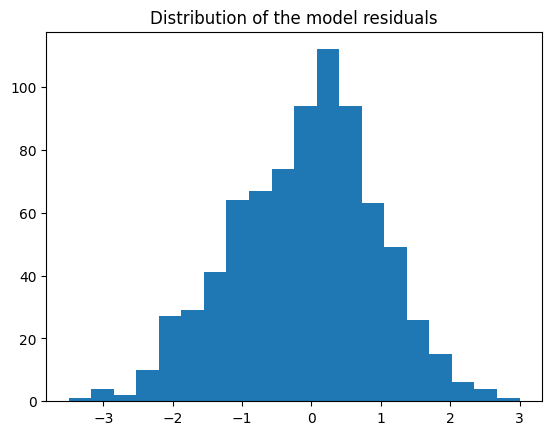

In [ ]:
plt.hist(difference, bins = 20)
plt.title("Distribution of the model residuals");

In [ ]:
# grab one example where the average _prediction_ was much larger than the average _truth_

difference[difference==min(difference)]
indices.append(difference[difference==min(difference)].index[0])

274   -3.5
dtype: float64

In [ ]:
# grab one example where the average _truth_ was much larger than the average _prediction_

difference[difference==max(difference)]
indices.append(difference[difference==max(difference)].index[0])

588    3.0
dtype: float64

In [ ]:
# create a dataframe that allows us to easily inspect the extreme examples identified above

for i,index in enumerate(indices):
  a = pd.DataFrame(test.reset_index().iloc[index:index+1]["full_text"]) # grab the actual essay text
  b = ground_truth_test_df.iloc[index:index+1]                          # grab the ground truth labels for that essay
  c = preds_test_df.iloc[index:index+1]                                 # grab the predictions for that essay
  row = pd.concat([a, b, c], axis=1)
  if i == 0:
    df = row
  else:
    df = pd.concat([df, row], axis=0)

# rename the columns
df.columns = ["essay", "cohesion_true", "syntax_true", "vocabulary_true", "phraseology_true", "grammar_true", "conventions_true", "avg_true",
              "cohesion_pred", "syntax_pred", "vocabulary_pred", "phraseology_pred", "grammar_pred", "conventions_pred", "avg_pred"]

# reorder the columns
df = df[["essay", "avg_true", "avg_pred", "cohesion_true", "cohesion_pred", "syntax_true", "syntax_pred", "vocabulary_true", "vocabulary_pred",
         "phraseology_true", "phraseology_pred", "grammar_true", "grammar_pred", "conventions_true", "conventions_pred"]]

df

essay  avg_true  avg_pred  \
274  I totally agree with Ralph Waldo Emerson , bei...       3.0       6.5   
588  How do people think younger and older students...       5.0       2.0   

     cohesion_true  cohesion_pred  syntax_true  syntax_pred  vocabulary_true  \
274              2              6            4            7                4   
588              5              1            5            2                4   

     vocabulary_pred  phraseology_true  phraseology_pred  grammar_true  \
274                7                 2                 7             3   
588                3                 4                 3             6   

     grammar_pred  conventions_true  conventions_pred  
274             7                 3                 5  
588             2                 6                 1

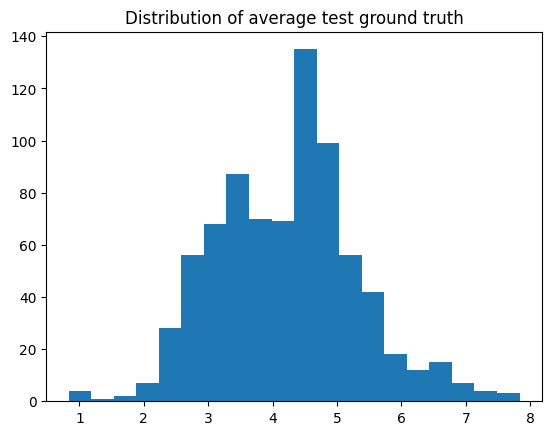

In [ ]:
plt.hist(ground_truth_test_df["average_ground_truth"], bins = 20)
plt.title("Distribution of average test ground truth");

In [ ]:
# read the essays

for index in indices:
  print("True average:     ", '\033[1m' + str(round(df["avg_true"][index], 1)) + '\033[0m')
  print("Predicted average:", '\033[1m' + str(round(df["avg_pred"][index], 1)) + '\033[0m')
  print("")
  print("[TEXT]:")
  print(df["essay"][index])
  print("-"*50)
  print("")

True average:      3.0
Predicted average: 6.5

[TEXT]:
I totally agree with Ralph Waldo Emerson , being yourself around people of these days is complicated in the way that anything you do or you say is going to be judge by everyone , you will be the critique of your classmates,friends,family. Is basically most of the youth community feeling the pressure of being accepted by the society and they forget to be them and they start becoming someone else, just because the other person might have a lot of friends or they want to have the same popularity as them.

70 percent of the youth community either have depression or they get bully in high school. For the people who sees these type of actions and don't say anything because they are unprotected and are scared to be bully, first know that you can get help and you can be that person giving the courage to the other person feeling same as you.

There are multiple reasons why you should want to be yourself and not just a copy. First put in you

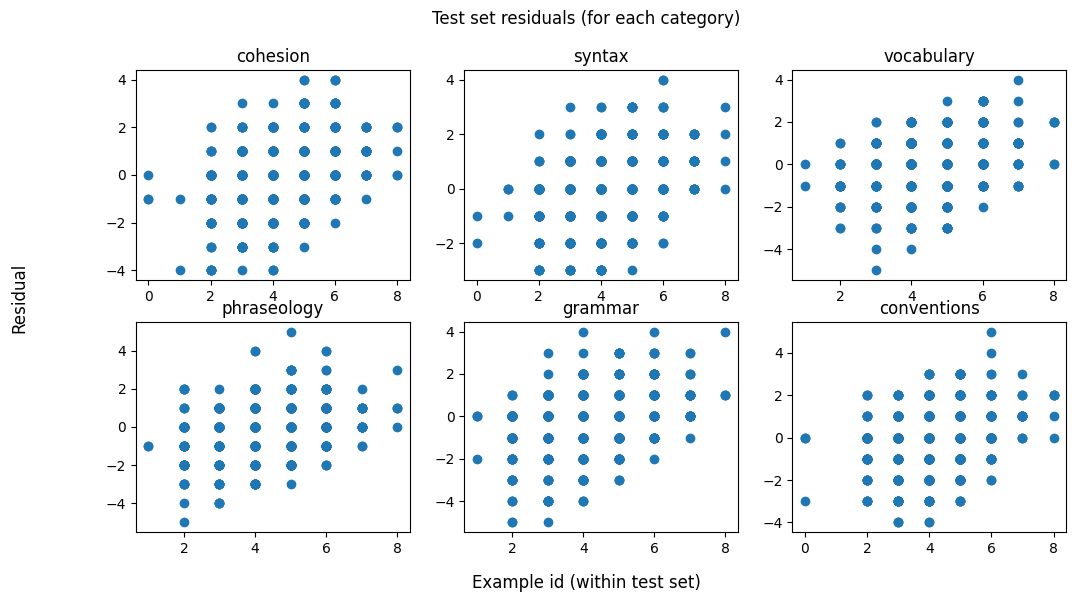

In [ ]:
fig, axs = plt.subplots(nrows = 2,
                        ncols = 3,
                        figsize = (12, 6))

differences = [ground_truth_test_df[col] - preds_test_df[col] for col in columns]

axs[0, 0].scatter(x = ground_truth_test_df[columns[0]], y=differences[0])
axs[0, 0].set_title(columns[0])
axs[0, 1].scatter(x = ground_truth_test_df[columns[1]], y=differences[1])
axs[0, 1].set_title(columns[1])
axs[0, 2].scatter(x = ground_truth_test_df[columns[2]], y=differences[2])
axs[0, 2].set_title(columns[2])
axs[1, 0].scatter(x = ground_truth_test_df[columns[3]], y=differences[3])
axs[1, 0].set_title(columns[3])
axs[1, 1].scatter(x = ground_truth_test_df[columns[4]], y=differences[4])
axs[1, 1].set_title(columns[4])
axs[1, 2].scatter(x = ground_truth_test_df[columns[5]], y=differences[5])
axs[1, 2].set_title(columns[5])
fig.suptitle("Test set residuals (for each category)")
fig.supylabel("Residual")
fig.supxlabel("Example id (within test set)");

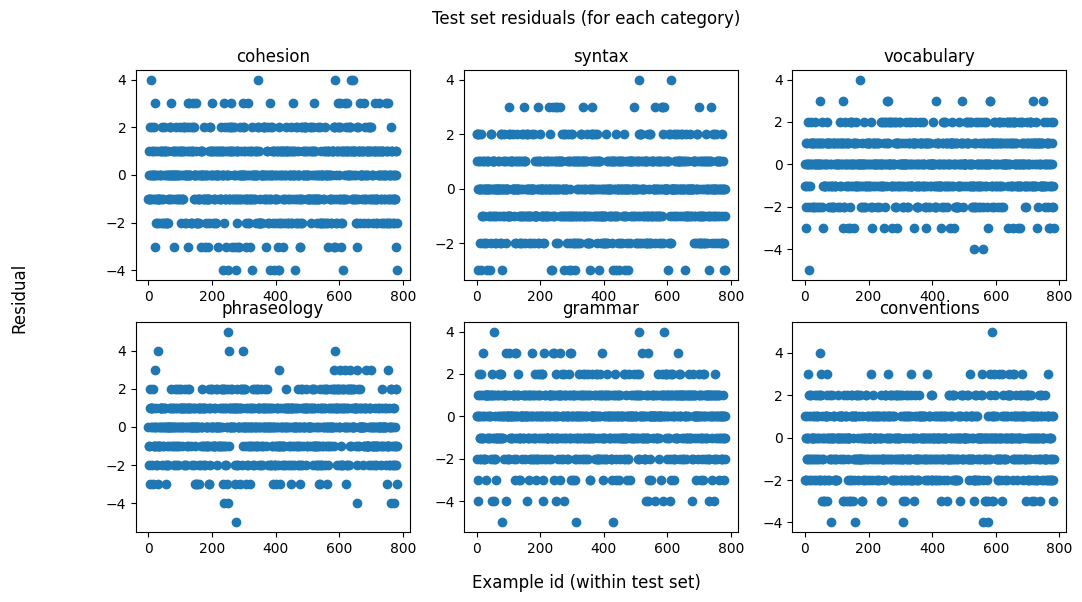

In [ ]:
fig, axs = plt.subplots(nrows = 2,
                        ncols = 3,
                        figsize = (12, 6))

differences = [ground_truth_test_df[col] - preds_test_df[col] for col in columns]

axs[0, 0].scatter(x = ground_truth_test_df.index, y=differences[0])
axs[0, 0].set_title(columns[0])
axs[0, 1].scatter(x = ground_truth_test_df.index, y=differences[1])
axs[0, 1].set_title(columns[1])
axs[0, 2].scatter(x = ground_truth_test_df.index, y=differences[2])
axs[0, 2].set_title(columns[2])
axs[1, 0].scatter(x = ground_truth_test_df.index, y=differences[3])
axs[1, 0].set_title(columns[3])
axs[1, 1].scatter(x = ground_truth_test_df.index, y=differences[4])
axs[1, 1].set_title(columns[4])
axs[1, 2].scatter(x = ground_truth_test_df.index, y=differences[5])
axs[1, 2].set_title(columns[5])
fig.suptitle("Test set residuals (for each category)")
fig.supylabel("Residual")
fig.supxlabel("Example id (within test set)");

We now can see the residual plots for the average and for each of the categories individually. The next step will be to identify a few of these examples to inspect, then figure out how to find the associated essay, as well as the label and predicted value that lead to such a large residual.

In the next few cells, we're going to inspect extreme values for **grammar** (ie differences[4]). But we could easily look at any of the other categories as well

In [ ]:
# take a look at grammar, because I think it will be the easiest for me to evaluate like a grader

indices = []

In [ ]:
# where were our prediction for grammar too small?

differences[4][differences[4]==max(differences[4])]
indices.append(differences[4][differences[4]==max(differences[4])].index[0])

55     4
510    4
588    4
Name: grammar, dtype: int64

In [ ]:
# where were our prediction for grammar too large?

differences[4][differences[4]==min(differences[4])]
indices.append(differences[4][differences[4]==min(differences[4])].index[0])

81    -5
311   -5
429   -5
Name: grammar, dtype: int64

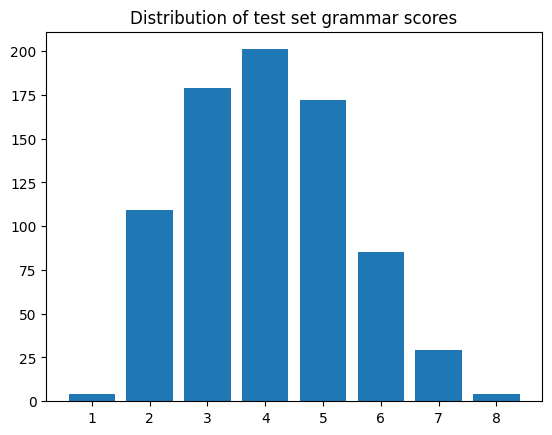

In [ ]:
plt.bar(x= ground_truth_test_df["grammar"].value_counts().index, height=ground_truth_test_df["grammar"].value_counts().values)
plt.title("Distribution of test set grammar scores");

In [ ]:
# create a dataframe that allows us to easily inspect the extreme examples identified above

for i,index in enumerate(indices):
  a = pd.DataFrame(test.reset_index().iloc[index:index+1]["full_text"]) # grab the actual essay text
  b = ground_truth_test_df.iloc[index:index+1]                          # grab the ground truth labels for that essay
  c = preds_test_df.iloc[index:index+1]                                 # grab the predictions for that essay
  row = pd.concat([a, b, c], axis=1)
  if i == 0:
    df = row
  else:
    df = pd.concat([df, row], axis=0)

# rename the columns
df.columns = ["essay", "cohesion_true", "syntax_true", "vocabulary_true", "phraseology_true", "grammar_true", "conventions_true", "avg_true",
              "cohesion_pred", "syntax_pred", "vocabulary_pred", "phraseology_pred", "grammar_pred", "conventions_pred", "avg_pred"]

# reorder the columns
df = df[["essay", "avg_true", "avg_pred", "cohesion_true", "cohesion_pred", "syntax_true", "syntax_pred", "vocabulary_true", "vocabulary_pred",
         "phraseology_true", "phraseology_pred", "grammar_true", "grammar_pred", "conventions_true", "conventions_pred"]]

# read the essays
for index in indices:
  print("True grammar:     ", '\033[1m' + str(round(df["grammar_true"][index], 1)) + '\033[0m')
  print("Predicted grammar:", '\033[1m' + str(round(df["grammar_pred"][index], 1)) + '\033[0m')
  print("")
  print("[TEXT]:")
  print(df["essay"][index])
  print("-"*50)
  print("")

True grammar:      4
Predicted grammar: 0

[TEXT]:
its aboute the plans of the half day i agree because they are planing the activities for the students so they can have have a fun day backgrown:what the teachers have to do to make there class fun for the students

Thesis:the have hours so the students go home early and they can do their homework or the classwork if they did not finish evidence:some teachers agree because they thing that they can go home get rest they can study more elaboration:but the thing is that that some people disagree because they do not want the students in home early but i thing that they shot not make the same thing each day because the part evidence:i thing that if they do DAT

some people are going to be like i disagree because the kids they are not to elaboration :i thing this is a way so the school can have like more time to prepare for the other day the school is like going to be the important thing for the kids so they can have more education and more p

#### Regression Model

Epoch 1/200
19/19 [==============================] - 4s 44ms/step - loss: 112.7016 - cohesion_output_loss: 13.7007 - syntax_output_loss: 15.4703 - vocabulary_output_loss: 19.3129 - phraseology_output_loss: 16.9448 - grammar_output_loss: 22.9402 - conventions_output_loss: 24.3326 - cohesion_output_mse: 13.7007 - syntax_output_mse: 15.4703 - vocabulary_output_mse: 19.3129 - phraseology_output_mse: 16.9448 - grammar_output_mse: 22.9402 - conventions_output_mse: 24.3326 - val_loss: 102.7823 - val_cohesion_output_loss: 12.7609 - val_syntax_output_loss: 13.9337 - val_vocabulary_output_loss: 17.6922 - val_phraseology_output_loss: 15.8293 - val_grammar_output_loss: 20.6103 - val_conventions_output_loss: 21.9559 - val_cohesion_output_mse: 12.7609 - val_syntax_output_mse: 13.9337 - val_vocabulary_output_mse: 17.6922 - val_phraseology_output_mse: 15.8293 - val_grammar_output_mse: 20.6103 - val_conventions_output_mse: 21.9559
Epoch 2/200
19/19 [==============================] - 0s 15ms/step - loss

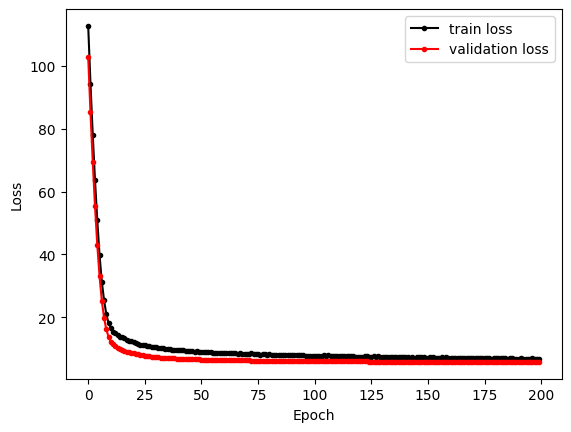

Final train loss: 6.792858123779297
Final validation loss: 5.815108299255371


In [ ]:
# this is the highest performing regression model

reg_model = create_train_score_model(learn_rate=0.00002,
                                     loss_function="Regression",
                                     num_epochs=200,
                                     batch_size = 128,
                                     hidden_size = 256,
                                     show_plots=True,
                                     verbose=1,
                                     evaluation_metric = "mse")

In [ ]:
hyperp_df

learning_rate            loss_function  epochs  batch_size  hidden_size  \
0        0.00050  CategoricalCrossentropy     100          32          512   
1        0.00002               Regression     200         128          256   
2        0.00002               Regression     200         128          256   
3        0.00002               Regression     200         128          256   

   kappa_mse_train  kappa_mse_val  kappa_mse_test  
0         0.716229       0.532859        0.560488  
1         0.889018       0.977935        0.979141  
2         0.888800       0.969185        0.972004  
3         0.882235       0.968770        0.973475

In [ ]:
# # DANGER: only use if you need to delete last row in case you made a mistake with training
#hyperp_df = delete_row(hyperp_df)
# hyperp_df

In [ ]:
# # DANGER: only uncomment this cell if you want to CHANGE the currently saved version of hyperp_df.csv
# # uncomment to write the current hyper parameter table to a csv file

#hyperp_df.to_csv("/content/drive/MyDrive/Colab/hyperp_df.csv")

In [ ]:
# hyperp_df.to_csv("/content/drive/MyDrive/Colab/hyperp_df_regressiononly.csv")

**Error analysis (regression)**

In [ ]:
predictions = get_predictions(reg_model, dataset = 1, fast=True, evaluation_metric="mse")

25/25 [==============================] - 0s 2ms/step


In [ ]:
preds_test_df = pd.DataFrame()

for i in range(6):
  old = predictions[2][i]
  new = np.reshape(old, (783,))
  preds_test_df[columns[i]] = new
preds_test_df["average_pred"] = preds_test_df.mean(axis=1)

In [ ]:
ground_truth_test_df = pd.DataFrame(y_test).T
ground_truth_test_df.columns = columns
ground_truth_test_df["average_ground_truth"] = ground_truth_test_df.mean(axis=1)

In [ ]:
# this list will hold all the indices of the essays that we want to investigate

indices = []

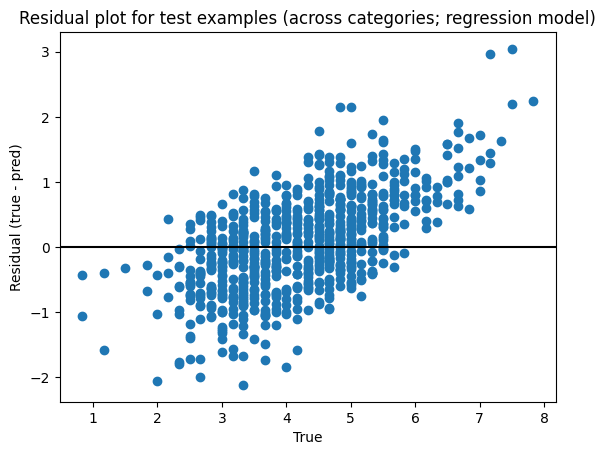

In [ ]:
difference = ground_truth_test_df["average_ground_truth"] - preds_test_df["average_pred"]

plt.scatter(x = ground_truth_test_df["average_ground_truth"], y=difference)
plt.axhline(0, color="black")
plt.title("Residual plot for test examples (across categories; regression model)")
plt.xlabel("True")
plt.ylabel("Residual (true - pred)")
plt.savefig("/content/drive/MyDrive/Colab/images/mod1_regression_residuals.png");

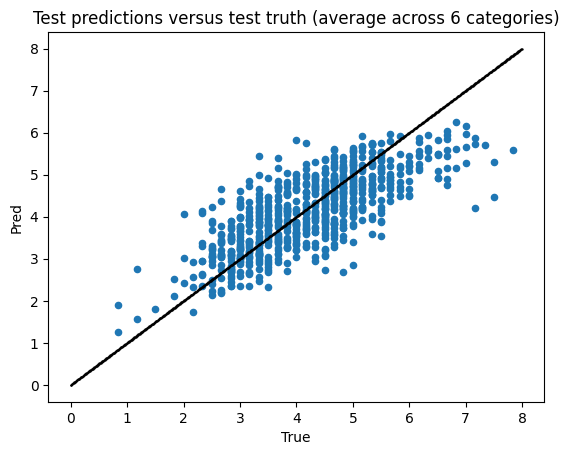

In [ ]:
plt.scatter(x = ground_truth_test_df["average_ground_truth"], y = preds_test_df["average_pred"], s = 20)
plt.scatter(x = np.arange(0, 8, 0.01), y = np.arange(0, 8, 0.01), s = 0.5, c = "black")
plt.xlabel("True")
plt.ylabel("Pred")
plt.title("Test predictions versus test truth (average across 6 categories)");

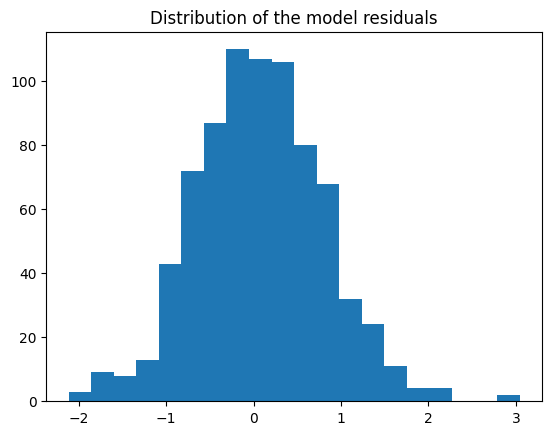

In [ ]:
plt.hist(difference, bins = 20)
plt.title("Distribution of the model residuals");

In [ ]:
# grab one example where the average _prediction_ was much larger than the average _truth_

difference[difference==min(difference)]
indices.append(difference[difference==min(difference)].index[0])

695   -2.298637
dtype: float64

In [ ]:
# grab one example where the average _truth_ was much larger than the average _prediction_

difference[difference==max(difference)]
indices.append(difference[difference==max(difference)].index[0])

583    2.87261
dtype: float64

In [ ]:
# create a dataframe that allows us to easily inspect the extreme examples identified above

for i,index in enumerate(indices):
  a = pd.DataFrame(test.reset_index().iloc[index:index+1]["full_text"]) # grab the actual essay text
  b = ground_truth_test_df.iloc[index:index+1]                          # grab the ground truth labels for that essay
  c = preds_test_df.iloc[index:index+1]                                 # grab the predictions for that essay
  row = pd.concat([a, b, c], axis=1)
  if i == 0:
    df = row
  else:
    df = pd.concat([df, row], axis=0)

# rename the columns
df.columns = ["essay", "cohesion_true", "syntax_true", "vocabulary_true", "phraseology_true", "grammar_true", "conventions_true", "avg_true",
              "cohesion_pred", "syntax_pred", "vocabulary_pred", "phraseology_pred", "grammar_pred", "conventions_pred", "avg_pred"]

# reorder the columns
df = df[["essay", "avg_true", "avg_pred", "cohesion_true", "cohesion_pred", "syntax_true", "syntax_pred", "vocabulary_true", "vocabulary_pred",
         "phraseology_true", "phraseology_pred", "grammar_true", "grammar_pred", "conventions_true", "conventions_pred"]]

df

essay  avg_true  avg_pred  \
695  Dear, Mrs. Generic_Name\n\nMy opinon is that i...       2.0  4.298637   
583  If you could visit one place in the world wher...       7.5  4.627390   

     cohesion_true  cohesion_pred  syntax_true  syntax_pred  vocabulary_true  \
695              2       4.406270            2     4.189861                2   
583              7       4.789927            8     4.316544                7   

     vocabulary_pred  phraseology_true  phraseology_pred  grammar_true  \
695         4.682755                 2          4.044627             2   
583         4.644968                 8          4.598365             7   

     grammar_pred  conventions_true  conventions_pred  
695      4.265395                 2          4.202916  
583      4.719378                 8          4.695160

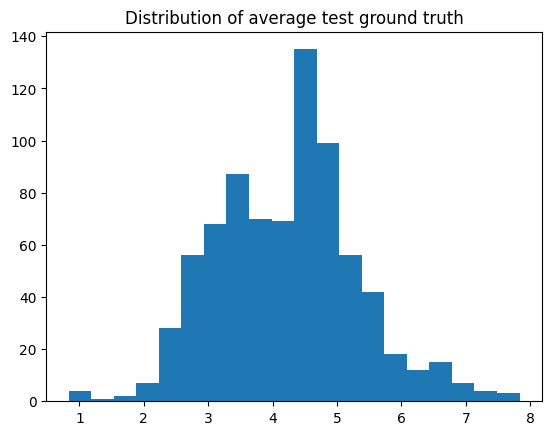

In [ ]:
plt.hist(ground_truth_test_df["average_ground_truth"], bins = 20)
plt.title("Distribution of average test ground truth");

In [ ]:
# read the essays

for index in indices:
  print("True average:     ", '\033[1m' + str(round(df["avg_true"][index], 1)) + '\033[0m')
  print("Predicted average:", '\033[1m' + str(round(df["avg_pred"][index], 1)) + '\033[0m')
  print("")
  print("[TEXT]:")
  print(df["essay"][index])
  print("-"*50)
  print("")

True average:      2.0
Predicted average: 4.3

[TEXT]:
Dear, Mrs. Generic_Name

My opinon is that i'm disagree with this policy of students are expected to identify a career by the time they enter high school. I don't think isn't good idea for students to commit to a career at young age.

It has come to my attention that some societies, students are expected to identify a career by the time enter high school. Their courses of study in high school are selected to guide them toward a specific career and my position on this issue is properly to not makes that they aren't allowed to indentify a career at a young age from selected to guide them toward a specific career because for all of those who has a career and is because their are worked hard to arrive from they are and they get to propose.

Currently they can't have a commit to a career at young age, because for that has to be prepared and work hard nobody can has a commit to a career at young age.

for that you need to finish high sch

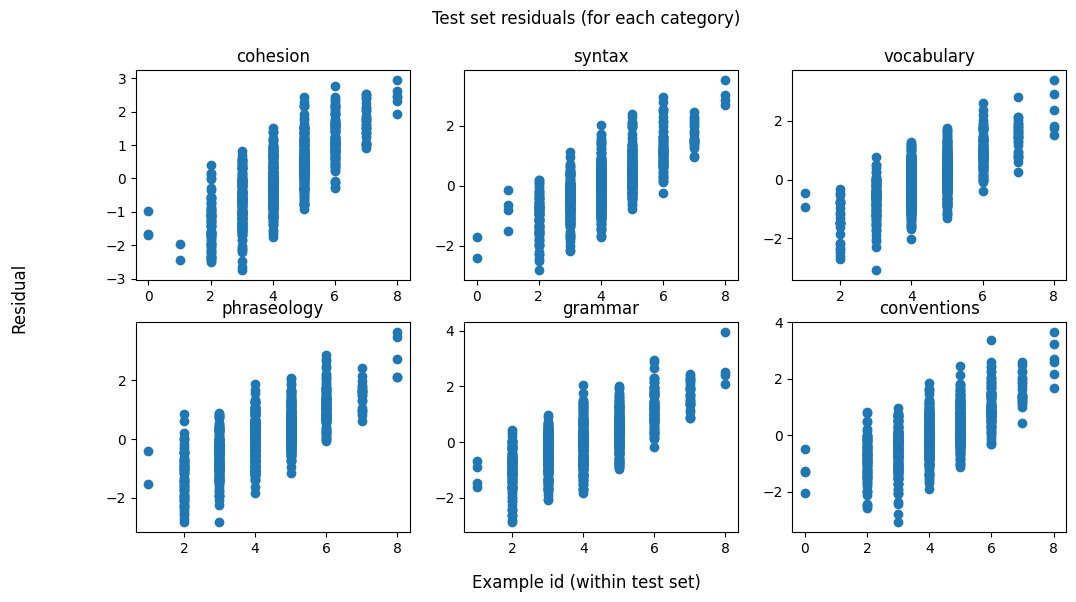

In [ ]:
fig, axs = plt.subplots(nrows = 2,
                        ncols = 3,
                        figsize = (12, 6))

differences = [ground_truth_test_df[col] - preds_test_df[col] for col in columns]

axs[0, 0].scatter(x = ground_truth_test_df[columns[0]], y=differences[0])
axs[0, 0].set_title(columns[0])
axs[0, 1].scatter(x = ground_truth_test_df[columns[1]], y=differences[1])
axs[0, 1].set_title(columns[1])
axs[0, 2].scatter(x = ground_truth_test_df[columns[2]], y=differences[2])
axs[0, 2].set_title(columns[2])
axs[1, 0].scatter(x = ground_truth_test_df[columns[3]], y=differences[3])
axs[1, 0].set_title(columns[3])
axs[1, 1].scatter(x = ground_truth_test_df[columns[4]], y=differences[4])
axs[1, 1].set_title(columns[4])
axs[1, 2].scatter(x = ground_truth_test_df[columns[5]], y=differences[5])
axs[1, 2].set_title(columns[5])
fig.suptitle("Test set residuals (for each category)")
fig.supylabel("Residual")
fig.supxlabel("Example id (within test set)");

We now can see the residual plots for the average and for each of the categories individually. The next step will be to identify a few of these examples to inspect, then figure out how to find the associated essay, as well as the label and predicted value that lead to such a large residual.

In the next few cells, we're going to inspect extreme values for **grammar** (ie differences[4]). But we could easily look at any of the other categories as well

In [ ]:
# take a look at grammar, because I think it will be the easiest for me to evaluate like a grader

indices = []

In [ ]:
# where were our prediction for grammar too small?

differences[4][differences[4]==max(differences[4])]
indices.append(differences[4][differences[4]==max(differences[4])].index[0])

510    3.841274
Name: grammar, dtype: float64

In [ ]:
# where were our prediction for grammar too large?

differences[4][differences[4]==min(differences[4])]
indices.append(differences[4][differences[4]==min(differences[4])].index[0])

81   -2.868855
Name: grammar, dtype: float64

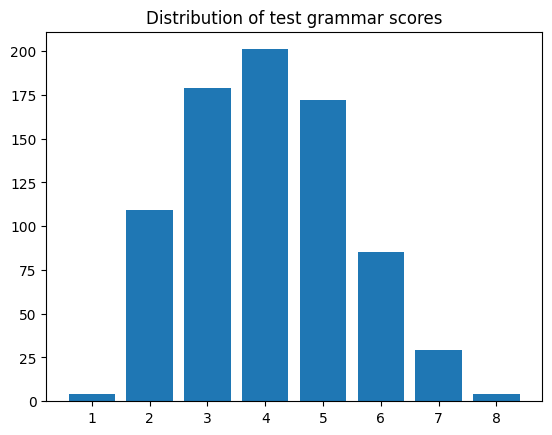

In [ ]:
plt.bar(x= ground_truth_test_df["grammar"].value_counts().index, height=ground_truth_test_df["grammar"].value_counts().values)
plt.title("Distribution of test grammar scores");

In [ ]:
# read the essays

for i,index in enumerate(indices):
  a = pd.DataFrame(test.reset_index().iloc[index:index+1]["full_text"]) # grab the actual essay text
  b = ground_truth_test_df.iloc[index:index+1]                          # grab the ground truth labels for that essay
  c = preds_test_df.iloc[index:index+1]                                 # grab the predictions for that essay
  row = pd.concat([a, b, c], axis=1)
  if i == 0:
    df = row
  else:
    df = pd.concat([df, row], axis=0)

# rename the columns
df.columns = ["essay", "cohesion_true", "syntax_true", "vocabulary_true", "phraseology_true", "grammar_true", "conventions_true", "avg_true",
              "cohesion_pred", "syntax_pred", "vocabulary_pred", "phraseology_pred", "grammar_pred", "conventions_pred", "avg_pred"]

# reorder the columns
df = df[["essay", "avg_true", "avg_pred", "cohesion_true", "cohesion_pred", "syntax_true", "syntax_pred", "vocabulary_true", "vocabulary_pred",
         "phraseology_true", "phraseology_pred", "grammar_true", "grammar_pred", "conventions_true", "conventions_pred"]]

# read the essays
for index in indices:
  print("True grammar:     ", '\033[1m' + str(round(df["grammar_true"][index], 1)) + '\033[0m')
  print("Predicted grammar:", '\033[1m' + str(round(df["grammar_pred"][index], 1)) + '\033[0m')
  print("")
  print("[TEXT]:")
  print(df["essay"][index])
  print("-"*50)
  print("")

True grammar:      8
Predicted grammar: 4.2

[TEXT]:
I agree with this statement, because a positive attitude helps you cope more easily with the daily affairs of life. It brings optimism into your life, and makes it easier to avoid worries and negative thinking. If you adopt it as a way of your life, it would bring constructive changes into your life, and makes them happier, brighter and more succesful.

Whith a positive attitude you see the bring side of life, become optimistic and expect the best to happen. It is certainly a state of mind that is well worth developing.

Also a positive attitude leads to happiness and sucess and can change your whole life. If you look at the bright side of life, your whole life becomes filled with light. This light affects not only you and the way you look at the world, but it also affects your enviroment and the people around you.

If this attitude is strong enough, it becomes contagious. I'ts as if you radiate light around you.

When you are positi

#### Retrain BERT embeddings

retrain layers:  ['_11', '_10', '_9']
Epoch 1/10


74/74 [==============================] - 241s 3s/step - loss: 58.2783 - cohesion_output_loss: 9.7078 - syntax_output_loss: 9.7494 - vocabulary_output_loss: 9.7339 - phraseology_output_loss: 9.7303 - grammar_output_loss: 9.6751 - conventions_output_loss: 9.6817 - cohesion_output_accuracy: 0.1522 - syntax_output_accuracy: 0.2033 - vocabulary_output_accuracy: 0.2336 - phraseology_output_accuracy: 0.1714 - grammar_output_accuracy: 0.2012 - conventions_output_accuracy: 0.2455 - val_loss: 47.2470 - val_cohesion_output_loss: 8.1096 - val_syntax_output_loss: 9.3693 - val_vocabulary_output_loss: 6.4716 - val_phraseology_output_loss: 7.9575 - val_grammar_output_loss: 7.9583 - val_conventions_output_loss: 7.3807 - val_cohesion_output_accuracy: 0.1164 - val_syntax_output_accuracy: 0.2020 - val_vocabulary_output_accuracy: 0.2187 - val_phraseology_output_accuracy: 0.1701 - val_grammar_output_accuracy: 0.1829 - val_conventions_output_accuracy: 0.2558
Epoch 2/10
74/74 [==============================] 

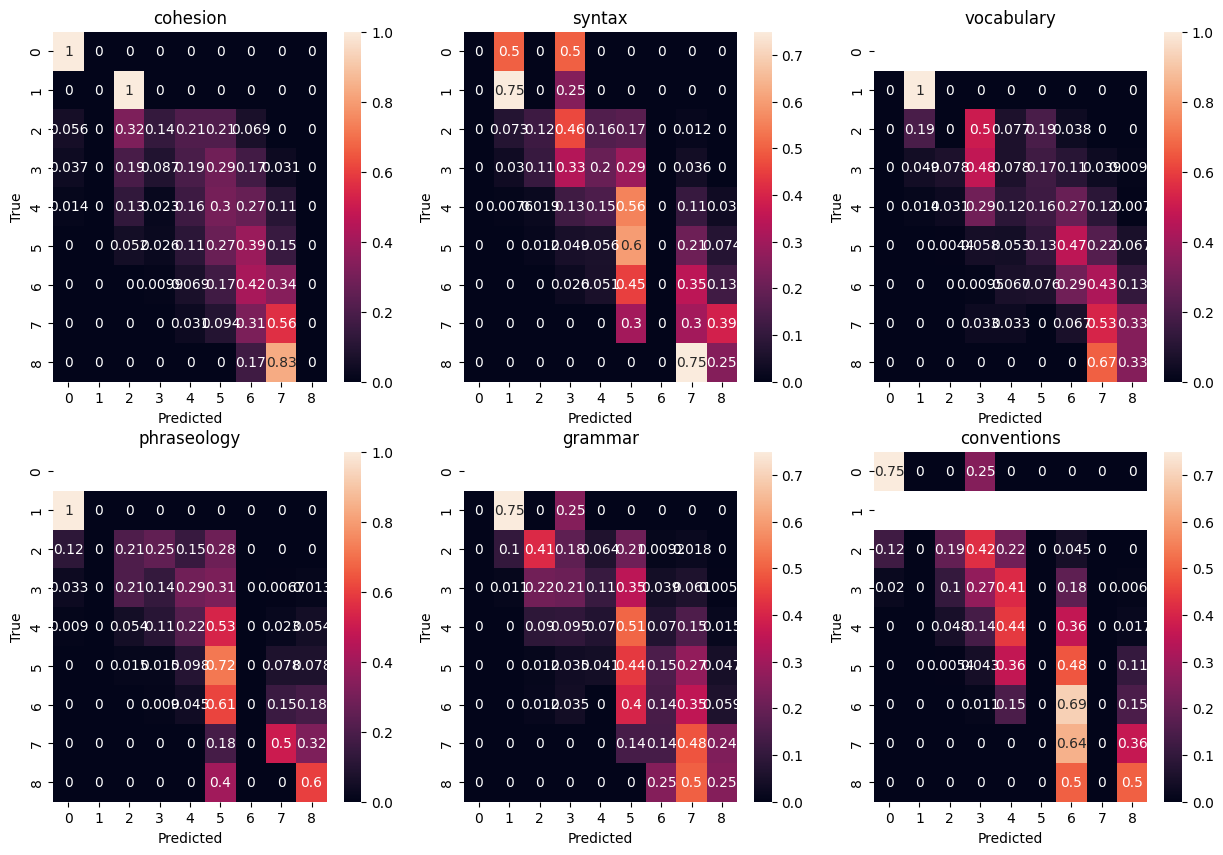

In [ ]:
# set fast=False (for a classification model) to retrain the BERT layers

long_cat_model = create_train_score_model(learn_rate=0.00005,
                                          loss_function="CategoricalCrossentropy",
                                          num_epochs=10,
                                          batch_size=32,
                                          hidden_size=512,
                                          num_train_layers=3, # only relevant because we're setting fast=False below
                                          fast=False,         # this argument makes us use the king_model()
                                          show_plots=True,
                                          verbose=1,
                                          evaluation_metric="kappa")

In [ ]:
long_cat_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 600)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 600)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 600)]       0           []                               
 er)                                                                                              
                                                                                              

In [ ]:
hyperp_df

learning_rate            loss_function  epochs  batch_size  hidden_size  \
0        0.00050  CategoricalCrossentropy       2          32          512   
1        0.00005  CategoricalCrossentropy      10          32          512   

   kappa_mse_train  kappa_mse_val  kappa_mse_test  
0         0.480603       0.423717        0.478605  
1         0.560981       0.488343        0.523058

retrain layers:  ['_11', '_10']
Epoch 1/10


74/74 [==============================] - 263s 3s/step - loss: 35.0347 - cohesion_output_loss: 6.8988 - syntax_output_loss: 5.9581 - vocabulary_output_loss: 5.0705 - phraseology_output_loss: 4.8896 - grammar_output_loss: 4.5060 - conventions_output_loss: 7.7117 - cohesion_output_mse: 6.8988 - syntax_output_mse: 5.9581 - vocabulary_output_mse: 5.0705 - phraseology_output_mse: 4.8896 - grammar_output_mse: 4.5060 - conventions_output_mse: 7.7117 - val_loss: 8.0441 - val_cohesion_output_loss: 1.5091 - val_syntax_output_loss: 1.2811 - val_vocabulary_output_loss: 1.0791 - val_phraseology_output_loss: 1.2859 - val_grammar_output_loss: 1.6174 - val_conventions_output_loss: 1.2716 - val_cohesion_output_mse: 1.5091 - val_syntax_output_mse: 1.2811 - val_vocabulary_output_mse: 1.0791 - val_phraseology_output_mse: 1.2859 - val_grammar_output_mse: 1.6174 - val_conventions_output_mse: 1.2716
Epoch 2/10
74/74 [==============================] - 198s 3s/step - loss: 11.1209 - cohesion_output_loss: 1.9407

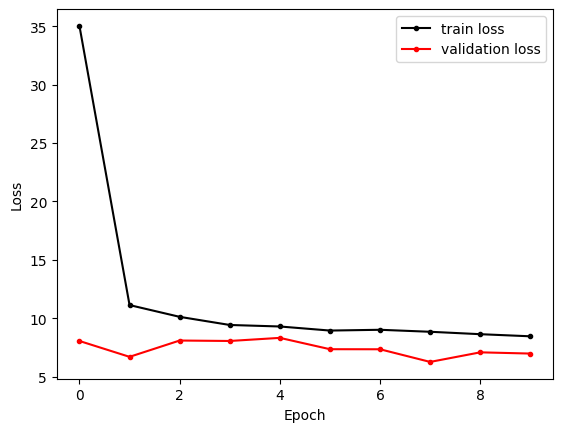

Final train loss: 8.445497512817383
Final validation loss: 6.966829299926758


In [ ]:
# set fast=False (for a regression model) to retrain the BERT layers

long_reg_model = create_train_score_model(learn_rate=0.00002,
                                          loss_function="Regression",
                                          num_epochs=10,
                                          batch_size=32,
                                          hidden_size=256,
                                          num_train_layers=2,
                                          fast=False,
                                          show_plots=True,
                                          verbose=1,
                                          evaluation_metric="mse")

In [ ]:
hyperp_df

learning_rate            loss_function  epochs  batch_size  hidden_size  \
0        0.00050  CategoricalCrossentropy       2          32          512   
1        0.00005  CategoricalCrossentropy      10          32          512   
2        0.00002               Regression      10          32          256   

   kappa_mse_train  kappa_mse_val  kappa_mse_test  
0         0.480603       0.423717        0.478605  
1         0.560981       0.488343        0.523058  
2        19.359477      19.581628       19.492337

---
## 4. Model 2 dataset (original dataset) <a name='ds2'></a>
[jump to top](#top)<br>

In [ ]:
# File path to the dataset
file_path = '/content/drive/MyDrive/Colab/training_set_rel3.xlsx'

# Read the dataset into a Pandas DataFrame

train = pd.read_excel(file_path)
print(train.shape)
train.head()

(12978, 28)


essay_id  essay_set                                              essay  \
0         1          1  Dear local newspaper, I think effects computer...   
1         2          1  Dear @CAPS1 @CAPS2, I believe that using compu...   
2         3          1  Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...   
3         4          1  Dear Local Newspaper, @CAPS1 I have found that...   
4         5          1  Dear @LOCATION1, I know having computers has a...   

   rater1_domain1  rater2_domain1  rater3_domain1  domain1_score  \
0             4.0             4.0             NaN            8.0   
1             5.0             4.0             NaN            9.0   
2             4.0             3.0             NaN            7.0   
3             5.0             5.0             NaN           10.0   
4             4.0             4.0             NaN            8.0   

   rater1_domain2  rater2_domain2  domain2_score  rater1_trait1  \
0             NaN             NaN            NaN            NaN   
1             NaN             NaN            NaN            NaN   
2             NaN             NaN            NaN            NaN   
3             NaN             NaN            NaN            NaN   
4             NaN             NaN            NaN            NaN   

   rater1_trait2  rater1_trait3  rater1_trait4  rater1_trait5  rater1_trait6  \
0            NaN            NaN            NaN            NaN            NaN   
1            NaN            NaN            NaN            NaN            NaN   
2            NaN            NaN            NaN            NaN            NaN   
3            NaN            NaN            NaN            NaN            NaN   
4            NaN            NaN            NaN            NaN            NaN   

   rater2_trait1  rater2_trait2  rater2_trait3  rater2_trait4  rater2_trait5  \
0            NaN            NaN            NaN            NaN            NaN   
1            NaN            NaN            NaN            NaN            NaN   
2            NaN            NaN            NaN            NaN            NaN   
3            NaN            NaN            NaN            NaN            NaN   
4            NaN            NaN            NaN            NaN            NaN   

   rater2_trait6  rater3_trait1  rater3_trait2  rater3_trait3  rater3_trait4  \
0            NaN            NaN            NaN            NaN            NaN   
1            NaN            NaN            NaN            NaN            NaN   
2            NaN            NaN            NaN            NaN            NaN   
3            NaN            NaN            NaN            NaN            NaN   
4            NaN            NaN            NaN            NaN            NaN   

   rater3_trait5  rater3_trait6  
0            NaN            NaN  
1            NaN            NaN  
2            NaN            NaN  
3            NaN            NaN  
4            NaN            NaN

---
### 4a. Preprocessing <a name='ds2preprocess'></a>
[jump to top](#top)<br>

In [ ]:
#take a look at a Hewlett essay
train.iloc[1, ]['essay']

"Dear @CAPS1 @CAPS2, I believe that using computers will benefit us in many ways like talking and becoming friends will others through websites like facebook and mysace. Using computers can help us find coordibates, locations, and able ourselfs to millions of information. Also computers will benefit us by helping with jobs as in planning a house plan and typing a @NUM1 page report for one of our jobs in less than writing it. Now lets go into the wonder world of technology. Using a computer will help us in life by talking or making friends on line. Many people have myspace, facebooks, aim, these all benefit us by having conversations with one another. Many people believe computers are bad but how can you make friends if you can never talk to them? I am very fortunate for having a computer that can help with not only school work but my social life and how I make friends. Computers help us with finding our locations, coordibates and millions of information online. If we didn't go on the i

In [ ]:
#check for nans
train.isna().sum()

essay_id              0
essay_set             0
essay                 0
rater1_domain1        1
rater2_domain1        1
rater3_domain1    12850
domain1_score         1
rater1_domain2    11178
rater2_domain2    11178
domain2_score     11178
rater1_trait1     10686
rater1_trait2     10686
rater1_trait3     10686
rater1_trait4     10686
rater1_trait5     12255
rater1_trait6     12255
rater2_trait1     10686
rater2_trait2     10686
rater2_trait3     10686
rater2_trait4     10686
rater2_trait5     12255
rater2_trait6     12255
rater3_trait1     12850
rater3_trait2     12850
rater3_trait3     12850
rater3_trait4     12850
rater3_trait5     12850
rater3_trait6     12850
dtype: int64

In [ ]:
# clean the text using the test_preprocessing() function
train["text_clean"] = train["essay"].apply(str).apply(lambda x: text_preprocessing(x))

# Convert the column to a list of strings
text_clean = train['text_clean'].tolist()

# Create a TensorFlow constant tensor from the list of strings
full_text_tensor = tf.constant(text_clean, dtype=tf.string)

train['text_tensor'] = full_text_tensor

In [ ]:
# subset the dataframe to only the most important columns
train = train[['essay_id', 'essay_set', 'essay', 'text_tensor', 'rater1_domain1', 'rater2_domain1', 'domain1_score', 'domain2_score']]

#replace na in the domain2 score for each essay that doesn't have it to zero. add to combined score
train['domain2_score'] = train['domain2_score'].fillna(0)
train['domain1_score'] = train['domain1_score'].fillna(0)

# create total columns
train['total'] = train['domain1_score'] + train['domain2_score']

**Create the target from the dataset**

We made the decision to map all `total` scores to be in the range (0, 100). We will then use MSE as the loss function to train a regression model. Ultimately, we will use the continuous-valued variable output from this regression model to map back to a prediction for `total`.

In [ ]:
#normalize the target score in the range [0,100]

normalized_target = []
essay_set_ranges = [11, 9, 4, 4, 5, 5, 23, 51]
essay_set_mins = [2, 2, 0, 0, 0, 0, 2, 10]

for i in range(len(train)):
    essay_set = train["essay_set"][i]
    zeroed_score = train["total"][i] - essay_set_mins[essay_set-1] # subtract the total by the min for that essay set
    num_classes = essay_set_ranges[essay_set-1]
    normalized_score = (zeroed_score+1)*(100/num_classes) - 0.5*(100/num_classes)
    normalized_target.append(normalized_score)

train["target"] = normalized_target

In [ ]:
print(train.shape)
train.head()

(12978, 10)


essay_id  essay_set                                              essay  \
0         1          1  Dear local newspaper, I think effects computer...   
1         2          1  Dear @CAPS1 @CAPS2, I believe that using compu...   
2         3          1  Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...   
3         4          1  Dear Local Newspaper, @CAPS1 I have found that...   
4         5          1  Dear @LOCATION1, I know having computers has a...   

                                         text_tensor  rater1_domain1  \
0  b"Dear local newspaper, I think effects comput...             4.0   
1  b"Dear , I believe that using computers will b...             5.0   
2  b"Dear, More and more people use computers, bu...             4.0   
3  b'Dear Local Newspaper, I have found that many...             5.0   
4  b"Dear , I know having computers has a positiv...             4.0   

   rater2_domain1  domain1_score  domain2_score  total     target  
0             4.0            8.0            0.0    8.0  59.090909  
1             4.0            9.0            0.0    9.0  68.181818  
2             3.0            7.0            0.0    7.0  50.000000  
3             5.0           10.0            0.0   10.0  77.272727  
4             4.0            8.0            0.0    8.0  59.090909

In [ ]:
# split the data into training, validation, and testing sets

# train_set --> 60%
# val_set   --> 20%
# test_set  --> 20%

train_set, test_set = model_selection.train_test_split(train, test_size = 0.2, shuffle = True, random_state=12)
train_set, val_set = model_selection.train_test_split(train_set, test_size = 0.25, shuffle = True, random_state=12)

train_set.head()

essay_id  essay_set                                              essay  \
7396      12142          5  The mood created by the author in the memoir i...   
11614     18864          7  Aplause  filled the building after the first d...   
2734       3929          2  What do you think about Books? Do you think it...   
12812     21416          8  Many people believe that laughter is a key par...   
72           73          1  Dear The @ORGANIZATION1, "@CAPS1, @CAPS1, @CAP...   

                                             text_tensor  rater1_domain1  \
7396   b'The mood created by the author in the memoir...             3.0   
11614  b'Aplause  filled the building after the first...            12.0   
2734   b"What do you think about Books? Do you think ...             3.0   
12812  b'Many people believe that laughter is a key p...            20.0   
72     b'Dear The , ", , " goes the floor. "oh here c...             4.0   

       rater2_domain1  domain1_score  domain2_score  total     target  
7396              3.0            3.0            0.0    3.0  70.000000  
11614             9.0           21.0            0.0   21.0  84.782609  
2734              3.0            3.0            3.0    6.0  50.000000  
12812            19.0           40.0            0.0   40.0  59.803922  
72                4.0            8.0            0.0    8.0  59.090909

In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
#same as model 1, make sure input is in proper format
all_train = train_set['text_tensor'].tolist()
all_val = val_set['text_tensor'].tolist()
all_test = test_set['text_tensor'].tolist()

all_train = [x.decode('utf-8') for x in all_train]
all_val = [x.decode('utf-8') for x in all_val]
all_test = [x.decode('utf-8') for x in all_test]

MAX_SEQUENCE_LENGTH = 600

x_train = bert_tokenizer(all_train,
                         max_length=MAX_SEQUENCE_LENGTH,
                         truncation=True,
                         padding='max_length',
                         return_tensors='tf')

x_val = bert_tokenizer(all_val,
                       max_length=MAX_SEQUENCE_LENGTH,
                       truncation=True,
                       padding='max_length',
                       return_tensors='tf')

x_test = bert_tokenizer(all_test,
                        max_length=MAX_SEQUENCE_LENGTH,
                        truncation=True,
                        padding='max_length',
                        return_tensors='tf')

In [ ]:
y_train = np.array(train_set["target"])
y_val = np.array(val_set["target"])
y_test = np.array(test_set["target"])

#### Run each essay through the bert_model and extract the cls token

**training cls_tokens extraction**

In [ ]:
# bert_inputs_train = {'input_ids': x_train.input_ids[:10],
#                       'token_type_ids': x_train.token_type_ids[:10],
#                       'attention_mask': x_train.attention_mask[:10]}
# bert_out_train = bert_model(bert_inputs_train)
# cls_tokens_train = bert_out_train[0][:, 0, :]
# cls_df_train = pd.DataFrame(cls_tokens_train.numpy())

# for i in range(10, 7780, 10):
#     bert_inputs_train = {'input_ids': x_train.input_ids[i:i+10],
#                          'token_type_ids': x_train.token_type_ids[i:i+10],
#                          'attention_mask': x_train.attention_mask[i:i+10]}
#     bert_out_train = bert_model(bert_inputs_train)
#     cls_tokens_train = bert_out_train[0][:, 0, :]
#     df = pd.DataFrame(cls_tokens_train.numpy())
#     cls_df_train = pd.concat([cls_df_train, df], axis=0)
#     print(i)
#     time.sleep(2)
# cls_df_train = cls_df_train.reset_index().drop(columns=["index"])

# bert_inputs_train = {'input_ids': x_train.input_ids[7780:],
#                       'token_type_ids': x_train.token_type_ids[7780:],
#                       'attention_mask': x_train.attention_mask[7780:]}
# bert_out_train = bert_model(bert_inputs_train)
# cls_tokens_train = bert_out_train[0][:, 0, :]
# df = pd.DataFrame(cls_tokens_train.numpy())
# cls_df_train = pd.concat([cls_df_train, df], axis=0)
# cls_df_train = cls_df_train.reset_index().drop(columns=["index"])

# # write to a csv from a pandas df
# cls_df_train.to_csv("/content/drive/MyDrive/Colab/cls_tokens_train_original_dataset.csv")

**validation cls_tokens extraction**

In [ ]:
# bert_inputs_val = {'input_ids': x_val.input_ids[:10],
#                    'token_type_ids': x_val.token_type_ids[:10],
#                    'attention_mask': x_val.attention_mask[:10]}
# bert_out_val = bert_model(bert_inputs_val)
# cls_tokens_val = bert_out_val[0][:, 0, :]
# cls_df_val = pd.DataFrame(cls_tokens_val.numpy())

# for i in range(10, 2590, 10):
#     bert_inputs_val = {'input_ids': x_val.input_ids[i:i+10],
#                        'token_type_ids': x_val.token_type_ids[i:i+10],
#                        'attention_mask': x_val.attention_mask[i:i+10]}
#     bert_out_val = bert_model(bert_inputs_val)
#     cls_tokens_val = bert_out_val[0][:, 0, :]
#     df = pd.DataFrame(cls_tokens_val.numpy())
#     cls_df_val = pd.concat([cls_df_val, df], axis=0)
#     print(i)
#     time.sleep(2)
# cls_df_val = cls_df_val.reset_index().drop(columns=["index"])

# bert_inputs_val = {'input_ids': x_val.input_ids[2590:],
#                     'token_type_ids': x_val.token_type_ids[2590:],
#                     'attention_mask': x_val.attention_mask[2590:]}
# bert_out_val = bert_model(bert_inputs_val)
# cls_tokens_val = bert_out_val[0][:, 0, :]
# df = pd.DataFrame(cls_tokens_val.numpy())
# cls_df_val = pd.concat([cls_df_val, df], axis=0)
# cls_df_val = cls_df_val.reset_index().drop(columns=["index"])

# # write to a csv from a pandas df
# cls_df_val.to_csv("/content/drive/MyDrive/Colab/cls_tokens_val_original_dataset.csv")

**testing cls_tokens extraction**

In [ ]:
# bert_inputs_test = {'input_ids': x_test.input_ids[:10],
#                     'token_type_ids': x_test.token_type_ids[:10],
#                     'attention_mask': x_test.attention_mask[:10]}
# bert_out_test = bert_model(bert_inputs_test)
# cls_tokens_test = bert_out_test[0][:, 0, :]
# cls_df_test = pd.DataFrame(cls_tokens_test.numpy())

# for i in range(10, 2590, 10):
#     bert_inputs_test = {'input_ids': x_test.input_ids[i:i+10],
#                        'token_type_ids': x_test.token_type_ids[i:i+10],
#                        'attention_mask': x_test.attention_mask[i:i+10]}
#     bert_out_test = bert_model(bert_inputs_test)
#     cls_tokens_test = bert_out_test[0][:, 0, :]
#     df = pd.DataFrame(cls_tokens_test.numpy())
#     cls_df_test = pd.concat([cls_df_test, df], axis=0)
#     print(i)
#     time.sleep(2)
# cls_df_test = cls_df_test.reset_index().drop(columns=["index"])

# bert_inputs_test = {'input_ids': x_test.input_ids[2590:],
#                     'token_type_ids': x_test.token_type_ids[2590:],
#                     'attention_mask': x_test.attention_mask[2590:]}
# bert_out_test = bert_model(bert_inputs_test)
# cls_tokens_test = bert_out_test[0][:, 0, :]
# df = pd.DataFrame(cls_tokens_test.numpy())
# cls_df_test = pd.concat([cls_df_test, df], axis=0)
# cls_df_test = cls_df_test.reset_index().drop(columns=["index"])

# # write to a csv from a pandas df
# cls_df_test.to_csv("/content/drive/MyDrive/Colab/cls_tokens_test_original_dataset.csv")

In [ ]:
#check distribution of scores
train.groupby('essay_set')['total'].describe()

count       mean       std   min   25%   50%   75%   max
essay_set                                                           
1          1783.0   8.528323  1.538565   2.0   8.0   8.0  10.0  12.0
2          1800.0   6.749444  1.384822   2.0   6.0   7.0   8.0  10.0
3          1726.0   1.848204  0.815157   0.0   1.0   2.0   2.0   3.0
4          1772.0   1.430587  0.940482   0.0   1.0   1.0   2.0   3.0
5          1805.0   2.408864  0.970821   0.0   2.0   2.0   3.0   4.0
6          1800.0   2.720000  0.970630   0.0   2.0   3.0   3.0   4.0
7          1569.0  16.062460  4.585350   2.0  13.0  16.0  19.0  24.0
8           723.0  36.950207  5.753502  10.0  33.0  37.0  40.0  60.0

**Apply the text_preprocessing() function to the essays**

In [ ]:
train["text_clean"] = train["essay"].apply(str).apply(lambda x: text_preprocessing(x))
train.head()

essay_id  essay_set                                              essay  \
0         1          1  Dear local newspaper, I think effects computer...   
1         2          1  Dear @CAPS1 @CAPS2, I believe that using compu...   
2         3          1  Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...   
3         4          1  Dear Local Newspaper, @CAPS1 I have found that...   
4         5          1  Dear @LOCATION1, I know having computers has a...   

                                         text_tensor  rater1_domain1  \
0  b"Dear local newspaper, I think effects comput...             4.0   
1  b"Dear , I believe that using computers will b...             5.0   
2  b"Dear, More and more people use computers, bu...             4.0   
3  b'Dear Local Newspaper, I have found that many...             5.0   
4  b"Dear , I know having computers has a positiv...             4.0   

   rater2_domain1  domain1_score  domain2_score  total     target  \
0             4.0            8.0            0.0    8.0  59.090909   
1             4.0            9.0            0.0    9.0  68.181818   
2             3.0            7.0            0.0    7.0  50.000000   
3             5.0           10.0            0.0   10.0  77.272727   
4             4.0            8.0            0.0    8.0  59.090909   

                                          text_clean  
0  Dear local newspaper, I think effects computer...  
1  Dear , I believe that using computers will ben...  
2  Dear, More and more people use computers, but ...  
3  Dear Local Newspaper, I have found that many e...  
4  Dear , I know having computers has a positive ...

#### Analyze the target

**Before getting into analysis of the text, let's get an idea of what our target looks like**

Let's disaggregate that by essay set

In [ ]:
# sets = [train.loc[train["essay_set"]==i, :] for i in range(1, 9)]

# fig, axs = plt.subplots(nrows=2, ncols=4, figsize = (15, 8))
# heights = [[len(set_[set_["passed"]]), len(set_[set_["passed"]==False])] for set_ in sets]

# axs[0, 0].bar(x = ["Passed", "Failed"], height = heights[0], color = ["green", "red"])
# axs[0, 0].set_title("Essay Set 1")
# axs[0, 1].bar(x = ["Passed", "Failed"], height = heights[1], color = ["green", "red"])
# axs[0, 1].set_title("Essay Set 2")
# axs[0, 2].bar(x = ["Passed", "Failed"], height = heights[2], color = ["green", "red"])
# axs[0, 2].set_title("Essay Set 3")
# axs[0, 3].bar(x = ["Passed", "Failed"], height = heights[3], color = ["green", "red"])
# axs[0, 3].set_title("Essay Set 4")
# axs[1, 0].bar(x = ["Passed", "Failed"], height = heights[4], color = ["green", "red"])
# axs[1, 0].set_title("Essay Set 5")
# axs[1, 1].bar(x = ["Passed", "Failed"], height = heights[5], color = ["green", "red"])
# axs[1, 1].set_title("Essay Set 6")
# axs[1, 2].bar(x = ["Passed", "Failed"], height = heights[6], color = ["green", "red"])
# axs[1, 2].set_title("Essay Set 7")
# axs[1, 3].bar(x = ["Passed", "Failed"], height = heights[7], color = ["green", "red"])
# axs[1, 3].set_title("Essay Set 8");

Let's also look at the distribution of the `total` column for each of the essay sets. We'll add a vertical black line for each of them to indicate the minimum passing score.

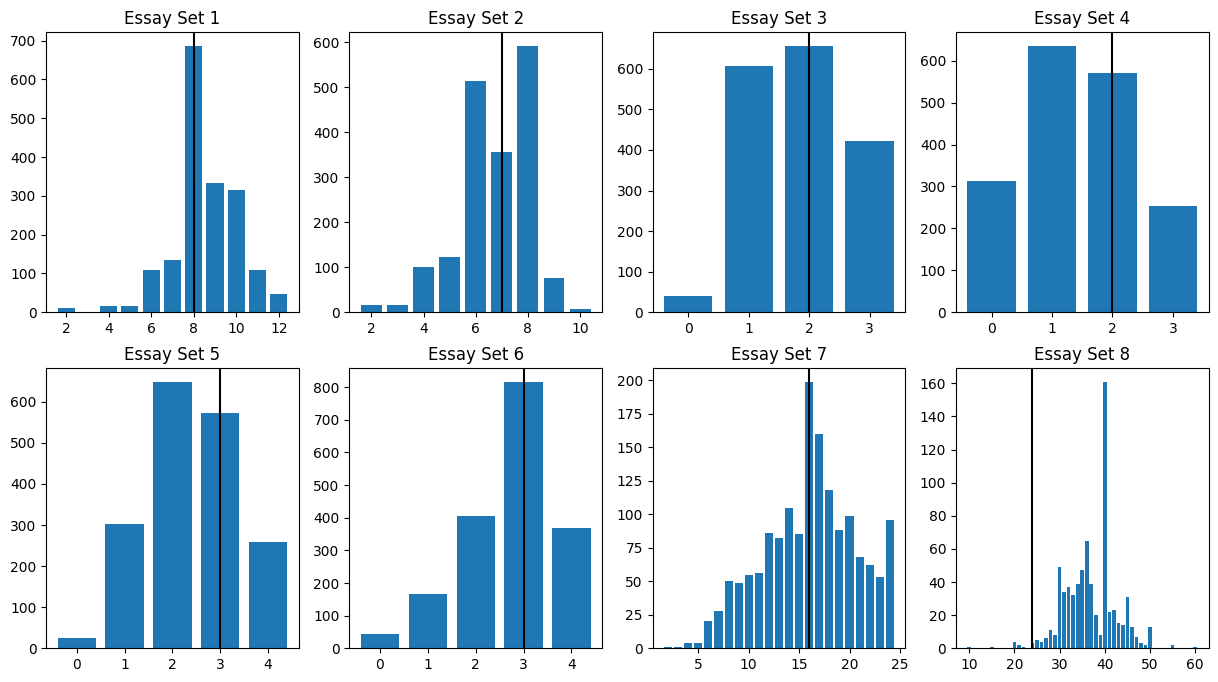

In [ ]:
sets = [train.loc[train["essay_set"]==i, :] for i in range(1, 9)]

val_counts = [set_["total"].value_counts() for set_ in sets]

fig, axs = plt.subplots(nrows=2, ncols=4, figsize = (15, 8))

axs[0, 0].bar(x = val_counts[0].index, height = val_counts[0].values)
axs[0, 0].set_title("Essay Set 1")
axs[0, 0].axvline(8, color = "black")
axs[0, 1].bar(x = val_counts[1].index, height = val_counts[1].values)
axs[0, 1].set_title("Essay Set 2")
axs[0, 1].axvline(7, color = "black")
axs[0, 2].bar(x = val_counts[2].index, height = val_counts[2].values)
axs[0, 2].set_title("Essay Set 3")
axs[0, 2].axvline(2, color = "black")
axs[0, 3].bar(x = val_counts[3].index, height = val_counts[3].values)
axs[0, 3].set_title("Essay Set 4")
axs[0, 3].axvline(2, color = "black")
axs[1, 0].bar(x = val_counts[4].index, height = val_counts[4].values)
axs[1, 0].set_title("Essay Set 5")
axs[1, 0].axvline(3, color = "black")
axs[1, 1].bar(x = val_counts[5].index, height = val_counts[5].values)
axs[1, 1].set_title("Essay Set 6")
axs[1, 1].axvline(3, color = "black")
axs[1, 2].bar(x = val_counts[6].index, height = val_counts[6].values)
axs[1, 2].set_title("Essay Set 7")
axs[1, 2].axvline(16, color = "black")
axs[1, 3].bar(x = val_counts[7].index, height = val_counts[7].values)
axs[1, 3].set_title("Essay Set 8")
axs[1, 3].axvline(24, color = "black");

Count the number of words in each essay

In [ ]:
#get word count for each essay
train['word_count'] = train['text_clean'].apply(lambda x: len(str(x).split()))

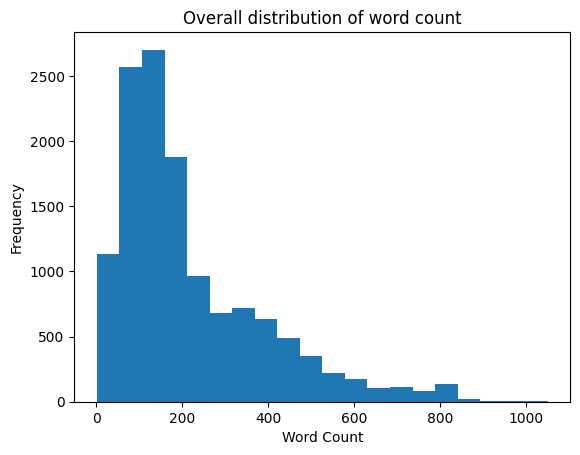

In [ ]:
#plot of word count
plt.hist(train["word_count"], bins = 20)
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.title("Overall distribution of word count");

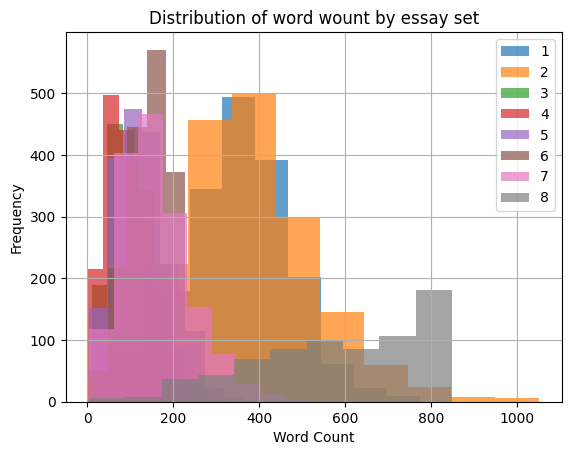

In [ ]:
#word count by essay set
train.groupby("essay_set")["word_count"].hist(alpha = 0.7, legend=True)
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.title("Distribution of word wount by essay set");

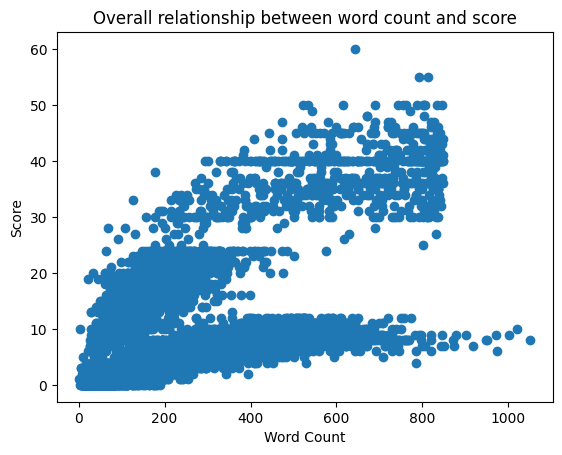

In [ ]:
#check relationship between word count and total score
plt.scatter(train["word_count"], train["total"])
plt.xlabel("Word Count")
plt.ylabel("Score")
plt.title("Overall relationship between word count and score");

**Let's disaggregate that scatterplot by essay set group because of the differing ranges of total**

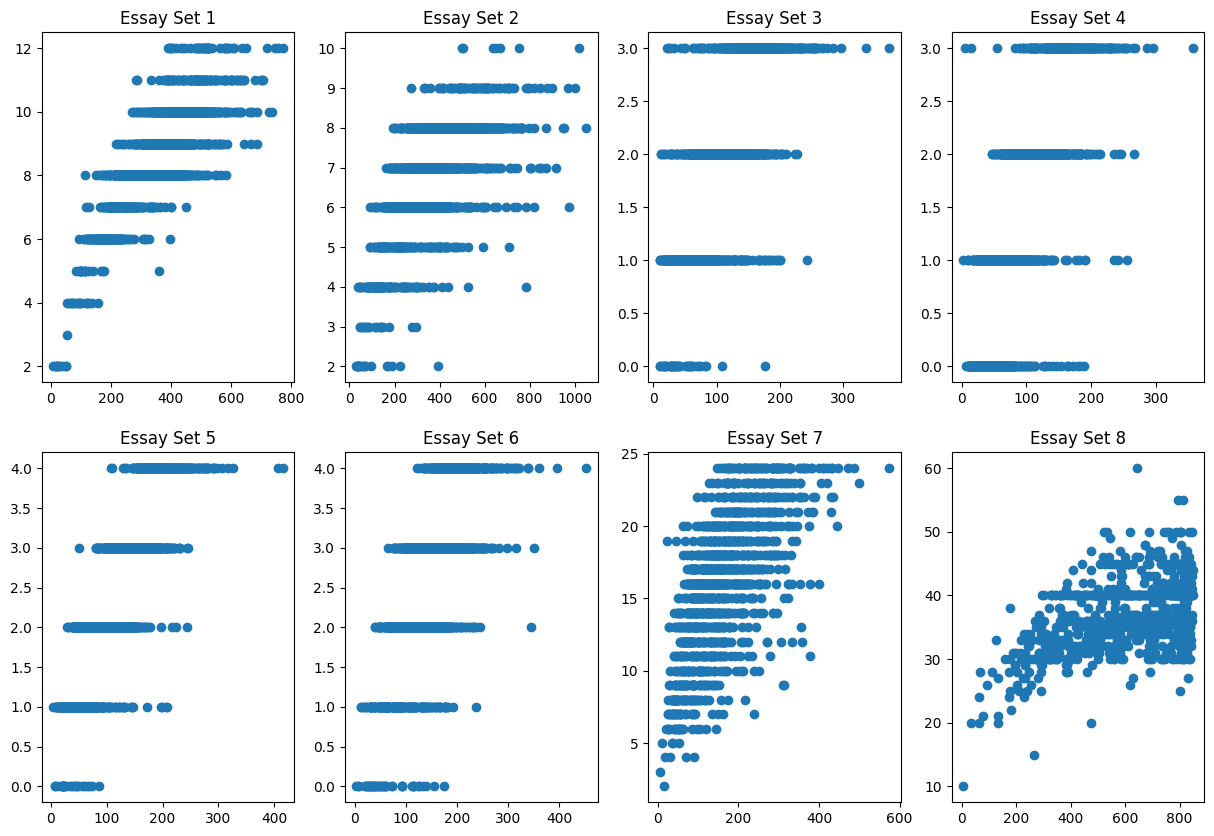

In [ ]:
sets = [train.loc[train["essay_set"]==i, ["essay_set", "word_count", "total"]] for i in range(1, 9)]
fig, axs = plt.subplots(nrows=2, ncols=4, figsize = (15, 10))

axs[0, 0].scatter(sets[0]["word_count"], sets[0]["total"])
axs[0, 0].set_title("Essay Set 1")
axs[0, 1].scatter(sets[1]["word_count"], sets[1]["total"])
axs[0, 1].set_title("Essay Set 2")
axs[0, 2].scatter(sets[2]["word_count"], sets[2]["total"])
axs[0, 2].set_title("Essay Set 3")
axs[0, 3].scatter(sets[3]["word_count"], sets[3]["total"])
axs[0, 3].set_title("Essay Set 4")
axs[1, 0].scatter(sets[4]["word_count"], sets[4]["total"])
axs[1, 0].set_title("Essay Set 5")
axs[1, 1].scatter(sets[5]["word_count"], sets[5]["total"])
axs[1, 1].set_title("Essay Set 6")
axs[1, 2].scatter(sets[6]["word_count"], sets[6]["total"])
axs[1, 2].set_title("Essay Set 7")
axs[1, 3].scatter(sets[7]["word_count"], sets[7]["total"])
axs[1, 3].set_title("Essay Set 8");

Figure above has total (score) on the y-axis and word_count on the x-axis (Labeling axes was taking too long)

**Now let's look at word uniqueness.** We'll create a new column called `word_diversity_score` which divides the number of unique words in an essay by the total number of words in that essay

In [ ]:
train["word_diversity_score"] = train["text_clean"].apply(lambda x: len(set(str(x).split())))/train["word_count"]

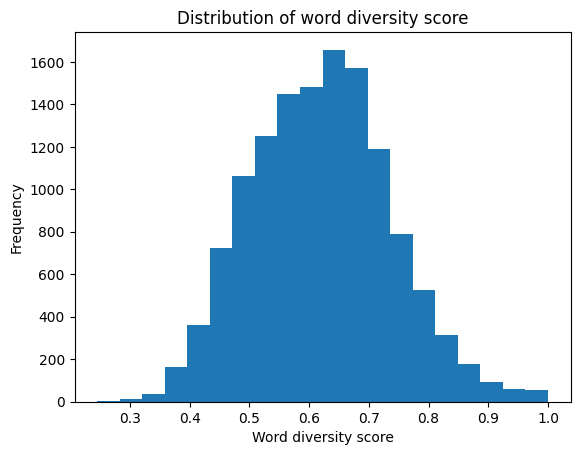

In [ ]:
# first let's look at the distribution

plt.hist(train["word_diversity_score"], bins = 20)
plt.xlabel("Word diversity score")
plt.ylabel("Frequency")
plt.title("Distribution of word diversity score");

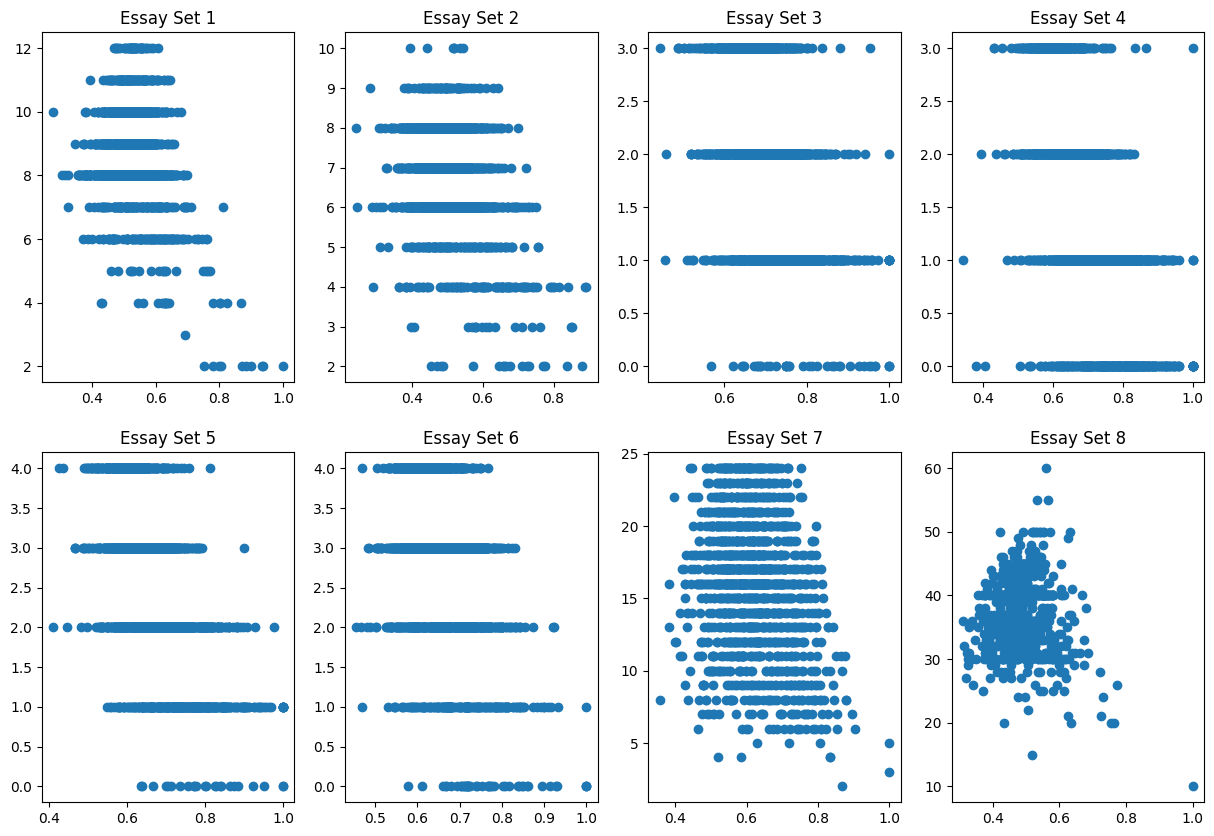

In [ ]:
sets = [train.loc[train["essay_set"]==i, ["essay_set", "word_count", "total", "word_diversity_score"]] for i in range(1, 9)]

fig, axs = plt.subplots(nrows=2, ncols=4, figsize = (15, 10))

axs[0, 0].scatter(sets[0]["word_diversity_score"], sets[0]["total"])
axs[0, 0].set_title("Essay Set 1")
axs[0, 1].scatter(sets[1]["word_diversity_score"], sets[1]["total"])
axs[0, 1].set_title("Essay Set 2")
axs[0, 2].scatter(sets[2]["word_diversity_score"], sets[2]["total"])
axs[0, 2].set_title("Essay Set 3")
axs[0, 3].scatter(sets[3]["word_diversity_score"], sets[3]["total"])
axs[0, 3].set_title("Essay Set 4")
axs[1, 0].scatter(sets[4]["word_diversity_score"], sets[4]["total"])
axs[1, 0].set_title("Essay Set 5")
axs[1, 1].scatter(sets[5]["word_diversity_score"], sets[5]["total"])
axs[1, 1].set_title("Essay Set 6")
axs[1, 2].scatter(sets[6]["word_diversity_score"], sets[6]["total"])
axs[1, 2].set_title("Essay Set 7")
axs[1, 3].scatter(sets[7]["word_diversity_score"], sets[7]["total"])
axs[1, 3].set_title("Essay Set 8");

Okay it looks like my hypothesis that essays with high word diversity would score higher was wrong! In several essay sets it looks like the opposite is actually true. This could be because shorter essays are more likely to have a high word diversity and also more likely to score poorly. We could probably create an even more complex variable that would take into account length and word diversity, but I don't think that would be productive.

In [ ]:
train_set

essay_id  essay_set                                              essay  \
7396      12142          5  The mood created by the author in the memoir i...   
11614     18864          7  Aplause  filled the building after the first d...   
2734       3929          2  What do you think about Books? Do you think it...   
12812     21416          8  Many people believe that laughter is a key par...   
72           73          1  Dear The @ORGANIZATION1, "@CAPS1, @CAPS1, @CAP...   
...         ...        ...                                                ...   
645         648          1  Dear @CAPS1 @CAPS2 @CAPS3, I think computers m...   
12613     21159          8   My cousin @PERSON1 and her boyfriend, @PERSON...   
7307      12053          5  He/she makes you try to be sad, I dont even kn...   
1956       3151          2  The entertainment for children and adults cons...   
3627       6023          3  The three most important features of the setti...   

                                             text_tensor  rater1_domain1  \
7396   b'The mood created by the author in the memoir...             3.0   
11614  b'Aplause  filled the building after the first...            12.0   
2734   b"What do you think about Books? Do you think ...             3.0   
12812  b'Many people believe that laughter is a key p...            20.0   
72     b'Dear The , ", , " goes the floor. "oh here c...             4.0   
...                                                  ...             ...   
645    b'Dear , I think computers make a big role in ...             3.0   
12613  b' My cousin and her boyfriend, , had been dat...            21.0   
7307   b'He/she makes you try to be sad, I dont even ...             0.0   
1956   b"The entertainment for children and adults co...             3.0   
3627   b'The three most important features of the set...             2.0   

       rater2_domain1  domain1_score  domain2_score  total     target  
7396              3.0            3.0            0.0    3.0  70.000000  
11614             9.0           21.0            0.0   21.0  84.782609  
2734              3.0            3.0            3.0    6.0  50.000000  
12812            19.0           40.0            0.0   40.0  59.803922  
72                4.0            8.0            0.0    8.0  59.090909  
...               ...            ...            ...    ...        ...  
645               3.0            6.0            0.0    6.0  40.909091  
12613            25.0           46.0            0.0   46.0  71.568627  
7307              0.0            0.0            0.0    0.0  10.000000  
1956              3.0            3.0            4.0    7.0  61.111111  
3627              2.0            2.0            0.0    2.0  62.500000  

[7786 rows x 10 columns]

---
### 4c. Modeling <a name='ds2modeling'></a>
[jump to top](#top)<br>

#### Linear Regression Baseline with Word Count

In [ ]:
#clean the text and reshape the data

train_set["text_clean"] = train_set["essay"].apply(str).apply(lambda x: text_preprocessing(x))
val_set["text_clean"] = val_set["essay"].apply(str).apply(lambda x: text_preprocessing(x))
test_set["text_clean"] = test_set["essay"].apply(str).apply(lambda x: text_preprocessing(x))


train_set['word_count'] = train_set['text_clean'].apply(lambda x: len(str(x).split()))
val_set['word_count'] = val_set['text_clean'].apply(lambda x: len(str(x).split()))
test_set['word_count'] = test_set['text_clean'].apply(lambda x: len(str(x).split()))

x_train_word = np.array(train_set['word_count']).reshape(-1, 1)
x_val_word = np.array(val_set['word_count']).reshape(-1, 1)
x_test_word = np.array(test_set['word_count']).reshape(-1, 1)




In [ ]:
def create_linear_model():
  ''' This will create a linear model with the word count as the x and the total scores as y.
  Note the transformation before the final output

  Returns the average QWK for the validation and test sets
  '''
  lr = LinearRegression()
  lr.fit(x_train_word, y_train)


  model_outputs_val = lr.predict(x_val_word)
  df = val_set[["essay_set", "total"]]
  df["model_output"] = model_outputs_val

  essay_set_ranges = [11, 9, 4, 4, 5, 5, 23, 51]
  essay_set_mins = [2, 2, 0, 0, 0, 0, 2, 10]
  score_preds = []

  for i in range(len(df)):
    data = df.reset_index().drop(columns=["index"])
    essay_set = data["essay_set"][i]
    normalized = data["model_output"][i]
    min_ = essay_set_mins[essay_set-1]
    num_classes = essay_set_ranges[essay_set-1]
    de_normalized = round(((num_classes/100)*(normalized + 0.5*(100/num_classes)) - 1) + min_, 0)
    score_preds.append(de_normalized)

  df["model_output_denormalized"] = score_preds

  kappa_scores_per_set = {}
  for essay_set in df["essay_set"].unique():
    data = df.loc[df["essay_set"]==essay_set] # subset to within a given essay_set
    kappa_score = cohen_kappa_score(data["total"], data["model_output_denormalized"], weights="quadratic") # calculate Quad Weighted Kappa (QWK)
    kappa_scores_per_set[essay_set] = kappa_score

  val_average_QWK = np.mean(list(kappa_scores_per_set.values()))


  model_outputs_test = lr.predict(x_test_word)

  df = test_set[["essay_set", "total"]]
  df["model_output"] = model_outputs_test

  essay_set_ranges = [11, 9, 4, 4, 5, 5, 23, 51]
  essay_set_mins = [2, 2, 0, 0, 0, 0, 2, 10]
  score_preds = []

  for i in range(len(df)):
    data = df.reset_index().drop(columns=["index"])
    essay_set = data["essay_set"][i]
    normalized = data["model_output"][i]
    min_ = essay_set_mins[essay_set-1]
    num_classes = essay_set_ranges[essay_set-1]
    de_normalized = round(((num_classes/100)*(normalized + 0.5*(100/num_classes)) - 1) + min_, 0)
    score_preds.append(de_normalized)

  df["model_output_denormalized"] = score_preds

  kappa_scores_per_set = {}
  for essay_set in df["essay_set"].unique():
    data = df.loc[df["essay_set"]==essay_set] # subset to within a given essay_set
    kappa_score = cohen_kappa_score(data["total"], data["model_output_denormalized"], weights="quadratic") # calculate Quad Weighted Kappa (QWK)
    kappa_scores_per_set[essay_set] = kappa_score

  test_average_QWK = np.mean(list(kappa_scores_per_set.values()))

  return val_average_QWK, test_average_QWK

In [ ]:
val_linear_qwk, test_linear_qwk = create_linear_model()


print("Average QWK for validation essay sets using word count: ", val_linear_qwk)
print("Average QWK for test essay sets using word count:       ", test_linear_qwk)

Average QWK for validation essay sets using word count:  0.14457209142799526
Average QWK for test essay sets using word count:        0.15396664856470604


### Linear Approach with Predicted Features

In [ ]:
#load in features from the best model 1 outputs
reg_train_features = np.array(pd.read_csv("/content/drive/MyDrive/Colab/good_features/reg_train_features.csv").drop(columns=["Unnamed: 0"]))
reg_val_features = np.array(pd.read_csv("/content/drive/MyDrive/Colab/good_features/reg_val_features.csv").drop(columns=["Unnamed: 0"]))
reg_test_features = np.array(pd.read_csv("/content/drive/MyDrive/Colab/good_features/reg_test_features.csv").drop(columns=["Unnamed: 0"]))

cat_train_features = np.array(pd.read_csv("/content/drive/MyDrive/Colab/good_features/cat_train_features.csv").drop(columns=["Unnamed: 0"]))
cat_val_features = np.array(pd.read_csv("/content/drive/MyDrive/Colab/good_features/cat_val_features.csv").drop(columns=["Unnamed: 0"]))
cat_test_features = np.array(pd.read_csv("/content/drive/MyDrive/Colab/good_features/cat_test_features.csv").drop(columns=["Unnamed: 0"]))

In [ ]:
def create_lin_feat_model(model_type = 'Classification'):
  '''Creates a linear model with the features from model 1 as input
  Specify model_type to pull the features from the BERT Classification or Regression model
  Returns average QWK for validation and test sets'''

  lr = LinearRegression()
  if model_type == 'Classification':
    lr.fit(cat_train_features, y_train)
    model_outputs_val = lr.predict(cat_val_features)
    model_outputs_test = lr.predict(cat_test_features)

  else:
    lr.fit(reg_train_features, y_train)
    model_outputs_val = lr.predict(reg_val_features)
    model_outputs_test = lr.predict(reg_test_features)

  df = val_set[["essay_set", "total"]]
  df["model_output"] = model_outputs_val

  essay_set_ranges = [11, 9, 4, 4, 5, 5, 23, 51]
  essay_set_mins = [2, 2, 0, 0, 0, 0, 2, 10]
  score_preds = []

  for i in range(len(df)):
    data = df.reset_index().drop(columns=["index"])
    essay_set = data["essay_set"][i]
    normalized = data["model_output"][i]

    min_ = essay_set_mins[essay_set-1]
    num_classes = essay_set_ranges[essay_set-1]
    de_normalized = round(((num_classes/100)*(normalized + 0.5*(100/num_classes)) - 1) + min_, 0)
    score_preds.append(de_normalized)

  df["model_output_denormalized"] = score_preds

  kappa_scores_per_set = {}
  for essay_set in df["essay_set"].unique():
    data = df.loc[df["essay_set"]==essay_set] # subset to within a given essay_set

    kappa_score = cohen_kappa_score(data["total"], data["model_output_denormalized"], weights="quadratic") # calculate Quad Weighted Kappa (QWK)
    kappa_scores_per_set[essay_set] = kappa_score



  val_average_QWK = np.mean(list(kappa_scores_per_set.values()))




  df = test_set[["essay_set", "total"]]
  df["model_output"] = model_outputs_test

  essay_set_ranges = [11, 9, 4, 4, 5, 5, 23, 51]
  essay_set_mins = [2, 2, 0, 0, 0, 0, 2, 10]
  score_preds = []

  for i in range(len(df)):
    data = df.reset_index().drop(columns=["index"])
    essay_set = data["essay_set"][i]
    normalized = data["model_output"][i]
    min_ = essay_set_mins[essay_set-1]
    num_classes = essay_set_ranges[essay_set-1]
    de_normalized = round(((num_classes/100)*(normalized + 0.5*(100/num_classes)) - 1) + min_, 0)
    score_preds.append(de_normalized)

  df["model_output_denormalized"] = score_preds

  kappa_scores_per_set = {}
  for essay_set in df["essay_set"].unique():
    data = df.loc[df["essay_set"]==essay_set] # subset to within a given essay_set
    kappa_score = cohen_kappa_score(data["total"], data["model_output_denormalized"], weights="quadratic") # calculate Quad Weighted Kappa (QWK)
    kappa_scores_per_set[essay_set] = kappa_score

  test_average_QWK = np.mean(list(kappa_scores_per_set.values()))

  return val_average_QWK, test_average_QWK



In [ ]:
cat_val_linear_qwk, cat_test_linear_qwk = create_lin_feat_model()

print("Average QWK for linear model validation essay sets using classification features: ", cat_val_linear_qwk)
print("Average QWK for linear model test essay sets using classification features:       ", cat_test_linear_qwk)

In [ ]:
reg_val_linear_qwk, reg_test_linear_qwk = create_lin_feat_model(model_type = "Regression")

print("Average QWK for linear model validation essay sets using regression features: ", reg_val_linear_qwk)
print("Average QWK for linear model test essay sets using regression features:       ", reg_test_linear_qwk)

### Random Forest Regression Model

In [ ]:
def create_rf_model(n_estimators = 5, max_depth = 3, model_type = "Classification"):

  '''Creates a Random forest model with the features from model 1 as input
  Specify model_type to pull the features from the BERT Classification or Regression model
  Returns average QWK for validation and test sets'''

  rf = RandomForestRegressor(n_estimators = n_estimators)
  if model_type == 'Classification':
    rf.fit(cat_train_features, y_train)
    model_outputs_val = rf.predict(cat_val_features)
    model_outputs_test = rf.predict(cat_test_features)

  else:
    rf.fit(reg_train_features, y_train)
    model_outputs_val = rf.predict(reg_val_features)
    model_outputs_test = rf.predict(reg_test_features)

  df = val_set[["essay_set", "total"]]
  df["model_output"] = model_outputs_val

  essay_set_ranges = [11, 9, 4, 4, 5, 5, 23, 51]
  essay_set_mins = [2, 2, 0, 0, 0, 0, 2, 10]
  score_preds = []

  for i in range(len(df)):
    data = df.reset_index().drop(columns=["index"])
    essay_set = data["essay_set"][i]
    normalized = data["model_output"][i]

    min_ = essay_set_mins[essay_set-1]
    num_classes = essay_set_ranges[essay_set-1]
    de_normalized = round(((num_classes/100)*(normalized + 0.5*(100/num_classes)) - 1) + min_, 0)
    score_preds.append(de_normalized)

  df["model_output_denormalized"] = score_preds

  kappa_scores_per_set = {}
  for essay_set in df["essay_set"].unique():
    data = df.loc[df["essay_set"]==essay_set] # subset to within a given essay_set

    kappa_score = cohen_kappa_score(data["total"], data["model_output_denormalized"], weights="quadratic") # calculate Quad Weighted Kappa (QWK)
    kappa_scores_per_set[essay_set] = kappa_score



  val_average_QWK = np.mean(list(kappa_scores_per_set.values()))

  df = test_set[["essay_set", "total"]]
  df["model_output"] = model_outputs_test

  essay_set_ranges = [11, 9, 4, 4, 5, 5, 23, 51]
  essay_set_mins = [2, 2, 0, 0, 0, 0, 2, 10]
  score_preds = []

  for i in range(len(df)):
    data = df.reset_index().drop(columns=["index"])
    essay_set = data["essay_set"][i]
    normalized = data["model_output"][i]
    min_ = essay_set_mins[essay_set-1]
    num_classes = essay_set_ranges[essay_set-1]
    de_normalized = round(((num_classes/100)*(normalized + 0.5*(100/num_classes)) - 1) + min_, 0)
    score_preds.append(de_normalized)

  df["model_output_denormalized"] = score_preds

  kappa_scores_per_set = {}
  for essay_set in df["essay_set"].unique():
    data = df.loc[df["essay_set"]==essay_set] # subset to within a given essay_set
    kappa_score = cohen_kappa_score(data["total"], data["model_output_denormalized"], weights="quadratic") # calculate Quad Weighted Kappa (QWK)
    kappa_scores_per_set[essay_set] = kappa_score

  test_average_QWK = np.mean(list(kappa_scores_per_set.values()))

  return val_average_QWK, test_average_QWK

In [ ]:
#plot the training of the random forest model against the different number of estimators for the BERT classification model
n_estimators_list = [5, 10, 15, 20, 25]


val_scores = []
test_scores = []


for n_estimators in n_estimators_list:
    cat_val_rf_qwk, cat_test_rf_qwk = create_rf_model(n_estimators=n_estimators, max_depth=3, model_type="Classification")
    val_scores.append(cat_val_rf_qwk)
    test_scores.append(cat_test_rf_qwk)


plt.figure(figsize=(8, 6))
plt.plot(n_estimators_list, val_scores, label='Validation QWK')
plt.plot(n_estimators_list, test_scores, label='Test QWK')
plt.xlabel('n_estimators')
plt.ylabel('QWK Score')
plt.title('Classification QWK Score vs. n_estimators')
plt.legend()
plt.show()

In [ ]:
#plot the training of the random forest model against the different number of estimators for the Regression model
n_estimators_list = [5, 10, 15, 20, 25]


val_scores = []
test_scores = []


for n_estimators in n_estimators_list:
    reg_val_rf_qwk, reg_test_rf_qwk = create_rf_model(n_estimators=n_estimators, max_depth=3, model_type="Regression")
    val_scores.append(reg_val_rf_qwk)
    test_scores.append(reg_test_rf_qwk)


plt.figure(figsize=(8, 6))
plt.plot(n_estimators_list, val_scores, label='Validation QWK')
plt.plot(n_estimators_list, test_scores, label='Test QWK')
plt.xlabel('n_estimators')
plt.ylabel('QWK Score')
plt.title('Regression QWK Score vs. n_estimators')
plt.legend()
plt.show()

#### Neural Approach (improvement over baseline)

In [ ]:
# training essays
cls_df_train = pd.read_csv("/content/drive/MyDrive/Colab/cls_tokens_train_original_dataset.csv").drop(columns=["Unnamed: 0"])
cls_np_train = np.array(cls_df_train)
cls_tensor_train_2 = tf.convert_to_tensor(cls_np_train, dtype="float32") # training input

# validation essays
cls_df_val = pd.read_csv("/content/drive/MyDrive/Colab/cls_tokens_val_original_dataset.csv").drop(columns=["Unnamed: 0"])
cls_np_val = np.array(cls_df_val)
cls_tensor_val_2 = tf.convert_to_tensor(cls_np_val, dtype="float32") # validation input

# testing essays
cls_df_test = pd.read_csv("/content/drive/MyDrive/Colab/cls_tokens_test_original_dataset.csv").drop(columns=["Unnamed: 0"])
cls_np_test = np.array(cls_df_test)
cls_tensor_test_2 = tf.convert_to_tensor(cls_np_test, dtype="float32") # testing input

In [ ]:
def create_nn_model(hidden_size=64, learning_rate=0.0005, num_layers = 1, dropout = 0.3, optimizer = "Adam", activation = 'relu'):
    """Build and compile a tensorflow neural network that takes predictions for {cohesion, syntax, ...} for a given essay as inputs and outputs
     a continuously-valued score for that essay. Next step will be to convert that output back to an integer score so that we can evaluate
     with kappa"""

    tf.keras.backend.clear_session()
    tf.random.set_seed(0)


    model = tf.keras.models.Sequential()


    model.add(tf.keras.layers.Dense(hidden_size, activation=activation, input_shape=(6,)))
    model.add(tf.keras.layers.BatchNormalization())

    for _ in range(num_layers): #add hidden layers with dropout
        model.add(tf.keras.layers.Dense(hidden_size, activation=activation))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dropout(dropout))

    model.add(tf.keras.layers.Dense(1, activation='linear'))

    if optimizer == "Adam":
      model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),
                    loss = tf.keras.losses.MeanSquaredError(),
                    metrics = ['mse'])
    else:
      model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate),
                    loss = tf.keras.losses.MeanSquaredError(),
                    metrics = ['mse'])

    return model

In [ ]:
def create_train_evaluate_model_2(model_1_type,
                                  model_1 = None,
                                  learning_rate=0.0001,
                                  hidden_size=64,
                                  num_layers=1,
                                  dropout=0.2,
                                  num_epochs=100,
                                  batch_size=32,
                                  optimizer = "Adam",
                                  activation = 'relu',
                                  show_plots=True,
                                  verbose=1):
  """Create, train, and evaluate our stage 2 model. The features used by this model were created by applying one of our stage 1 models
  (either regression or classification) to the essays from the Hewlett Foundation Automated Essay Scoring (AES) dataset
  https://www.kaggle.com/competitions/asap-aes/overview
  (what we refer to as our "original datasset"). The target for this model was created by taking the associated scores from the
  aforementioned essays and projecting them to the range (0, 100) in order to reframe the modeling task as a regression problem. In order to
  evaluate model performance, we re-project the predictions in (0, 100) back down into their respective range depending on the essay set they
  belong to, then calculate the Quadratic Weighted Kappa score between the ground truth and the predicted scores within each essay set; these
  eight scores can then be averaged for a more holistic measure of model performance.

  For instance, a ground truth score of 3 for an essay from essay set 5 (which has scores in {0, 1, 2, 3, 4}) would be mapped to a target
  value of 70. Our model might generate a predicted value of 85 for this essay; this prediction would then be mapped back down to its
  respective closest approximation in {0, 1, 2, 3, 4} which would be 4. Therefore, this essay has a ground truth score of 3 and our model
  predicted a score of 4."""

  # generate the features for the stage 2 model (or use pre-genrated features)
  if model_1 != None: # generate fresh features using model_1
    if model_1_type == "regression":
      train_features, val_features, test_features = generate_features(model_1, "mse")
    elif model_1_type == "classification":
      train_features, val_features, test_features = generate_features(model_1, "kappa")
    else:
      raise Exception("You did not enter a valid model_1_type value. Please enter 'regression' to use a regression model, or use 'classification' to use a classification model")
  else: # or just read in already generated features (don't need a model_1)
    if model_1_type == "regression":
      train_features = np.array(pd.read_csv("/content/drive/MyDrive/Colab/good_features/reg_train_features.csv").drop(columns=["Unnamed: 0"]))
      val_features = np.array(pd.read_csv("/content/drive/MyDrive/Colab/good_features/reg_val_features.csv").drop(columns=["Unnamed: 0"]))
      test_features = np.array(pd.read_csv("/content/drive/MyDrive/Colab/good_features/reg_test_features.csv").drop(columns=["Unnamed: 0"]))
    elif model_1_type == "classification":
      train_features = np.array(pd.read_csv("/content/drive/MyDrive/Colab/good_features/cat_train_features.csv").drop(columns=["Unnamed: 0"]))
      val_features = np.array(pd.read_csv("/content/drive/MyDrive/Colab/good_features/cat_val_features.csv").drop(columns=["Unnamed: 0"]))
      test_features = np.array(pd.read_csv("/content/drive/MyDrive/Colab/good_features/cat_test_features.csv").drop(columns=["Unnamed: 0"]))
    else:
      raise Exception("You did not enter a valid model_1_type value. Please enter 'regression' to use the features generated by the regression model, or use 'classification' to use features generated by the classification model")

  # create the model with the specified parameters
  model = create_nn_model(hidden_size=hidden_size,
                          learning_rate=learning_rate,
                          num_layers=num_layers,
                          dropout=dropout,
                          optimizer= optimizer,
                          activation = activation)


  # train the model using the appropriate features
  model_history = model.fit(
      train_features,
      y_train,
      validation_data=(val_features, y_val),
      batch_size=batch_size,
      epochs=num_epochs,
      verbose=verbose
  )

  if show_plots == True:
    plot_loss(history=model_history, model=model)


  # evaluation
  model_outputs_test = model.predict(test_features)

  df = test_set[["essay_set", "total"]]
  df["model_output"] = model_outputs_test

  essay_set_ranges = [11, 9, 4, 4, 5, 5, 23, 51]
  essay_set_mins = [2, 2, 0, 0, 0, 0, 2, 10]
  score_preds = []

  for i in range(len(df)):
    data = df.reset_index().drop(columns=["index"])
    essay_set = data["essay_set"][i]
    normalized = data["model_output"][i]
    min_ = essay_set_mins[essay_set-1]
    num_classes = essay_set_ranges[essay_set-1]
    de_normalized = round(((num_classes/100)*(normalized + 0.5*(100/num_classes)) - 1) + min_, 0)
    score_preds.append(de_normalized)

  df["model_output_denormalized"] = score_preds

  kappa_scores_per_set = {}
  for essay_set in df["essay_set"].unique():
    data = df.loc[df["essay_set"]==essay_set] # subset to within a given essay_set
    kappa_score = cohen_kappa_score(data["total"], data["model_output_denormalized"], weights="quadratic") # calculate Quad Weighted Kappa (QWK)
    kappa_scores_per_set[essay_set] = kappa_score

  average_QWK = np.mean(list(kappa_scores_per_set.values()))

  # add a row to the hyperparameter table
  add_hyperp_2(model_1_type, learning_rate, hidden_size, num_layers, dropout, num_epochs, batch_size, optimizer, activation,
               kappa_scores_per_set[1], kappa_scores_per_set[2], kappa_scores_per_set[3], kappa_scores_per_set[4],
               kappa_scores_per_set[5], kappa_scores_per_set[6], kappa_scores_per_set[7], kappa_scores_per_set[8],
               average_QWK)

  return model


In [ ]:
#hyperp_df2 = pd.read_csv("/content/drive/MyDrive/Colab/hyperp_df2.csv").drop(columns=["Unnamed: 0"])

In [ ]:
hyperp_df2 = pd.DataFrame(columns=["Model 1 type", "Learning Rate", "Hidden Size", "Hidden Layers", "Dropout Rate", "Epochs", "Batch Size", "Optimizer", "Activation",
                                  "Essay Set 1", "Essay Set 2", "Essay Set 3", "Essay Set 4",
                                  "Essay Set 5", "Essay Set 6", "Essay Set 7", "Essay Set 8",
                                  "Mean QWK"])
hyperp_df2

Empty DataFrame
Columns: [Model 1 type, Learning Rate, Hidden Size, Hidden Layers, Dropout Rate, Epochs, Batch Size, Optimizer, Activation, Essay Set 1, Essay Set 2, Essay Set 3, Essay Set 4, Essay Set 5, Essay Set 6, Essay Set 7, Essay Set 8, Mean QWK]
Index: []

In [ ]:
hyperp_df2

Empty DataFrame
Columns: [Model 1 type, Learning Rate, Hidden Size, Hidden Layers, Dropout Rate, Epochs, Batch Size, Optimizer, Activation, Essay Set 1, Essay Set 2, Essay Set 3, Essay Set 4, Essay Set 5, Essay Set 6, Essay Set 7, Essay Set 8, Mean QWK]
Index: []

In [ ]:
#DANGER DELETE LAST ROW IN CASE YOU MESS UP
#hyperp_df2 = delete_row(hyperp_df2)


Iteration number:  0

 COMBO:  (0.005, 64, 3, 0.5, 'Adam', 'relu')
Epoch 1/100
244/244 [==============================] - 5s 6ms/step - loss: 715.8439 - mse: 715.8439 - val_loss: 463.8958 - val_mse: 463.8958
Epoch 2/100
244/244 [==============================] - 1s 5ms/step - loss: 511.7881 - mse: 511.7881 - val_loss: 459.1203 - val_mse: 459.1203
Epoch 3/100
244/244 [==============================] - 1s 5ms/step - loss: 461.3062 - mse: 461.3062 - val_loss: 408.3661 - val_mse: 408.3661
Epoch 4/100
244/244 [==============================] - 1s 5ms/step - loss: 431.6454 - mse: 431.6454 - val_loss: 306.8480 - val_mse: 306.8480
Epoch 5/100
244/244 [==============================] - 1s 5ms/step - loss: 422.1975 - mse: 422.1975 - val_loss: 315.3741 - val_mse: 315.3741
Epoch 6/100
244/244 [==============================] - 2s 7ms/step - loss: 422.7669 - mse: 422.7669 - val_loss: 339.7705 - val_mse: 339.7705
Epoch 7/100
244/244 [==============================] - 2s 7ms/step - loss: 403.0515 - 

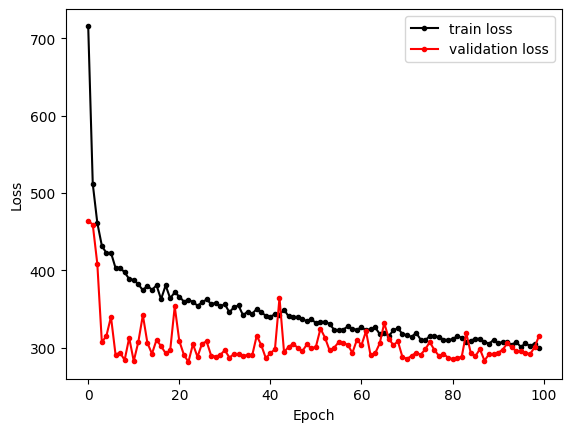

Final train loss: 299.50384521484375
Final validation loss: 315.544189453125
82/82 [==============================] - 0s 2ms/step


Epoch 1/100
244/244 [==============================] - 3s 5ms/step - loss: 740.3689 - mse: 740.3689 - val_loss: 431.2991 - val_mse: 431.2991
Epoch 2/100
244/244 [==============================] - 1s 5ms/step - loss: 500.8157 - mse: 500.8157 - val_loss: 452.7944 - val_mse: 452.7944
Epoch 3/100
244/244 [==============================] - 1s 5ms/step - loss: 464.9564 - mse: 464.9564 - val_loss: 408.6235 - val_mse: 408.6235
Epoch 4/100
244/244 [==============================] - 1s 5ms/step - loss: 434.9123 - mse: 434.9123 - val_loss: 328.7750 - val_mse: 328.7750
Epoch 5/100
244/244 [==============================] - 1s 5ms/step - loss: 418.5731 - mse: 418.5731 - val_loss: 321.6083 - val_mse: 321.6083
Epoch 6/100
244/244 [==============================] - 1s 5ms/step - loss: 420.1244 - mse: 420.1244 - val_loss: 365.9741 - val_mse: 365.9741
Epoch 7/100
244/244 [==============================] - 1s 4ms/step - loss: 412.0625 - mse: 412.0625 - val_loss: 343.2681 - val_mse: 343.2681
Epoch 8/100
2

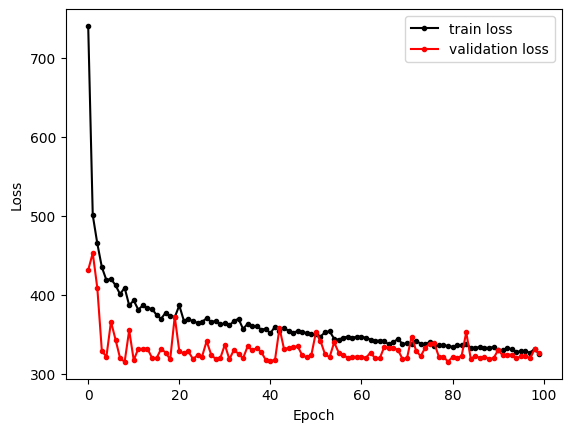

Final train loss: 325.25738525390625
Final validation loss: 326.04296875
82/82 [==============================] - 0s 2ms/step



Iteration number:  1

 COMBO:  (0.0001, 256, 3, 0.3, 'Adam', 'tanh')
Epoch 1/100
244/244 [==============================] - 5s 6ms/step - loss: 2050.0781 - mse: 2050.0781 - val_loss: 1585.6995 - val_mse: 1585.6995
Epoch 2/100
244/244 [==============================] - 1s 5ms/step - loss: 1331.7181 - mse: 1331.7181 - val_loss: 1210.8041 - val_mse: 1210.8041
Epoch 3/100
244/244 [==============================] - 1s 5ms/step - loss: 1015.8685 - mse: 1015.8685 - val_loss: 941.7698 - val_mse: 941.7698
Epoch 4/100
244/244 [==============================] - 1s 5ms/step - loss: 794.5495 - mse: 794.5495 - val_loss: 749.0630 - val_mse: 749.0630
Epoch 5/100
244/244 [==============================] - 1s 5ms/step - loss: 635.4779 - mse: 635.4779 - val_loss: 614.5126 - val_mse: 614.5126
Epoch 6/100
244/244 [==============================] - 1s 5ms/step - loss: 529.9991 - mse: 529.9991 - val_loss: 523.9778 - val_mse: 523.9778
Epoch 7/100
244/244 [==============================] - 1s 5ms/step - loss:

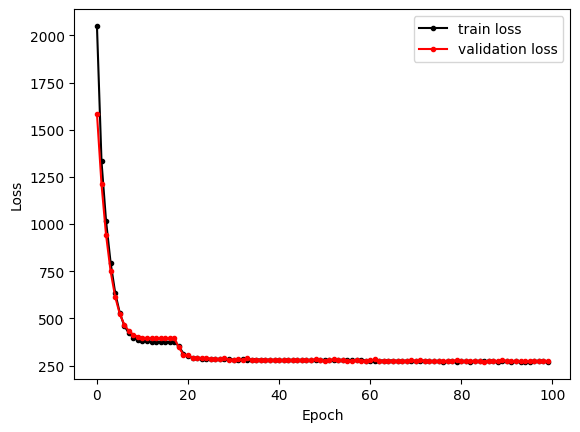

Final train loss: 268.9788818359375
Final validation loss: 274.2784118652344
82/82 [==============================] - 0s 2ms/step


Epoch 1/100
244/244 [==============================] - 5s 7ms/step - loss: 2050.3315 - mse: 2050.3315 - val_loss: 1560.1277 - val_mse: 1560.1277
Epoch 2/100
244/244 [==============================] - 1s 5ms/step - loss: 1307.6005 - mse: 1307.6005 - val_loss: 1186.7180 - val_mse: 1186.7180
Epoch 3/100
244/244 [==============================] - 1s 5ms/step - loss: 995.5541 - mse: 995.5541 - val_loss: 921.9077 - val_mse: 921.9077
Epoch 4/100
244/244 [==============================] - 1s 5ms/step - loss: 777.9917 - mse: 777.9917 - val_loss: 733.7022 - val_mse: 733.7022
Epoch 5/100
244/244 [==============================] - 1s 5ms/step - loss: 623.2144 - mse: 623.2144 - val_loss: 603.1260 - val_mse: 603.1260
Epoch 6/100
244/244 [==============================] - 1s 5ms/step - loss: 521.1675 - mse: 521.1675 - val_loss: 515.9962 - val_mse: 515.9962
Epoch 7/100
244/244 [==============================] - 1s 5ms/step - loss: 455.1054 - mse: 455.1054 - val_loss: 461.6890 - val_mse: 461.6890
Epoch

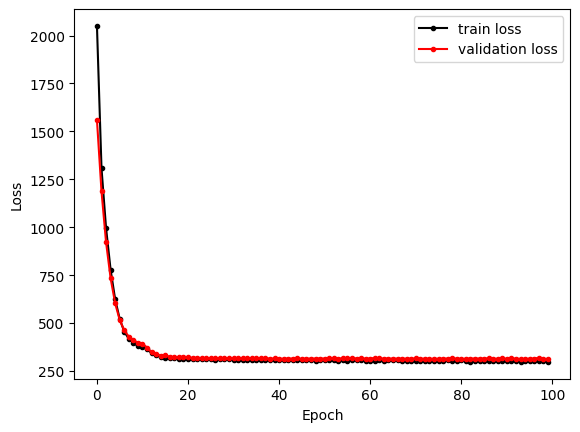

Final train loss: 298.30743408203125
Final validation loss: 313.203857421875
82/82 [==============================] - 0s 2ms/step



Iteration number:  2

 COMBO:  (0.001, 256, 1, 0.3, 'Adam', 'relu')
Epoch 1/100
244/244 [==============================] - 4s 7ms/step - loss: 577.9677 - mse: 577.9677 - val_loss: 320.9919 - val_mse: 320.9919
Epoch 2/100
244/244 [==============================] - 1s 5ms/step - loss: 331.9645 - mse: 331.9645 - val_loss: 317.4858 - val_mse: 317.4858
Epoch 3/100
244/244 [==============================] - 1s 4ms/step - loss: 309.7277 - mse: 309.7277 - val_loss: 330.0718 - val_mse: 330.0718
Epoch 4/100
244/244 [==============================] - 1s 4ms/step - loss: 302.3965 - mse: 302.3965 - val_loss: 322.3579 - val_mse: 322.3579
Epoch 5/100
244/244 [==============================] - 1s 4ms/step - loss: 300.5141 - mse: 300.5141 - val_loss: 284.3311 - val_mse: 284.3311
Epoch 6/100
244/244 [==============================] - 1s 4ms/step - loss: 297.5984 - mse: 297.5984 - val_loss: 302.5706 - val_mse: 302.5706
Epoch 7/100
244/244 [==============================] - 1s 4ms/step - loss: 296.3997 -

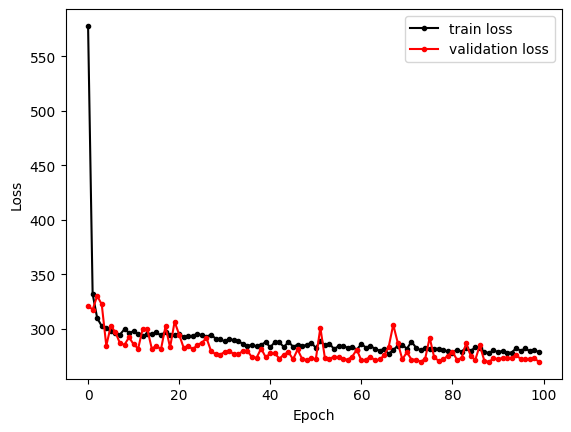

Final train loss: 278.3082580566406
Final validation loss: 269.5229187011719
82/82 [==============================] - 0s 2ms/step


Epoch 1/100
244/244 [==============================] - 2s 5ms/step - loss: 579.6186 - mse: 579.6186 - val_loss: 345.6367 - val_mse: 345.6367
Epoch 2/100
244/244 [==============================] - 1s 5ms/step - loss: 331.6896 - mse: 331.6896 - val_loss: 333.5731 - val_mse: 333.5731
Epoch 3/100
244/244 [==============================] - 1s 5ms/step - loss: 322.5155 - mse: 322.5155 - val_loss: 351.4333 - val_mse: 351.4333
Epoch 4/100
244/244 [==============================] - 1s 6ms/step - loss: 318.0505 - mse: 318.0505 - val_loss: 351.1002 - val_mse: 351.1002
Epoch 5/100
244/244 [==============================] - 1s 5ms/step - loss: 315.7346 - mse: 315.7346 - val_loss: 316.2367 - val_mse: 316.2367
Epoch 6/100
244/244 [==============================] - 2s 6ms/step - loss: 313.5589 - mse: 313.5589 - val_loss: 322.5475 - val_mse: 322.5475
Epoch 7/100
244/244 [==============================] - 1s 6ms/step - loss: 313.7352 - mse: 313.7352 - val_loss: 317.7794 - val_mse: 317.7794
Epoch 8/100
2

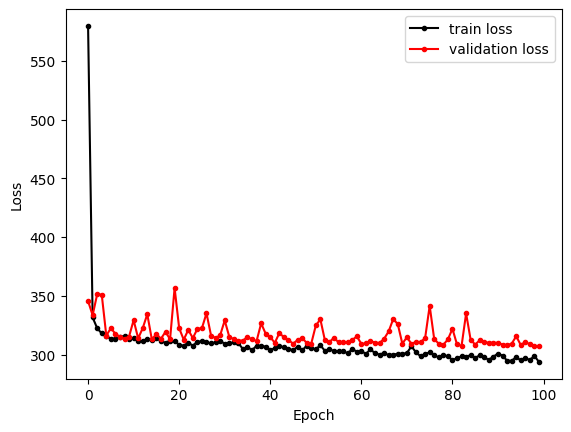

Final train loss: 293.8505554199219
Final validation loss: 307.2887878417969
82/82 [==============================] - 0s 2ms/step



Iteration number:  3

 COMBO:  (0.005, 256, 3, 0.3, 'Adam', 'sigmoid')
Epoch 1/100
244/244 [==============================] - 3s 5ms/step - loss: 635.5210 - mse: 635.5210 - val_loss: 395.1171 - val_mse: 395.1171
Epoch 2/100
244/244 [==============================] - 1s 5ms/step - loss: 376.4724 - mse: 376.4724 - val_loss: 392.8606 - val_mse: 392.8606
Epoch 3/100
244/244 [==============================] - 1s 5ms/step - loss: 379.1866 - mse: 379.1866 - val_loss: 393.5583 - val_mse: 393.5583
Epoch 4/100
244/244 [==============================] - 1s 5ms/step - loss: 377.6015 - mse: 377.6015 - val_loss: 394.1122 - val_mse: 394.1122
Epoch 5/100
244/244 [==============================] - 1s 5ms/step - loss: 378.7944 - mse: 378.7944 - val_loss: 394.6291 - val_mse: 394.6291
Epoch 6/100
244/244 [==============================] - 2s 6ms/step - loss: 379.3733 - mse: 379.3733 - val_loss: 396.7239 - val_mse: 396.7239
Epoch 7/100
244/244 [==============================] - 2s 7ms/step - loss: 381.081

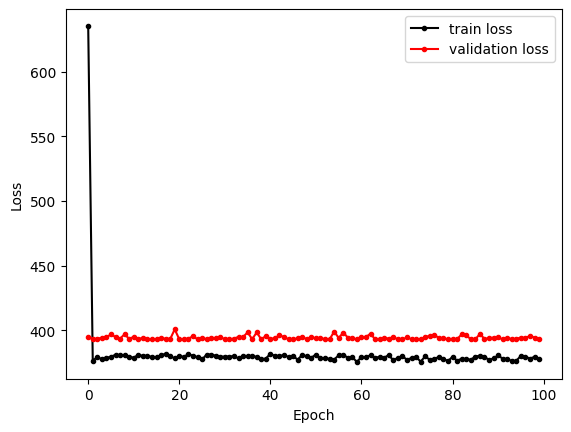

Final train loss: 377.6100158691406
Final validation loss: 392.9219665527344
82/82 [==============================] - 0s 2ms/step


Epoch 1/100
244/244 [==============================] - 3s 5ms/step - loss: 644.3461 - mse: 644.3461 - val_loss: 395.3301 - val_mse: 395.3301
Epoch 2/100
244/244 [==============================] - 1s 5ms/step - loss: 378.5540 - mse: 378.5540 - val_loss: 392.9130 - val_mse: 392.9130
Epoch 3/100
244/244 [==============================] - 1s 5ms/step - loss: 378.6728 - mse: 378.6728 - val_loss: 393.6614 - val_mse: 393.6614
Epoch 4/100
244/244 [==============================] - 1s 6ms/step - loss: 378.9272 - mse: 378.9272 - val_loss: 393.5386 - val_mse: 393.5386
Epoch 5/100
244/244 [==============================] - 2s 7ms/step - loss: 379.3681 - mse: 379.3681 - val_loss: 394.0305 - val_mse: 394.0305
Epoch 6/100
244/244 [==============================] - 2s 7ms/step - loss: 379.7607 - mse: 379.7607 - val_loss: 396.6442 - val_mse: 396.6442
Epoch 7/100
244/244 [==============================] - 2s 7ms/step - loss: 380.2584 - mse: 380.2584 - val_loss: 395.0975 - val_mse: 395.0975
Epoch 8/100
2

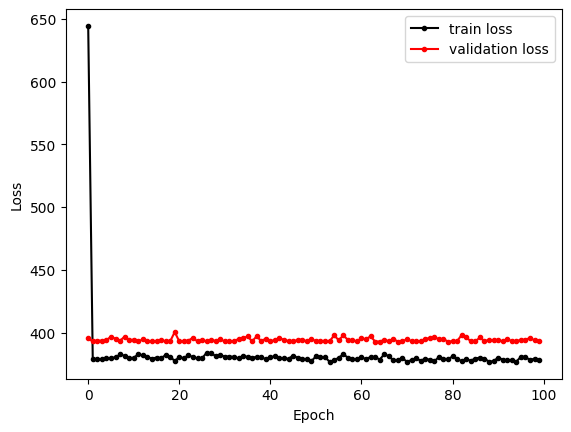

Final train loss: 377.73431396484375
Final validation loss: 392.881591796875
82/82 [==============================] - 0s 2ms/step



Iteration number:  4

 COMBO:  (0.0001, 128, 1, 0.3, 'Adam', 'tanh')
Epoch 1/100
244/244 [==============================] - 3s 5ms/step - loss: 2771.7671 - mse: 2771.7671 - val_loss: 2347.2727 - val_mse: 2347.2727
Epoch 2/100
244/244 [==============================] - 1s 4ms/step - loss: 2080.4897 - mse: 2080.4897 - val_loss: 1996.9904 - val_mse: 1996.9904
Epoch 3/100
244/244 [==============================] - 1s 4ms/step - loss: 1798.1483 - mse: 1798.1483 - val_loss: 1748.5208 - val_mse: 1748.5208
Epoch 4/100
244/244 [==============================] - 1s 4ms/step - loss: 1574.9409 - mse: 1574.9409 - val_loss: 1540.2217 - val_mse: 1540.2217
Epoch 5/100
244/244 [==============================] - 1s 4ms/step - loss: 1386.3666 - mse: 1386.3666 - val_loss: 1359.7430 - val_mse: 1359.7430
Epoch 6/100
244/244 [==============================] - 1s 5ms/step - loss: 1221.5303 - mse: 1221.5303 - val_loss: 1201.9026 - val_mse: 1201.9026
Epoch 7/100
244/244 [==============================] - 1s 6m

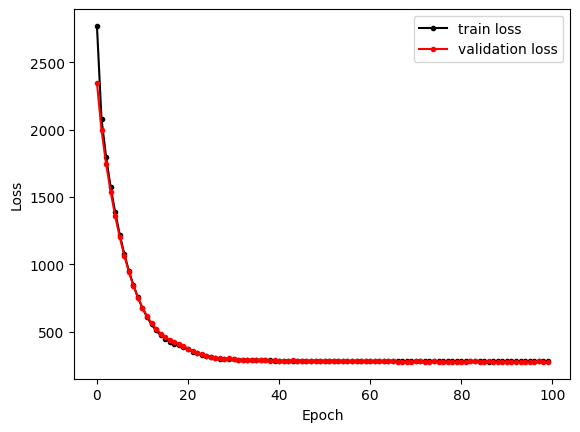

Final train loss: 278.3548889160156
Final validation loss: 274.6968994140625
82/82 [==============================] - 0s 2ms/step


Epoch 1/100
244/244 [==============================] - 3s 6ms/step - loss: 2880.1663 - mse: 2880.1663 - val_loss: 2444.9753 - val_mse: 2444.9753
Epoch 2/100
244/244 [==============================] - 1s 6ms/step - loss: 2163.3889 - mse: 2163.3889 - val_loss: 2078.3252 - val_mse: 2078.3252
Epoch 3/100
244/244 [==============================] - 1s 6ms/step - loss: 1867.8000 - mse: 1867.8000 - val_loss: 1817.6311 - val_mse: 1817.6311
Epoch 4/100
244/244 [==============================] - 2s 6ms/step - loss: 1634.8110 - mse: 1634.8110 - val_loss: 1599.6208 - val_mse: 1599.6208
Epoch 5/100
244/244 [==============================] - 1s 6ms/step - loss: 1437.1206 - mse: 1437.1206 - val_loss: 1411.0258 - val_mse: 1411.0258
Epoch 6/100
244/244 [==============================] - 1s 4ms/step - loss: 1264.7982 - mse: 1264.7982 - val_loss: 1246.1967 - val_mse: 1246.1967
Epoch 7/100
244/244 [==============================] - 1s 4ms/step - loss: 1115.5630 - mse: 1115.5630 - val_loss: 1102.7793 - val_

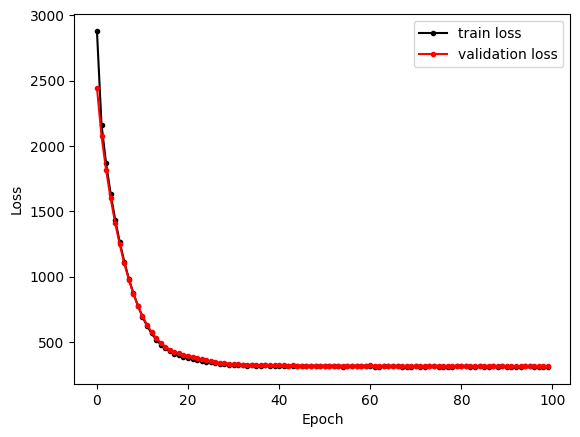

Final train loss: 309.42010498046875
Final validation loss: 315.2604064941406
82/82 [==============================] - 0s 2ms/step



Iteration number:  5

 COMBO:  (0.001, 128, 2, 0.5, 'Adam', 'tanh')
Epoch 1/100
244/244 [==============================] - 3s 5ms/step - loss: 1491.0879 - mse: 1491.0879 - val_loss: 783.3641 - val_mse: 783.3641
Epoch 2/100
244/244 [==============================] - 1s 5ms/step - loss: 529.5673 - mse: 529.5673 - val_loss: 433.9254 - val_mse: 433.9254
Epoch 3/100
244/244 [==============================] - 1s 5ms/step - loss: 402.0369 - mse: 402.0369 - val_loss: 396.3596 - val_mse: 396.3596
Epoch 4/100
244/244 [==============================] - 1s 5ms/step - loss: 394.5469 - mse: 394.5469 - val_loss: 394.0956 - val_mse: 394.0956
Epoch 5/100
244/244 [==============================] - 1s 5ms/step - loss: 395.0107 - mse: 395.0107 - val_loss: 393.2355 - val_mse: 393.2355
Epoch 6/100
244/244 [==============================] - 1s 6ms/step - loss: 364.8626 - mse: 364.8626 - val_loss: 308.2337 - val_mse: 308.2337
Epoch 7/100
244/244 [==============================] - 1s 6ms/step - loss: 328.0093

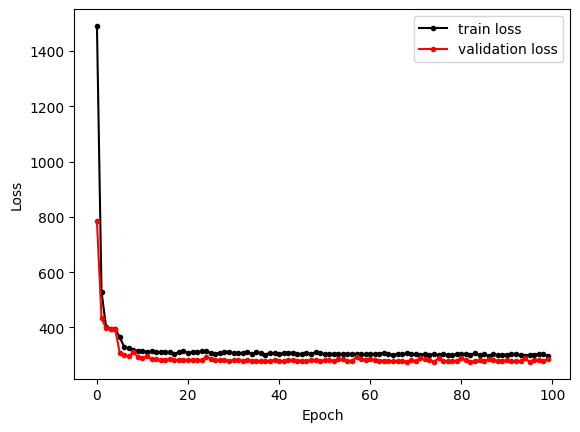

Final train loss: 297.2955627441406
Final validation loss: 286.6077575683594
82/82 [==============================] - 0s 2ms/step


Epoch 1/100
244/244 [==============================] - 3s 5ms/step - loss: 1559.2988 - mse: 1559.2988 - val_loss: 817.4648 - val_mse: 817.4648
Epoch 2/100
244/244 [==============================] - 1s 4ms/step - loss: 545.9086 - mse: 545.9086 - val_loss: 439.3657 - val_mse: 439.3657
Epoch 3/100
244/244 [==============================] - 1s 5ms/step - loss: 402.6611 - mse: 402.6611 - val_loss: 392.5363 - val_mse: 392.5363
Epoch 4/100
244/244 [==============================] - 1s 6ms/step - loss: 375.2196 - mse: 375.2196 - val_loss: 348.7147 - val_mse: 348.7147
Epoch 5/100
244/244 [==============================] - 2s 6ms/step - loss: 348.3455 - mse: 348.3455 - val_loss: 344.8393 - val_mse: 344.8393
Epoch 6/100
244/244 [==============================] - 2s 6ms/step - loss: 346.9047 - mse: 346.9047 - val_loss: 324.9901 - val_mse: 324.9901
Epoch 7/100
244/244 [==============================] - 2s 7ms/step - loss: 343.1002 - mse: 343.1002 - val_loss: 324.2362 - val_mse: 324.2362
Epoch 8/100

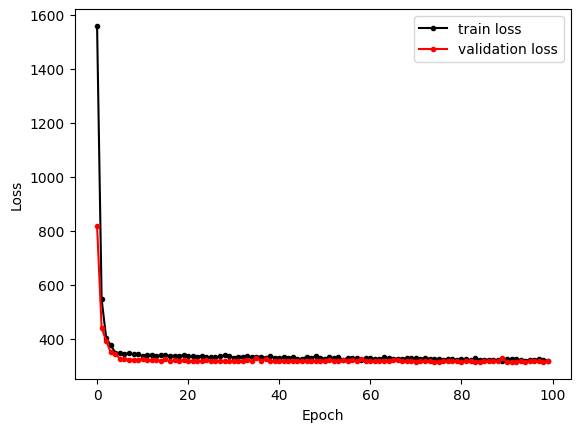

Final train loss: 317.1116027832031
Final validation loss: 315.38671875
82/82 [==============================] - 0s 2ms/step



Iteration number:  6

 COMBO:  (0.005, 64, 3, 0.2, 'Adam', 'sigmoid')
Epoch 1/100
244/244 [==============================] - 3s 5ms/step - loss: 1600.8816 - mse: 1600.8816 - val_loss: 611.1118 - val_mse: 611.1118
Epoch 2/100
244/244 [==============================] - 2s 7ms/step - loss: 432.6470 - mse: 432.6470 - val_loss: 398.4158 - val_mse: 398.4158
Epoch 3/100
244/244 [==============================] - 2s 7ms/step - loss: 388.3998 - mse: 388.3998 - val_loss: 393.4486 - val_mse: 393.4486
Epoch 4/100
244/244 [==============================] - 2s 7ms/step - loss: 386.8942 - mse: 386.8942 - val_loss: 393.6646 - val_mse: 393.6646
Epoch 5/100
244/244 [==============================] - 2s 6ms/step - loss: 388.4570 - mse: 388.4570 - val_loss: 392.9164 - val_mse: 392.9164
Epoch 6/100
244/244 [==============================] - 1s 5ms/step - loss: 389.6575 - mse: 389.6575 - val_loss: 394.7652 - val_mse: 394.7652
Epoch 7/100
244/244 [==============================] - 1s 5ms/step - loss: 389.44

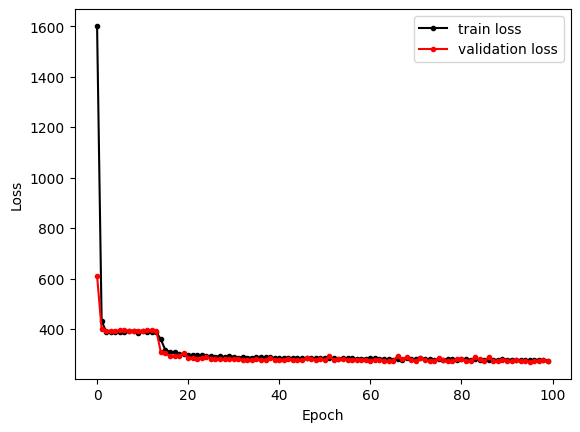

Final train loss: 275.205810546875
Final validation loss: 271.93914794921875
82/82 [==============================] - 0s 2ms/step


Epoch 1/100
244/244 [==============================] - 3s 5ms/step - loss: 1527.1865 - mse: 1527.1865 - val_loss: 608.4066 - val_mse: 608.4066
Epoch 2/100
244/244 [==============================] - 1s 5ms/step - loss: 434.9035 - mse: 434.9035 - val_loss: 399.4619 - val_mse: 399.4619
Epoch 3/100
244/244 [==============================] - 1s 5ms/step - loss: 388.1526 - mse: 388.1526 - val_loss: 393.4829 - val_mse: 393.4829
Epoch 4/100
244/244 [==============================] - 2s 7ms/step - loss: 386.1195 - mse: 386.1195 - val_loss: 393.5233 - val_mse: 393.5233
Epoch 5/100
244/244 [==============================] - 2s 7ms/step - loss: 386.8374 - mse: 386.8374 - val_loss: 392.9459 - val_mse: 392.9459
Epoch 6/100
244/244 [==============================] - 2s 7ms/step - loss: 391.5144 - mse: 391.5144 - val_loss: 394.5409 - val_mse: 394.5409
Epoch 7/100
244/244 [==============================] - 2s 7ms/step - loss: 389.8333 - mse: 389.8333 - val_loss: 394.6536 - val_mse: 394.6536
Epoch 8/100

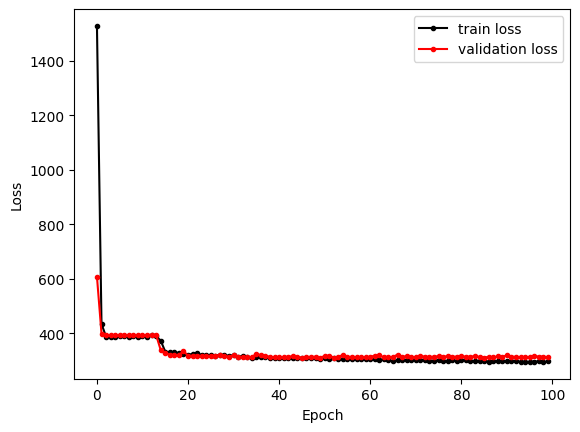

Final train loss: 297.3186950683594
Final validation loss: 312.1640625
82/82 [==============================] - 0s 2ms/step



Iteration number:  7

 COMBO:  (0.001, 64, 2, 0.3, 'Adam', 'tanh')
Epoch 1/100
244/244 [==============================] - 3s 5ms/step - loss: 2311.2766 - mse: 2311.2766 - val_loss: 1678.8912 - val_mse: 1678.8912
Epoch 2/100
244/244 [==============================] - 1s 5ms/step - loss: 1219.7920 - mse: 1219.7920 - val_loss: 951.0984 - val_mse: 951.0984
Epoch 3/100
244/244 [==============================] - 1s 5ms/step - loss: 724.3680 - mse: 724.3680 - val_loss: 602.5930 - val_mse: 602.5930
Epoch 4/100
244/244 [==============================] - 1s 5ms/step - loss: 496.7266 - mse: 496.7266 - val_loss: 461.5113 - val_mse: 461.5113
Epoch 5/100
244/244 [==============================] - 1s 5ms/step - loss: 416.9233 - mse: 416.9233 - val_loss: 412.2981 - val_mse: 412.2981
Epoch 6/100
244/244 [==============================] - 1s 6ms/step - loss: 397.8914 - mse: 397.8914 - val_loss: 398.4076 - val_mse: 398.4076
Epoch 7/100
244/244 [==============================] - 2s 7ms/step - loss: 395.3

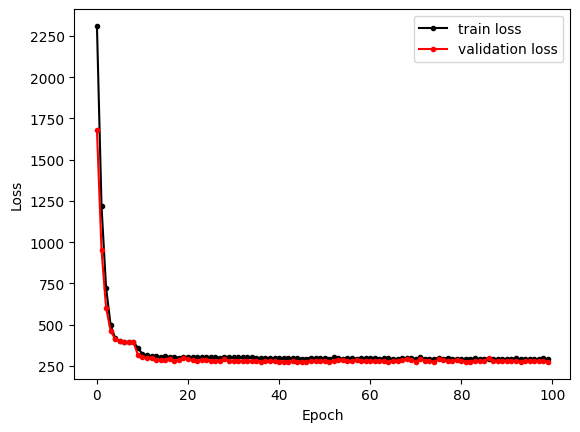

Final train loss: 290.5577392578125
Final validation loss: 275.2100830078125
82/82 [==============================] - 0s 2ms/step


Epoch 1/100
244/244 [==============================] - 4s 8ms/step - loss: 2317.2444 - mse: 2317.2444 - val_loss: 1680.7046 - val_mse: 1680.7046
Epoch 2/100
244/244 [==============================] - 2s 7ms/step - loss: 1220.1144 - mse: 1220.1144 - val_loss: 950.8307 - val_mse: 950.8307
Epoch 3/100
244/244 [==============================] - 2s 7ms/step - loss: 724.2965 - mse: 724.2965 - val_loss: 602.1890 - val_mse: 602.1890
Epoch 4/100
244/244 [==============================] - 1s 5ms/step - loss: 496.3032 - mse: 496.3032 - val_loss: 461.2516 - val_mse: 461.2516
Epoch 5/100
244/244 [==============================] - 1s 5ms/step - loss: 416.8407 - mse: 416.8407 - val_loss: 412.1409 - val_mse: 412.1409
Epoch 6/100
244/244 [==============================] - 1s 5ms/step - loss: 397.2362 - mse: 397.2362 - val_loss: 397.9044 - val_mse: 397.9044
Epoch 7/100
244/244 [==============================] - 1s 4ms/step - loss: 390.9484 - mse: 390.9484 - val_loss: 379.6612 - val_mse: 379.6612
Epoch 8

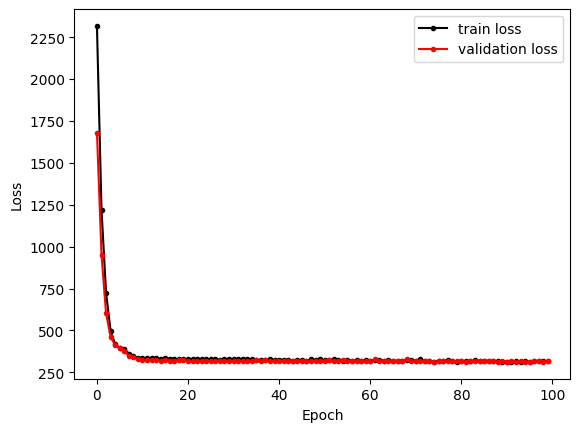

Final train loss: 315.57489013671875
Final validation loss: 316.74993896484375
82/82 [==============================] - 0s 3ms/step



Iteration number:  8

 COMBO:  (0.001, 128, 2, 0.5, 'Adam', 'tanh')

 COMBO:  (0.005, 256, 1, 0.3, 'Adam', 'tanh')
Epoch 1/100
244/244 [==============================] - 2s 5ms/step - loss: 468.8369 - mse: 468.8369 - val_loss: 393.8903 - val_mse: 393.8903
Epoch 2/100
244/244 [==============================] - 1s 4ms/step - loss: 375.4119 - mse: 375.4119 - val_loss: 392.9471 - val_mse: 392.9471
Epoch 3/100
244/244 [==============================] - 1s 4ms/step - loss: 376.2819 - mse: 376.2819 - val_loss: 393.5618 - val_mse: 393.5618
Epoch 4/100
244/244 [==============================] - 1s 4ms/step - loss: 359.2835 - mse: 359.2835 - val_loss: 306.5429 - val_mse: 306.5429
Epoch 5/100
244/244 [==============================] - 1s 4ms/step - loss: 309.0276 - mse: 309.0276 - val_loss: 289.9987 - val_mse: 289.9987
Epoch 6/100
244/244 [==============================] - 1s 4ms/step - loss: 303.0573 - mse: 303.0573 - val_loss: 287.8128 - val_mse: 287.8128
Epoch 7/100
244/244 [=================

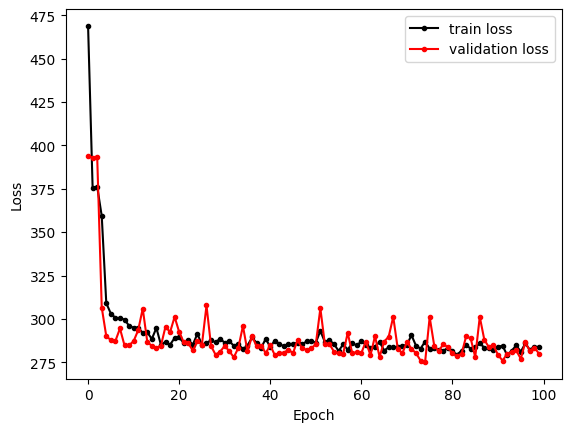

Final train loss: 283.69244384765625
Final validation loss: 279.92828369140625
82/82 [==============================] - 0s 2ms/step


Epoch 1/100
244/244 [==============================] - 2s 5ms/step - loss: 475.2664 - mse: 475.2664 - val_loss: 365.8201 - val_mse: 365.8201
Epoch 2/100
244/244 [==============================] - 1s 6ms/step - loss: 330.4139 - mse: 330.4139 - val_loss: 335.3857 - val_mse: 335.3857
Epoch 3/100
244/244 [==============================] - 1s 6ms/step - loss: 322.4965 - mse: 322.4965 - val_loss: 354.9411 - val_mse: 354.9411
Epoch 4/100
244/244 [==============================] - 1s 6ms/step - loss: 324.8948 - mse: 324.8948 - val_loss: 323.5034 - val_mse: 323.5034
Epoch 5/100
244/244 [==============================] - 1s 6ms/step - loss: 318.9941 - mse: 318.9941 - val_loss: 324.7742 - val_mse: 324.7742
Epoch 6/100
244/244 [==============================] - 1s 5ms/step - loss: 318.5362 - mse: 318.5362 - val_loss: 320.6004 - val_mse: 320.6004
Epoch 7/100
244/244 [==============================] - 1s 5ms/step - loss: 323.1196 - mse: 323.1196 - val_loss: 331.1691 - val_mse: 331.1691
Epoch 8/100
2

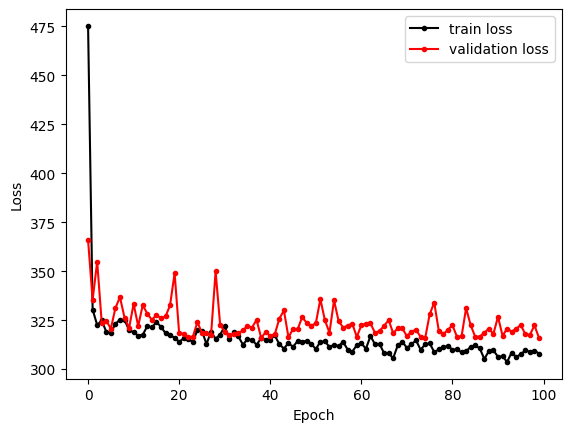

Final train loss: 307.93634033203125
Final validation loss: 315.9764099121094
82/82 [==============================] - 0s 2ms/step



Iteration number:  9

 COMBO:  (0.0001, 128, 2, 0.3, 'Adam', 'relu')
Epoch 1/100
244/244 [==============================] - 3s 5ms/step - loss: 2364.9465 - mse: 2364.9465 - val_loss: 426.5286 - val_mse: 426.5286
Epoch 2/100
244/244 [==============================] - 1s 5ms/step - loss: 401.8920 - mse: 401.8920 - val_loss: 336.2377 - val_mse: 336.2377
Epoch 3/100
244/244 [==============================] - 1s 5ms/step - loss: 397.0439 - mse: 397.0439 - val_loss: 331.5381 - val_mse: 331.5381
Epoch 4/100
244/244 [==============================] - 1s 6ms/step - loss: 393.1920 - mse: 393.1920 - val_loss: 329.5337 - val_mse: 329.5337
Epoch 5/100
244/244 [==============================] - 2s 7ms/step - loss: 382.1952 - mse: 382.1952 - val_loss: 320.7966 - val_mse: 320.7966
Epoch 6/100
244/244 [==============================] - 2s 7ms/step - loss: 370.9366 - mse: 370.9366 - val_loss: 320.6861 - val_mse: 320.6861
Epoch 7/100
244/244 [==============================] - 2s 7ms/step - loss: 363.987

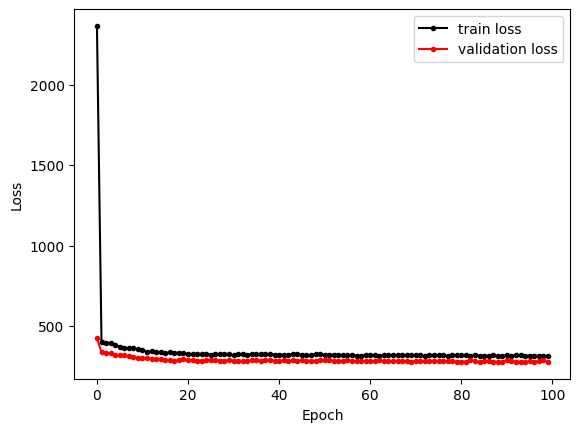

Final train loss: 313.24395751953125
Final validation loss: 276.97076416015625
82/82 [==============================] - 0s 3ms/step


Epoch 1/100
244/244 [==============================] - 3s 5ms/step - loss: 1979.5769 - mse: 1979.5769 - val_loss: 481.1031 - val_mse: 481.1031
Epoch 2/100
244/244 [==============================] - 1s 5ms/step - loss: 499.5950 - mse: 499.5950 - val_loss: 453.8600 - val_mse: 453.8600
Epoch 3/100
244/244 [==============================] - 1s 5ms/step - loss: 463.6144 - mse: 463.6144 - val_loss: 419.8607 - val_mse: 419.8607
Epoch 4/100
244/244 [==============================] - 1s 5ms/step - loss: 431.7325 - mse: 431.7325 - val_loss: 390.2883 - val_mse: 390.2883
Epoch 5/100
244/244 [==============================] - 1s 5ms/step - loss: 404.6620 - mse: 404.6620 - val_loss: 369.7056 - val_mse: 369.7056
Epoch 6/100
244/244 [==============================] - 1s 5ms/step - loss: 389.0525 - mse: 389.0525 - val_loss: 363.9170 - val_mse: 363.9170
Epoch 7/100
244/244 [==============================] - 1s 5ms/step - loss: 382.1537 - mse: 382.1537 - val_loss: 352.5772 - val_mse: 352.5772
Epoch 8/100

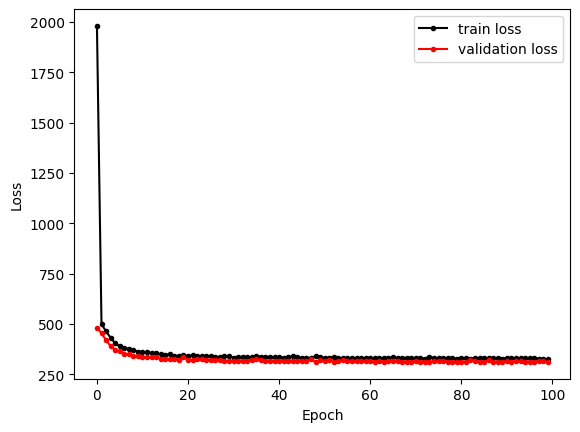

Final train loss: 324.5101318359375
Final validation loss: 311.9073791503906
82/82 [==============================] - 0s 2ms/step



Iteration number:  10

 COMBO:  (0.005, 128, 1, 0.3, 'Adam', 'sigmoid')
Epoch 1/100
244/244 [==============================] - 2s 5ms/step - loss: 1045.5535 - mse: 1045.5535 - val_loss: 400.9073 - val_mse: 400.9073
Epoch 2/100
244/244 [==============================] - 1s 6ms/step - loss: 389.5647 - mse: 389.5647 - val_loss: 393.6912 - val_mse: 393.6912
Epoch 3/100
244/244 [==============================] - 2s 6ms/step - loss: 387.7088 - mse: 387.7088 - val_loss: 395.9520 - val_mse: 395.9520
Epoch 4/100
244/244 [==============================] - 1s 6ms/step - loss: 362.8780 - mse: 362.8780 - val_loss: 330.7253 - val_mse: 330.7253
Epoch 5/100
244/244 [==============================] - 2s 6ms/step - loss: 315.4177 - mse: 315.4177 - val_loss: 294.4994 - val_mse: 294.4994
Epoch 6/100
244/244 [==============================] - 2s 6ms/step - loss: 307.4479 - mse: 307.4479 - val_loss: 317.5732 - val_mse: 317.5732
Epoch 7/100
244/244 [==============================] - 1s 4ms/step - loss: 302.

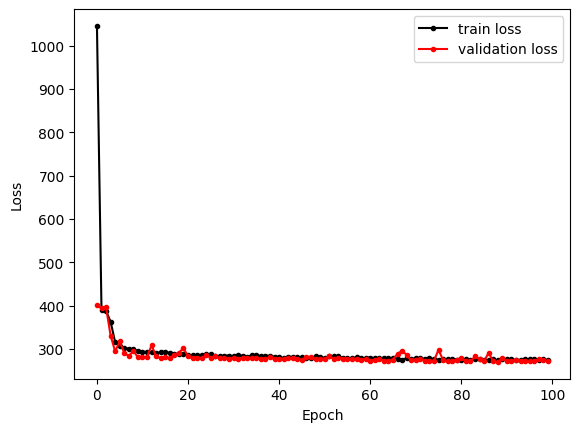

Final train loss: 274.2579040527344
Final validation loss: 271.2701416015625
82/82 [==============================] - 0s 2ms/step


Epoch 1/100
244/244 [==============================] - 2s 5ms/step - loss: 1023.1219 - mse: 1023.1219 - val_loss: 403.1683 - val_mse: 403.1683
Epoch 2/100
244/244 [==============================] - 1s 4ms/step - loss: 388.2287 - mse: 388.2287 - val_loss: 394.5280 - val_mse: 394.5280
Epoch 3/100
244/244 [==============================] - 1s 4ms/step - loss: 352.0658 - mse: 352.0658 - val_loss: 327.7883 - val_mse: 327.7883
Epoch 4/100
244/244 [==============================] - 1s 4ms/step - loss: 328.5926 - mse: 328.5926 - val_loss: 326.0636 - val_mse: 326.0636
Epoch 5/100
244/244 [==============================] - 1s 4ms/step - loss: 329.6206 - mse: 329.6206 - val_loss: 320.9944 - val_mse: 320.9944
Epoch 6/100
244/244 [==============================] - 1s 5ms/step - loss: 326.1674 - mse: 326.1674 - val_loss: 318.6822 - val_mse: 318.6822
Epoch 7/100
244/244 [==============================] - 1s 6ms/step - loss: 327.2425 - mse: 327.2425 - val_loss: 319.4442 - val_mse: 319.4442
Epoch 8/100

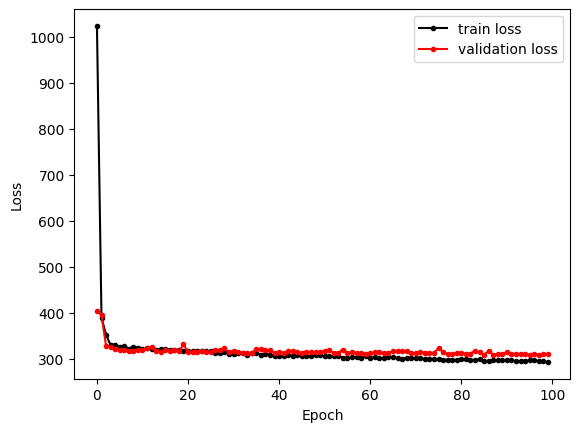

Final train loss: 292.6512451171875
Final validation loss: 308.8894348144531
82/82 [==============================] - 0s 3ms/step



Iteration number:  11

 COMBO:  (0.001, 64, 1, 0.5, 'Adam', 'tanh')
Epoch 1/100
244/244 [==============================] - 2s 5ms/step - loss: 2253.1619 - mse: 2253.1619 - val_loss: 1634.6357 - val_mse: 1634.6357
Epoch 2/100
244/244 [==============================] - 1s 4ms/step - loss: 1194.0306 - mse: 1194.0306 - val_loss: 931.5864 - val_mse: 931.5864
Epoch 3/100
244/244 [==============================] - 1s 5ms/step - loss: 721.1098 - mse: 721.1098 - val_loss: 598.8654 - val_mse: 598.8654
Epoch 4/100
244/244 [==============================] - 1s 4ms/step - loss: 515.9218 - mse: 515.9218 - val_loss: 462.4838 - val_mse: 462.4838
Epoch 5/100
244/244 [==============================] - 1s 4ms/step - loss: 448.4115 - mse: 448.4115 - val_loss: 414.9056 - val_mse: 414.9056
Epoch 6/100
244/244 [==============================] - 1s 6ms/step - loss: 410.9551 - mse: 410.9551 - val_loss: 357.8867 - val_mse: 357.8867
Epoch 7/100
244/244 [==============================] - 2s 6ms/step - loss: 364.

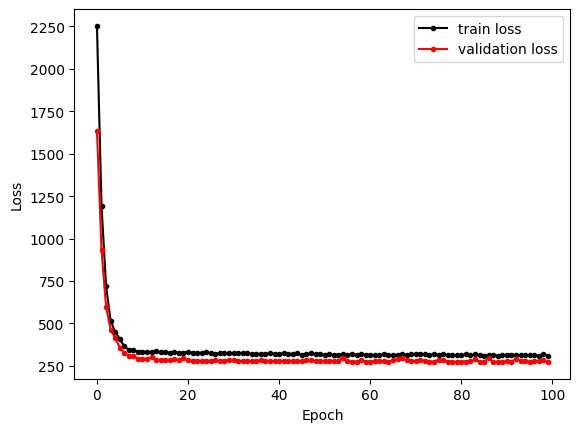

Final train loss: 310.5831604003906
Final validation loss: 274.191162109375
82/82 [==============================] - 0s 3ms/step


Epoch 1/100
244/244 [==============================] - 2s 5ms/step - loss: 2174.4861 - mse: 2174.4861 - val_loss: 1583.7483 - val_mse: 1583.7483
Epoch 2/100
244/244 [==============================] - 1s 4ms/step - loss: 1154.4518 - mse: 1154.4518 - val_loss: 901.4890 - val_mse: 901.4890
Epoch 3/100
244/244 [==============================] - 1s 4ms/step - loss: 700.7144 - mse: 700.7144 - val_loss: 583.1315 - val_mse: 583.1315
Epoch 4/100
244/244 [==============================] - 1s 4ms/step - loss: 506.4754 - mse: 506.4754 - val_loss: 454.8632 - val_mse: 454.8632
Epoch 5/100
244/244 [==============================] - 1s 4ms/step - loss: 442.9372 - mse: 442.9372 - val_loss: 409.2830 - val_mse: 409.2830
Epoch 6/100
244/244 [==============================] - 1s 4ms/step - loss: 419.5224 - mse: 419.5224 - val_loss: 384.5717 - val_mse: 384.5717
Epoch 7/100
244/244 [==============================] - 1s 6ms/step - loss: 397.3258 - mse: 397.3258 - val_loss: 368.6742 - val_mse: 368.6742
Epoch 8

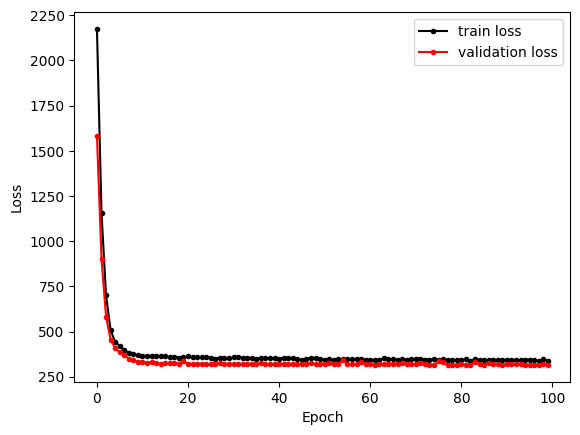

Final train loss: 336.6419982910156
Final validation loss: 315.36639404296875
82/82 [==============================] - 0s 2ms/step



Iteration number:  12

 COMBO:  (0.0001, 256, 2, 0.5, 'Adam', 'sigmoid')
Epoch 1/100
244/244 [==============================] - 5s 7ms/step - loss: 3131.3472 - mse: 3131.3472 - val_loss: 2699.5876 - val_mse: 2699.5876
Epoch 2/100
244/244 [==============================] - 1s 5ms/step - loss: 2438.9043 - mse: 2438.9043 - val_loss: 2340.8918 - val_mse: 2340.8918
Epoch 3/100
244/244 [==============================] - 1s 5ms/step - loss: 2124.8420 - mse: 2124.8420 - val_loss: 2051.2561 - val_mse: 2051.2561
Epoch 4/100
244/244 [==============================] - 1s 5ms/step - loss: 1853.5148 - mse: 1853.5148 - val_loss: 1794.5663 - val_mse: 1794.5663
Epoch 5/100
244/244 [==============================] - 1s 5ms/step - loss: 1617.0939 - mse: 1617.0939 - val_loss: 1573.8757 - val_mse: 1573.8757
Epoch 6/100
244/244 [==============================] - 1s 6ms/step - loss: 1416.8345 - mse: 1416.8345 - val_loss: 1382.0850 - val_mse: 1382.0850
Epoch 7/100
244/244 [==============================] - 1

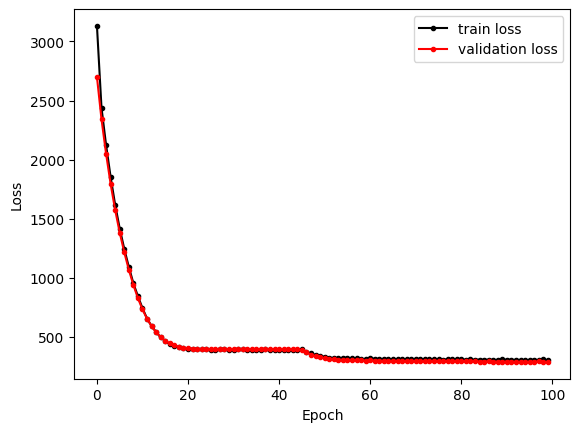

Final train loss: 302.0753479003906
Final validation loss: 287.74310302734375
82/82 [==============================] - 0s 2ms/step


Epoch 1/100
244/244 [==============================] - 3s 5ms/step - loss: 2986.1809 - mse: 2986.1809 - val_loss: 2547.7568 - val_mse: 2547.7568
Epoch 2/100
244/244 [==============================] - 1s 5ms/step - loss: 2294.8486 - mse: 2294.8486 - val_loss: 2192.8896 - val_mse: 2192.8896
Epoch 3/100
244/244 [==============================] - 2s 6ms/step - loss: 1978.9521 - mse: 1978.9521 - val_loss: 1909.0208 - val_mse: 1909.0208
Epoch 4/100
244/244 [==============================] - 2s 7ms/step - loss: 1722.2612 - mse: 1722.2612 - val_loss: 1668.1484 - val_mse: 1668.1484
Epoch 5/100
244/244 [==============================] - 2s 6ms/step - loss: 1500.0341 - mse: 1500.0341 - val_loss: 1460.1777 - val_mse: 1460.1777
Epoch 6/100
244/244 [==============================] - 2s 7ms/step - loss: 1310.2701 - mse: 1310.2701 - val_loss: 1279.1923 - val_mse: 1279.1923
Epoch 7/100
244/244 [==============================] - 2s 7ms/step - loss: 1148.3323 - mse: 1148.3323 - val_loss: 1120.7854 - val_

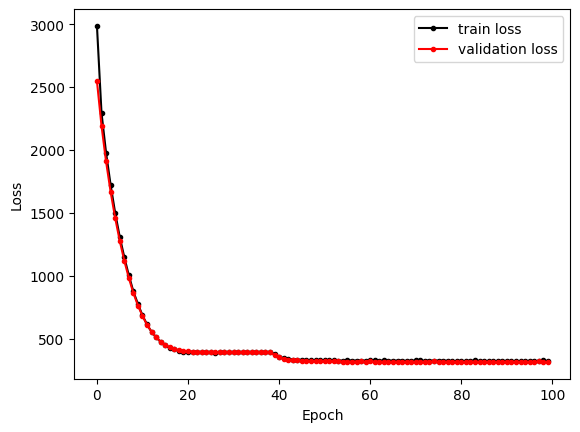

Final train loss: 321.6589660644531
Final validation loss: 315.7183837890625
82/82 [==============================] - 0s 3ms/step



Iteration number:  13

 COMBO:  (0.001, 128, 1, 0.2, 'Adam', 'tanh')
Epoch 1/100
244/244 [==============================] - 2s 5ms/step - loss: 1504.0580 - mse: 1504.0580 - val_loss: 794.9644 - val_mse: 794.9644
Epoch 2/100
244/244 [==============================] - 1s 4ms/step - loss: 521.1812 - mse: 521.1812 - val_loss: 431.4577 - val_mse: 431.4577
Epoch 3/100
244/244 [==============================] - 1s 5ms/step - loss: 377.9768 - mse: 377.9768 - val_loss: 359.9567 - val_mse: 359.9567
Epoch 4/100
244/244 [==============================] - 1s 4ms/step - loss: 321.9580 - mse: 321.9580 - val_loss: 311.6112 - val_mse: 311.6112
Epoch 5/100
244/244 [==============================] - 1s 4ms/step - loss: 295.0564 - mse: 295.0564 - val_loss: 293.7163 - val_mse: 293.7163
Epoch 6/100
244/244 [==============================] - 1s 4ms/step - loss: 288.5772 - mse: 288.5772 - val_loss: 291.5235 - val_mse: 291.5235
Epoch 7/100
244/244 [==============================] - 1s 4ms/step - loss: 285.898

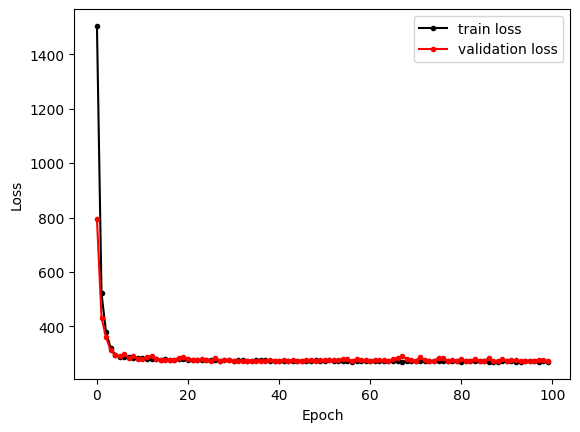

Final train loss: 270.59442138671875
Final validation loss: 272.070068359375
82/82 [==============================] - 0s 2ms/step


Epoch 1/100
244/244 [==============================] - 4s 7ms/step - loss: 1442.0466 - mse: 1442.0466 - val_loss: 761.6962 - val_mse: 761.6962
Epoch 2/100
244/244 [==============================] - 2s 7ms/step - loss: 502.6636 - mse: 502.6636 - val_loss: 422.9713 - val_mse: 422.9713
Epoch 3/100
244/244 [==============================] - 2s 7ms/step - loss: 375.8197 - mse: 375.8197 - val_loss: 381.8575 - val_mse: 381.8575
Epoch 4/100
244/244 [==============================] - 1s 4ms/step - loss: 346.5199 - mse: 346.5199 - val_loss: 346.1427 - val_mse: 346.1427
Epoch 5/100
244/244 [==============================] - 1s 4ms/step - loss: 322.9045 - mse: 322.9045 - val_loss: 329.6443 - val_mse: 329.6443
Epoch 6/100
244/244 [==============================] - 1s 4ms/step - loss: 315.5329 - mse: 315.5329 - val_loss: 322.1075 - val_mse: 322.1075
Epoch 7/100
244/244 [==============================] - 1s 5ms/step - loss: 313.3766 - mse: 313.3766 - val_loss: 320.4475 - val_mse: 320.4475
Epoch 8/100

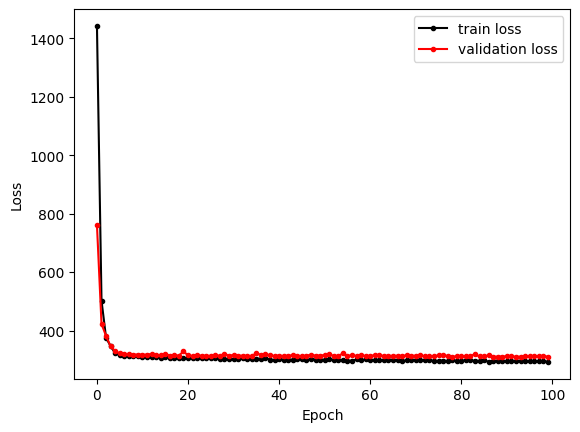

Final train loss: 292.85589599609375
Final validation loss: 310.068115234375
82/82 [==============================] - 0s 2ms/step



Iteration number:  14

 COMBO:  (0.0001, 128, 1, 0.2, 'Adam', 'sigmoid')
Epoch 1/100
244/244 [==============================] - 2s 5ms/step - loss: 3558.5659 - mse: 3558.5659 - val_loss: 3345.8513 - val_mse: 3345.8513
Epoch 2/100
244/244 [==============================] - 1s 4ms/step - loss: 3063.8811 - mse: 3063.8811 - val_loss: 2998.7412 - val_mse: 2998.7412
Epoch 3/100
244/244 [==============================] - 1s 6ms/step - loss: 2797.6050 - mse: 2797.6050 - val_loss: 2778.5745 - val_mse: 2778.5745
Epoch 4/100
244/244 [==============================] - 2s 6ms/step - loss: 2593.3931 - mse: 2593.3931 - val_loss: 2575.3191 - val_mse: 2575.3191
Epoch 5/100
244/244 [==============================] - 2s 7ms/step - loss: 2402.4478 - mse: 2402.4478 - val_loss: 2397.6555 - val_mse: 2397.6555
Epoch 6/100
244/244 [==============================] - 2s 6ms/step - loss: 2235.8416 - mse: 2235.8416 - val_loss: 2234.8208 - val_mse: 2234.8208
Epoch 7/100
244/244 [==============================] - 2

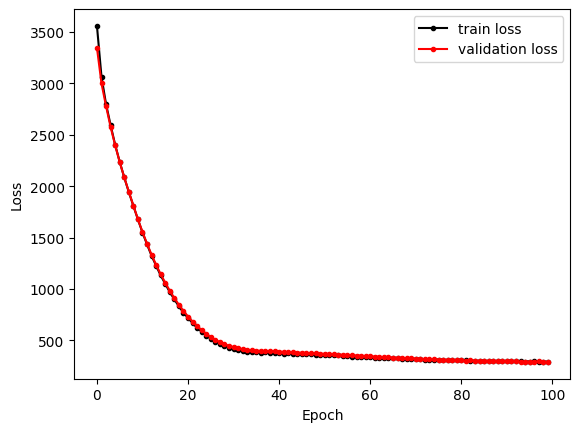

Final train loss: 291.57501220703125
Final validation loss: 292.0859069824219
82/82 [==============================] - 0s 3ms/step


Epoch 1/100
244/244 [==============================] - 2s 5ms/step - loss: 3423.5759 - mse: 3423.5759 - val_loss: 3155.6182 - val_mse: 3155.6182
Epoch 2/100
244/244 [==============================] - 1s 5ms/step - loss: 2843.9197 - mse: 2843.9197 - val_loss: 2758.5442 - val_mse: 2758.5442
Epoch 3/100
244/244 [==============================] - 1s 5ms/step - loss: 2557.2036 - mse: 2557.2036 - val_loss: 2532.7725 - val_mse: 2532.7725
Epoch 4/100
244/244 [==============================] - 1s 4ms/step - loss: 2359.6233 - mse: 2359.6233 - val_loss: 2350.2339 - val_mse: 2350.2339
Epoch 5/100
244/244 [==============================] - 1s 4ms/step - loss: 2186.5913 - mse: 2186.5913 - val_loss: 2184.1943 - val_mse: 2184.1943
Epoch 6/100
244/244 [==============================] - 1s 5ms/step - loss: 2031.9337 - mse: 2031.9337 - val_loss: 2030.7577 - val_mse: 2030.7577
Epoch 7/100
244/244 [==============================] - 2s 6ms/step - loss: 1886.2288 - mse: 1886.2288 - val_loss: 1889.0050 - val_

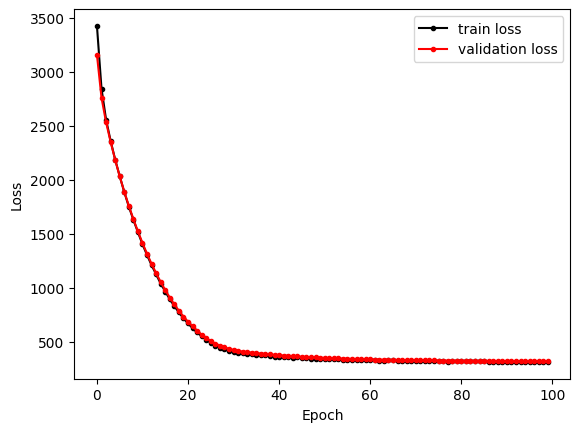

Final train loss: 313.7970275878906
Final validation loss: 319.3128662109375
82/82 [==============================] - 0s 2ms/step


In [ ]:
#test this out for combinations of hyperparameters using a random search


model_1_type = [ "regression", "classification"]
learning_rates =[0.0001,.005, 0.001]
hidden_sizes = [64, 128, 256]
num_layers= [1,2,3]
dropouts = [0.2, 0.3, 0.5]
optimizers = ['Adam']
activations = ['relu', 'tanh', 'sigmoid']


num_models = 15 #number of times you want to randomly sample times two because we do one for classification and regression
hyperp_combo = [] #make sure not using same combination twice

for i in range(num_models):
  print("\nIteration number: ", i)

  while True:
    learning_rate = random.choice(learning_rates)
    hidden_size = random.choice(hidden_sizes)
    num_layer = random.choice(num_layers)
    dropout = random.choice(dropouts)
    optimizer = random.choice(optimizers)
    activation = random.choice(activations)

    combo = (learning_rate, hidden_size, num_layer, dropout, optimizer, activation)

    print("\n COMBO: ", combo)

    if combo not in hyperp_combo:
      hyperp_combo.append(combo)
      break
  for model_type in model_1_type:
    create_train_evaluate_model_2(
        model_1_type=model_type,
          learning_rate=learning_rate,
          hidden_size=hidden_size,
          num_layers=num_layer,
          dropout=dropout,
          num_epochs=100,
          batch_size=32,
          optimizer = optimizer,
          activation = activation,
          verbose=1)



In [ ]:
pd.set_option('display.max_rows', None)

In [ ]:
hyperp_df2 = hyperp_df2.sort_values(by = "Mean QWK", ascending = False)

In [ ]:
hyperp_df2

Model 1 type  Learning Rate  Hidden Size  Hidden Layers  Dropout Rate  \
14      regression         0.0010           64              2           0.3   
12      regression         0.0050           64              3           0.2   
4       regression         0.0010          256              1           0.3   
18      regression         0.0001          128              2           0.3   
22      regression         0.0010           64              1           0.5   
20      regression         0.0050          128              1           0.3   
26      regression         0.0010          128              1           0.2   
8       regression         0.0001          128              1           0.3   
2       regression         0.0001          256              3           0.3   
10      regression         0.0010          128              2           0.5   
16      regression         0.0050          256              1           0.3   
24      regression         0.0001          256              2           0.5   
15  classification         0.0010           64              2           0.3   
5   classification         0.0010          256              1           0.3   
28      regression         0.0001          128              1           0.2   
13  classification         0.0050           64              3           0.2   
27  classification         0.0010          128              1           0.2   
17  classification         0.0050          256              1           0.3   
19  classification         0.0001          128              2           0.3   
11  classification         0.0010          128              2           0.5   
1   classification         0.0050           64              3           0.5   
3   classification         0.0001          256              3           0.3   
21  classification         0.0050          128              1           0.3   
23  classification         0.0010           64              1           0.5   
9   classification         0.0001          128              1           0.3   
25  classification         0.0001          256              2           0.5   
29  classification         0.0001          128              1           0.2   
0       regression         0.0050           64              3           0.5   
7   classification         0.0050          256              3           0.3   
6       regression         0.0050          256              3           0.3   

    Epochs  Batch Size Optimizer Activation  Essay Set 1  Essay Set 2  \
14     100          32      Adam       tanh     0.479608     0.584324   
12     100          32      Adam    sigmoid     0.526172     0.559069   
4      100          32      Adam       relu     0.544475     0.554781   
18     100          32      Adam       relu     0.555012     0.606551   
22     100          32      Adam       tanh     0.450113     0.580654   
20     100          32      Adam    sigmoid     0.497200     0.516651   
26     100          32      Adam       tanh     0.430933     0.550382   
8      100          32      Adam       tanh     0.435049     0.539971   
2      100          32      Adam       tanh     0.403056     0.513915   
10     100          32      Adam       tanh     0.407478     0.460719   
16     100          32      Adam       tanh     0.385927     0.454815   
24     100          32      Adam    sigmoid     0.416846     0.469356   
15     100          32      Adam       tanh     0.362152     0.451104   
5      100          32      Adam       relu     0.372762     0.498687   
28     100          32      Adam    sigmoid     0.396719     0.447132   
13     100          32      Adam    sigmoid     0.379671     0.397294   
27     100          32      Adam       tanh     0.367530     0.469286   
17     100          32      Adam       tanh     0.330065     0.393075   
19     100          32      Adam       relu     0.335277     0.486745   
11     100          32      Adam       tanh     0.365387     0.407993   
1      100          32 

In [ ]:
# create the stage 2 model using pre-generated features (don't use stage 1 model directly)

mod = create_train_evaluate_model_2(model_1_type="regression",
                                    learning_rate=0.01,
                                    hidden_size=64,
                                    num_layers=1,
                                    dropout=0.2,
                                    num_epochs=100,
                                    batch_size=32,
                                    optimizer = "Adam",
                                    activation = "tanh",
                                    show_plots=True,
                                    verbose=1)

In [ ]:
# # DANGER: only uncomment this cell if you want to CHANGE the currently saved version of hyperp_df2.csv
# # uncomment to write the current hyper parameter table to a csv file

#hyperp_df2.to_csv("/content/drive/MyDrive/Colab/hyperp_df2.csv")

hyperp_df2.to_csv("/content/drive/MyDrive/Colab/hyperp_df2_randomsearch.csv")

In [ ]:
# create the stage 2 model using the stage 1 model directly

mod_fresh = create_train_evaluate_model_2(model_1_type="classification",
                                          model_1=cat_model,              # pass in the model you want to use here
                                          learning_rate=0.00005,
                                          hidden_size=64,
                                          num_layers=1,
                                          dropout=0.3,
                                          num_epochs=10,
                                          batch_size=32,
                                          show_plots=True,
                                          verbose=1)